In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy import stats
from scipy import interpolate
import matplotlib.cm as cm
import numpy.polynomial.polynomial as poly  
%matplotlib inline

In [2]:
df = pd.read_csv('../WORK/surf_bT_ret_171031.txt', header=None, delimiter=r"\s+", names = [' ', 'UTC', 'MY', 'L_s', 'LTST', 'Surf_lat', 'Surf_lon', 'Surf_rad', 'Surf_elev', 'T_surf', 'T_surf_err', 'Dust_column', 'Dust_column_err', 'H2Oice_column', 'H2Oice_column_err', 'p_surf', 'p_surf_err', 'P_qual', 'T_qual'])
#read data into dataframe

The above reads the text file into a dataframe

In [7]:
########
# pco2 #
########
# --------------------------------------------
# Equilibrium vapor pressure over solid CO2
# Brown and Ziegler (1980)
# --------------------------------------------
# Input:
#    T = temperature of solid [K]
# Output:
#    vapor pressure [Pa]
def pco2(T):
    A0 = 2.13807649e1
    A1 = -2.57064700e3
    A2 = -7.78129489e4
    A3 = 4.32506256e6
    A4 = -1.20671368e8
    A5 = 1.34966306e9
    # Pressure in torr
    ptorr = np.exp(A0 + (A1/(T)) + (A2/(T**2)) + (A3/(T**3)) + (A4/(T**4)) + (A5/(T**5)))
    # Pressure in Pa
    p = ptorr*133.3223684211
    return p

In [8]:
########
# tco2 #
########
#-------------------------------------------------------------------------
#Calculate (approximately) the condensation temperature of CO2 at the
#specified pressure(s) (Pa), using the empirical law from Brown and 
#Ziegler (1980). This function calls the pco2() routine.
#-------------------------------------------------------------------------
# Input:
#    p = vapor pressure [Pa]
# Output:
#    temperature of solid [K]
def tco2(p):
    Trange = np.arange(30,350)
    T = interpolate.pchip_interpolate(pco2(Trange),Trange,p)
    return T

Both Formulas above are to calculate the equilibrium vapor pressure and temperature for carbon dioxide

In [9]:
# Function: ls2sol
# Purpose: convert Mars "Lsubs" to sol (day of year)
# Input: 
#    ls = areocentric longitude of the Sun [array]
#    n = degree of polynomial fit [scalar]
def ls2sol(ls, n):
    # data
    lsdata = (0,30,60,90,120,150,180,210,240,270,300,330,360) # L_s array
    soldata = (0,61.2,126.6,193.3,257.8,317.5,371.9,421.6,468.5,514.6,562.0,612.9,668.6) # Sol array
    
    # polynomial fit
    p = np.polyfit(lsdata, soldata, n)
    
    # sol for Ls input
    sol = np.polyval(p, ls)
    
    # return result
    return sol

Formula to convert solar longitude to Sols

In [10]:
df['Sol'] = ls2sol(df['L_s'],8)
dfday = df[df['LTST'] >= .5]
dfnight = df[df['LTST'] <= .5]

In [11]:
cond = (df['MY'],df['L_s'],pco2(df['T_surf']), df['p_surf'], tco2(df['p_surf']), df['T_surf'], df['LTST'], df['Surf_lat'], df['Surf_lon'], df['Dust_column'] , df['Sol'] )
cond_right= np.transpose(cond)
CO2 = pd.DataFrame(list(cond_right))
CO2.columns = ['MY','L_s','Eq_Vap_P','p_surf','Frost_T','T_surf','LTST', 'Surf_lat', 'Surf_lon', 'Dust_column', 'Sol']

In [12]:
newCO2 = CO2[CO2['Eq_Vap_P'] <= CO2['p_surf']]

In [13]:
CO2day = CO2[CO2['LTST'] >= 0.5]
CO2night = CO2[CO2['LTST'] <= 0.5]

In [14]:
def MYretrieval(dataframe, MY):
    if MY == '28':
        return dataframe[(dataframe['MY'] == 28)]
    elif MY == '29':
        return dataframe[(dataframe['MY'] == 29)]
    elif MY == '30':
        return dataframe[(dataframe['MY'] == 30)]
    elif MY == '31':
        return dataframe[(dataframe['MY'] == 31)]
    elif MY == '32':
        return dataframe[(dataframe['MY'] == 32)]
    elif MY == '33':
        return dataframe[(dataframe['MY'] == 33)]
    elif MY == '34':
        return dataframe[(dataframe['MY'] == 34)]
    elif MY == '35':
        return dataframe[(dataframe['MY'] == 35)]

In [15]:
def CreateSubFrame(MarsDF, RanL_s, RanLat, RanLong):
    '''Function to divide previously created data frames in smaller data frames by providing ranges
    Input:
    MarsYearDF: Mars Data frames 
    RanL_s: range of Solar Longitude example [0,360]
    RanAlbedo: Albedo Range example [0.5,1.0]
    RanSZA Solar Zenith angle range example [0,45]
    RanLat and RanLong are set as default
    Output: Several Subframes'''
    L_s_MYDF = MarsDF['L_s']
    Lat_MYDF = MarsDF['Surf_lat']
    Long_MYDF = MarsDF['Surf_lon']
    MY_SUB = MarsDF[(L_s_MYDF <= RanL_s[-1])  & (L_s_MYDF >= RanL_s[0]) &
                        (Lat_MYDF <= RanLat[-1] ) & (Lat_MYDF >= RanLat[0]) & 
                        (Long_MYDF <= RanLong[-1]) & (Long_MYDF >= RanLong[0])]
    return MY_SUB

In [16]:
def column(MYDict, Parameter):
    '''Function to run statistics on data on the subframes from the dictionaries created by the SubDict function
    Input:
    MYDict: Dictionary Created by the SubDict Function
    Output:
    SubAvg: Average of the Albedo for each subframe in the dictionary
    SubStd: Standard Deviation of the Albedo for each subframe in the dictionary
    Sub_L_s: Average of the  Solar Longitude range for each subframe in the dictionary'''
    SubframeNum = len(MYDict.keys())
    SubTemp = []
    SubPres =[]
    SubMY = []
    SubLat =[]
    SubLong = []
    SubDust =[]
    SubSol = []
    SubStr = 'DataFrame{}'
    for i in range(SubframeNum):
        Subframe = MYDict[SubStr.format(i)]
        SubTemp.append((Subframe['T_surf'].values))
        SubPres.append((Subframe['p_surf'].values))
        SubMY.append((Subframe['MY'].values))
        SubLat.append((Subframe['Surf_lat'].values))
        SubLong.append((Subframe['Surf_lon'].values))
        SubDust.append((Subframe['Dust_column'].values))
        SubSol.append((Subframe['Sol'].values))
    SubTemp = np.array(SubTemp)
    SubPres = np.array(SubPres)
    SubMY = np.array(SubMY)
    SubLat = np.array(SubLat)
    SubLong = np.array(SubLong)
    SubDust = np.array(SubDust)
    SubSol = np.array(SubSol)
    if Parameter =='Temperature':
        return SubTemp
    elif Parameter =='Pressure': 
        return SubPres
    elif Parameter =='Martian Year':
        return SubMY 
    elif Parameter =='Latitude':
        return SubLat 
    elif Parameter =='Longitude':
        return SubLong
    elif Parameter =='Dust Column':
        return SubDust
    elif Parameter =='Sol':
        return SubSol 

In [360]:
def IRFlux(T):
    '''Calculate the luminosity of the thing.
    Input:
    T = Temperature
    Output:
    boltz = luminosity'''
    sigma = 5.67e-8 # W/m**2/K**4
    boltz = sigma * T**4
    return boltz

In [361]:
def square(lat,lon,size=59.157935, type = 'km'): # 1 degree latitude (Co-created with Tyler Horvath)
    '''Function to draw equal length trapezoid that are latitude dependent
    Inputs:
    Latitude = array or float, latitude of the locations
    Longitude = array or float, longitude of the locations
    Size = size of the box default is equal to one degree by one degree could be kilometers or degrees
    type = string, if input is km the size argument is inputed as kilometers else, deg is inputed as degrees
    Outputs:
    lower_lat = lower latitude 
    upper_lat = upper latitude 
    right_lon = right longitude corner
    left_lon = left longitude corner'''
    radius = 3389.5 # mars radius in km
    d2r = np.pi/180
    if type == 'km': # treat size input as km if >= 59....
        lat_deg = size*180/(np.pi*radius)
        upper_lat = lat + .5 * lat_deg
        lower_lat = lat - .5 * lat_deg
        lon_deg = size / (np.pi * np.cos(upper_lat*d2r) / 180)
        left_lon = lon - .5 * lon_deg * size
        right_lon = lon + .5 * lon_deg * size
        return(lower_lat, upper_lat, right_lon, left_lon)
    elif type == 'deg':
        upper_lat = lat + .5 * size
        lower_lat = lat - .5 * size
        leng = radius * np.pi * np.cos(upper_lat*d2r)*2
        lon_deg = 59.157935*size/leng*360
        left_lon = lon - .5 * lon_deg 
        right_lon = lon + .5 * lon_deg
        return(lower_lat, upper_lat, right_lon, left_lon)

In [362]:
def xerr(a,b,covmat):
    '''Function to calculate the x-intercept of a fitted line in the form y = ax+b with its error
    Inputs:
    a = float, the slope of the fitted line
    b = float, the x intercept of the line
    covmat = array, the covariance matrix of the fitted line
    Outputs:
    x = float, the x-intercept of the line
    stdx = float , error of the line '''
    x = -b/a
    stdx = x*np.sqrt((covmat[1,1]/(b**2))+(covmat[0,0]/(a**2))-2*((covmat[0,1]/(a*b))))
    return x, stdx

In [19]:
dfday28 = MYretrieval(dfday, '28')
dfday29 = MYretrieval(dfday, '29')
dfday30 = MYretrieval(dfday, '30')
dfday31 = MYretrieval(dfday, '31')
dfday32 = MYretrieval(dfday, '32')
dfday33 = MYretrieval(dfday, '33')
dfday34 = MYretrieval(dfday, '34')
dfday35 = MYretrieval(dfday, '35')

dfnight28 = MYretrieval(dfnight, '28')
dfnight29 = MYretrieval(dfnight, '29')
dfnight30 = MYretrieval(dfnight, '30')
dfnight31 = MYretrieval(dfnight, '31')
dfnight32 = MYretrieval(dfnight, '32')
dfnight33 = MYretrieval(dfnight, '33')
dfnight34 = MYretrieval(dfnight, '34')
dfnight35 = MYretrieval(dfnight, '35')

CO2day28 = MYretrieval(CO2day, '28')
CO2day29 = MYretrieval(CO2day, '29')
CO2day30 = MYretrieval(CO2day, '30')
CO2day31 = MYretrieval(CO2day, '31')
CO2day32 = MYretrieval(CO2day, '32')
CO2day33 = MYretrieval(CO2day, '33')
CO2day34 = MYretrieval(CO2day, '34')
CO2day35 = MYretrieval(CO2day, '35')

CO2night28 = MYretrieval(CO2night, '28')
CO2night29 = MYretrieval(CO2night, '29')
CO2night30 = MYretrieval(CO2night, '30')
CO2night31 = MYretrieval(CO2night, '31')
CO2night32 = MYretrieval(CO2night, '32')
CO2night33 = MYretrieval(CO2night, '33')
CO2night34 = MYretrieval(CO2night, '34')
CO2night35 = MYretrieval(CO2night, '35')

In [20]:
dfday28.insert(10 , 'Frost_T', CO2day28['Frost_T'])
dfday29.insert(10 , 'Frost_T', CO2day29['Frost_T'])
dfday30.insert(10 , 'Frost_T', CO2day30['Frost_T'])
dfday31.insert(10 , 'Frost_T', CO2day31['Frost_T'])
dfday32.insert(10 , 'Frost_T', CO2day32['Frost_T'])
dfday33.insert(10 , 'Frost_T', CO2day33['Frost_T'])
dfday34.insert(10 , 'Frost_T', CO2day34['Frost_T'])
dfday35.insert(10 , 'Frost_T', CO2day35['Frost_T'])

dfnight28.insert(10 , 'Frost_T', CO2night28['Frost_T'])
dfnight29.insert(10 , 'Frost_T', CO2night29['Frost_T'])
dfnight30.insert(10 , 'Frost_T', CO2night30['Frost_T'])
dfnight31.insert(10 , 'Frost_T', CO2night31['Frost_T'])
dfnight32.insert(10 , 'Frost_T', CO2night32['Frost_T'])
dfnight33.insert(10 , 'Frost_T', CO2night33['Frost_T'])
dfnight34.insert(10 , 'Frost_T', CO2night34['Frost_T'])
dfnight35.insert(10 , 'Frost_T', CO2night35['Frost_T'])

In [21]:
Lyot =square(50.8, 150.7, size=4, type = 'deg')

In [22]:
Lyot_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

Lyot_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

Lyot_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

Lyot_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

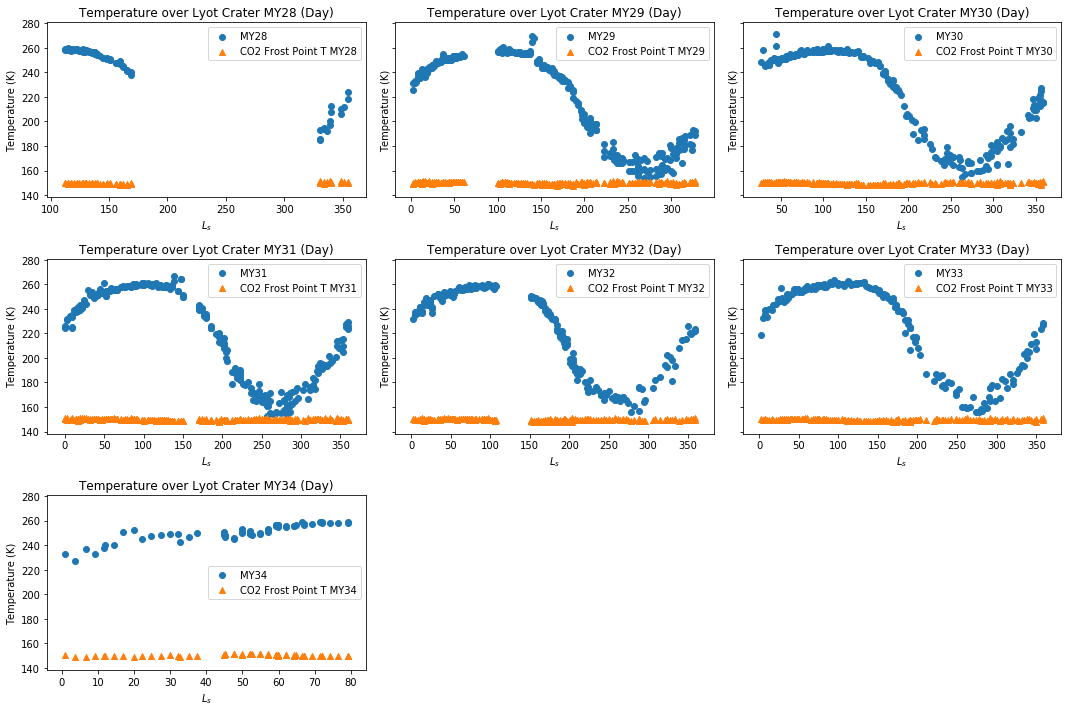

In [23]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Lyot_SubframesDayMY28['L_s'], Lyot_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Lyot_CO2day28['L_s'],Lyot_CO2day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Lyot_SubframesDayMY29['L_s'], Lyot_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Lyot_CO2day29['L_s'],Lyot_CO2day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Lyot_SubframesDayMY30['L_s'], Lyot_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Lyot_CO2day30['L_s'],Lyot_CO2day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Lyot_SubframesDayMY31['L_s'], Lyot_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Lyot_CO2day31['L_s'],Lyot_CO2day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Lyot_SubframesDayMY32['L_s'], Lyot_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Lyot_CO2day32['L_s'],Lyot_CO2day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Lyot_SubframesDayMY33['L_s'], Lyot_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Lyot_CO2day33['L_s'],Lyot_CO2day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Lyot_SubframesDayMY34['L_s'], Lyot_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Lyot_CO2day34['L_s'],Lyot_CO2day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

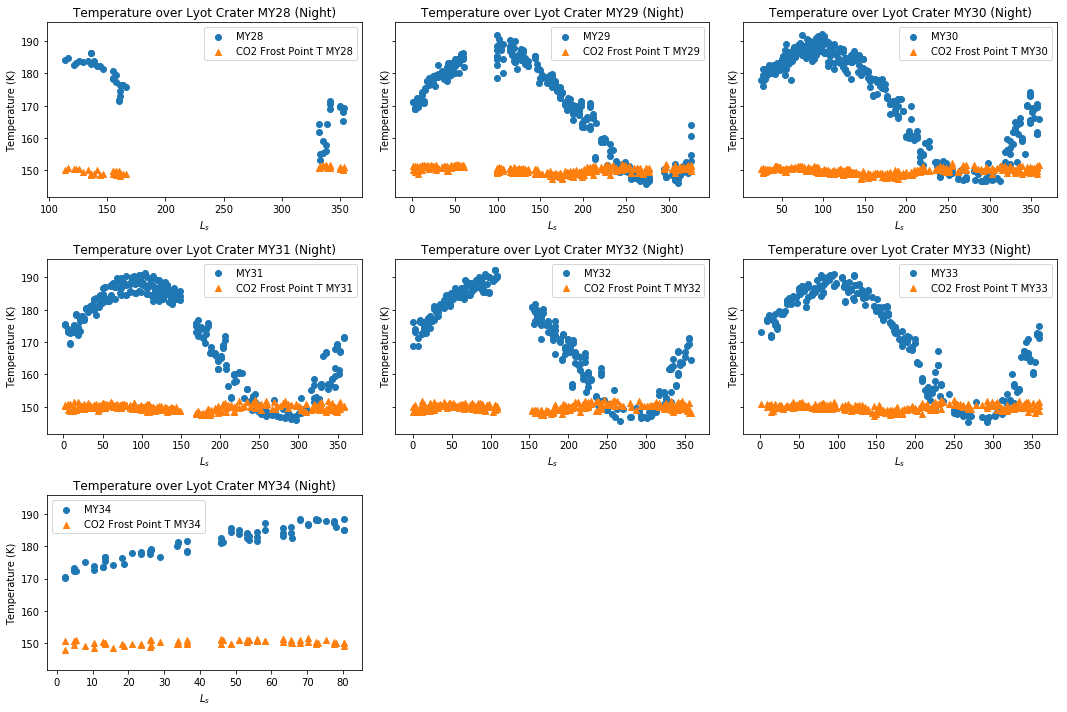

In [24]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Lyot_SubframesNightMY28['L_s'], Lyot_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Lyot_CO2night28['L_s'],Lyot_CO2night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Lyot_SubframesNightMY29['L_s'], Lyot_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Lyot_CO2night29['L_s'],Lyot_CO2night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Lyot_SubframesNightMY30['L_s'], Lyot_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Lyot_CO2night30['L_s'],Lyot_CO2night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Lyot_SubframesNightMY31['L_s'], Lyot_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Lyot_CO2night31['L_s'],Lyot_CO2night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Lyot_SubframesNightMY32['L_s'], Lyot_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Lyot_CO2night32['L_s'],Lyot_CO2night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Lyot_SubframesNightMY33['L_s'], Lyot_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Lyot_CO2night33['L_s'],Lyot_CO2night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Lyot_SubframesNightMY34['L_s'], Lyot_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Lyot_CO2night34['L_s'],Lyot_CO2night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [25]:
Lyot_SubframesDay = pd.concat([Lyot_SubframesDayMY28,
                              Lyot_SubframesDayMY29,
                              Lyot_SubframesDayMY30,
                              Lyot_SubframesDayMY31,
                              Lyot_SubframesDayMY32,
                              Lyot_SubframesDayMY33,
                              Lyot_SubframesDayMY34])

In [26]:
Lyot_SubframesNight = pd.concat([Lyot_SubframesNightMY28,
                              Lyot_SubframesNightMY29,
                              Lyot_SubframesNightMY30,
                              Lyot_SubframesNightMY31,
                              Lyot_SubframesNightMY32,
                              Lyot_SubframesNightMY33,
                              Lyot_SubframesNightMY34])

In [27]:
Lyot_SubframesDay = Lyot_SubframesDay.drop([' ','UTC'], axis=1)
Lyot_SubframesDay.to_csv('Lyot Crater MCS Data Day', sep=' ')

In [28]:
Lyot_SubframesNight = Lyot_SubframesNight.drop([' ','UTC'], axis=1)
Lyot_SubframesNight.to_csv('Lyot Crater MCS Data Night', sep=' ')

In [29]:
F9 = square(64.625, 135.937, size=4, type = 'deg')

In [30]:
F9_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

F9_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

F9_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

F9_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

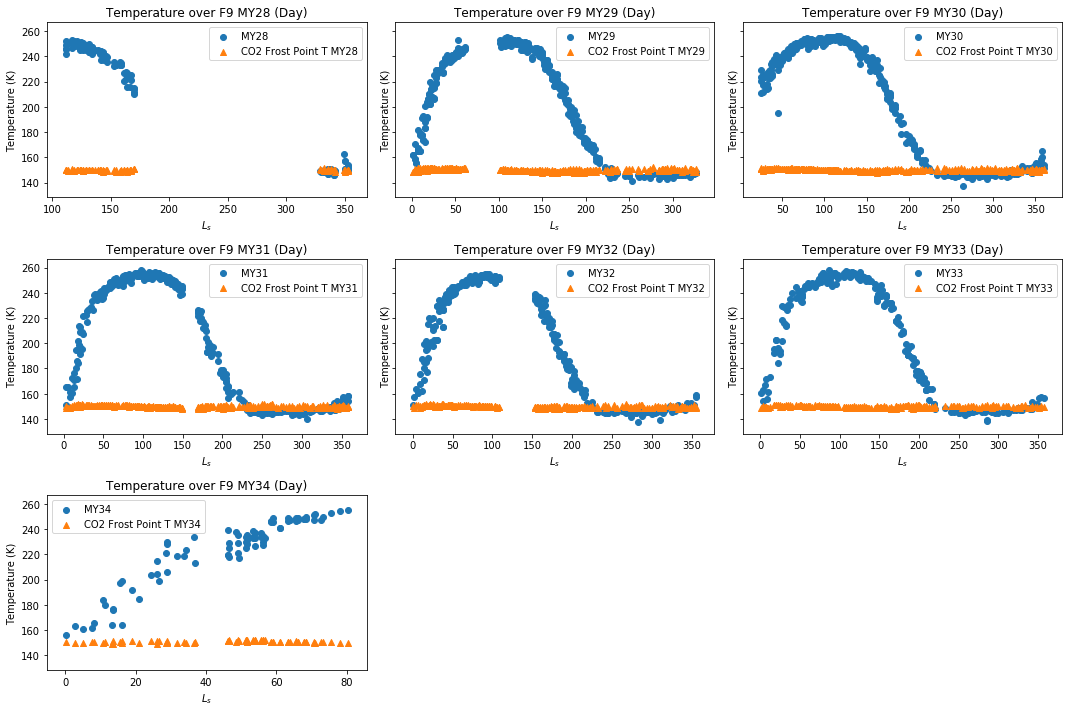

In [31]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(F9_SubframesDayMY28['L_s'],F9_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(F9_CO2day28['L_s'],F9_CO2day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(F9_SubframesDayMY29['L_s'],F9_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(F9_CO2day29['L_s'],F9_CO2day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(F9_SubframesDayMY30['L_s'],F9_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(F9_CO2day30['L_s'],F9_CO2day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(F9_SubframesDayMY31['L_s'],F9_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(F9_CO2day31['L_s'],F9_CO2day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(F9_SubframesDayMY32['L_s'],F9_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(F9_CO2day32['L_s'],F9_CO2day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(F9_SubframesDayMY33['L_s'],F9_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(F9_CO2day33['L_s'],F9_CO2day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(F9_SubframesDayMY34['L_s'],F9_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(F9_CO2day34['L_s'],F9_CO2day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

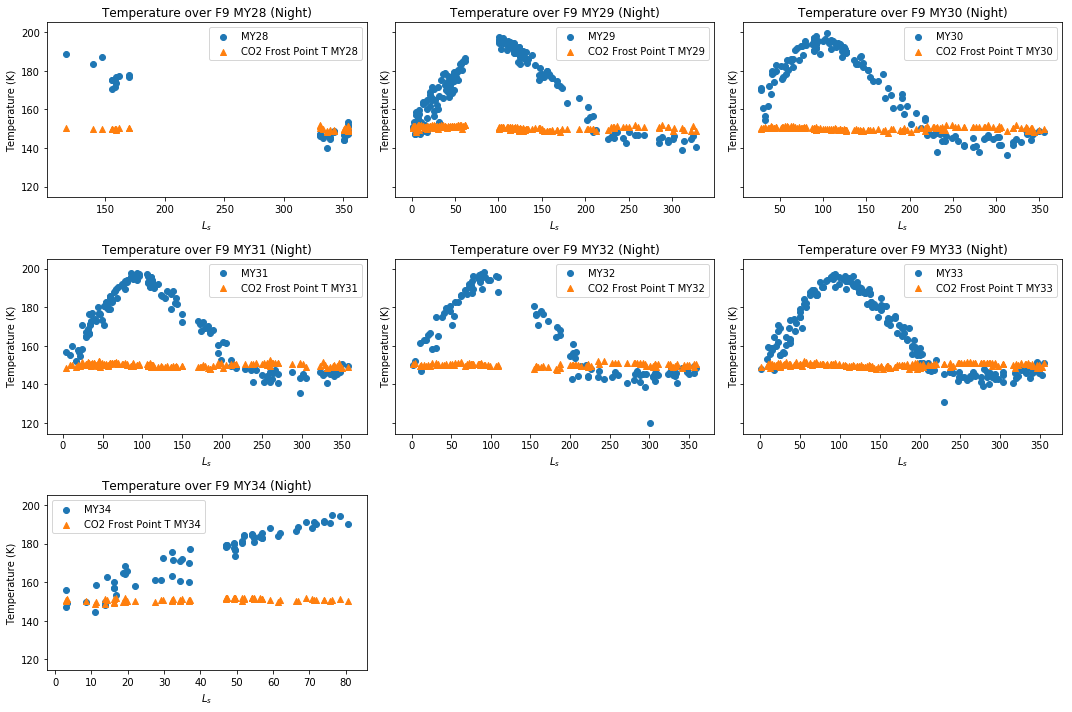

In [32]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(F9_SubframesNightMY28['L_s'],F9_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(F9_CO2night28['L_s'],F9_CO2night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(F9_SubframesNightMY29['L_s'],F9_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(F9_CO2night29['L_s'],F9_CO2night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(F9_SubframesNightMY30['L_s'],F9_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(F9_CO2night30['L_s'],F9_CO2night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(F9_SubframesNightMY31['L_s'],F9_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(F9_CO2night31['L_s'],F9_CO2night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(F9_SubframesNightMY32['L_s'],F9_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(F9_CO2night32['L_s'],F9_CO2night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(F9_SubframesNightMY33['L_s'],F9_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(F9_CO2night33['L_s'],F9_CO2night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(F9_SubframesNightMY34['L_s'],F9_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(F9_CO2night34['L_s'],F9_CO2night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [33]:
F9_SubframesDay = pd.concat([F9_SubframesDayMY28,
                              F9_SubframesDayMY29,
                              F9_SubframesDayMY30,
                              F9_SubframesDayMY31,
                              F9_SubframesDayMY32,
                              F9_SubframesDayMY33,
                              F9_SubframesDayMY34])

In [34]:
F9_SubframesNight = pd.concat([F9_SubframesNightMY28,
                              F9_SubframesNightMY29,
                              F9_SubframesNightMY30,
                              F9_SubframesNightMY31,
                              F9_SubframesNightMY32,
                              F9_SubframesNightMY33,
                              F9_SubframesNightMY34])

In [35]:
F9_SubframesDay = F9_SubframesDay.drop([' ','UTC'], axis=1)
F9_SubframesDay.to_csv('F9 MCS Data Day', sep=' ')

In [36]:
F9_SubframesNight = F9_SubframesNight.drop([' ','UTC'], axis=1)
F9_SubframesNight.to_csv('F9 MCS Data Night', sep=' ')

In [37]:
NML010 = square(41.74161, -135.6006, size=4, type = 'deg')

In [38]:
NML010_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

NML010_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

NML010_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

NML010_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

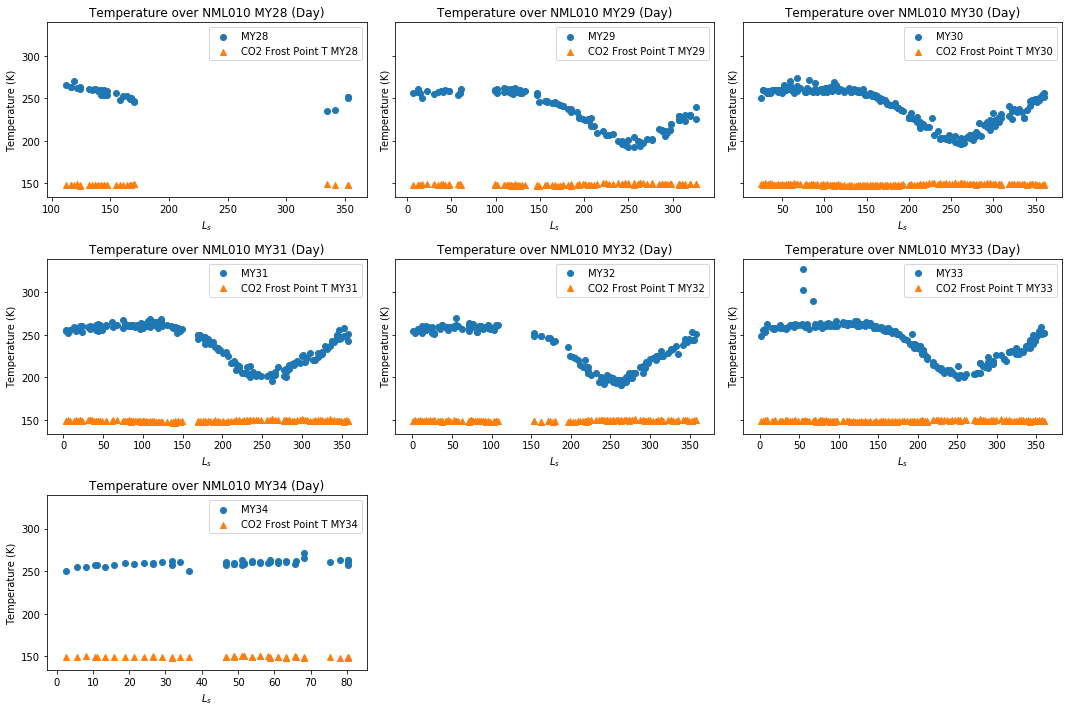

In [39]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML010_SubframesDayMY28['L_s'],NML010_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML010_CO2day28['L_s'],NML010_CO2day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML010_SubframesDayMY29['L_s'],NML010_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML010_CO2day29['L_s'],NML010_CO2day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML010_SubframesDayMY30['L_s'],NML010_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML010_CO2day30['L_s'],NML010_CO2day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML010_SubframesDayMY31['L_s'],NML010_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML010_CO2day31['L_s'],NML010_CO2day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML010_SubframesDayMY32['L_s'],NML010_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML010_CO2day32['L_s'],NML010_CO2day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML010_SubframesDayMY33['L_s'],NML010_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML010_CO2day33['L_s'],NML010_CO2day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML010_SubframesDayMY34['L_s'],NML010_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML010_CO2day34['L_s'],NML010_CO2day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

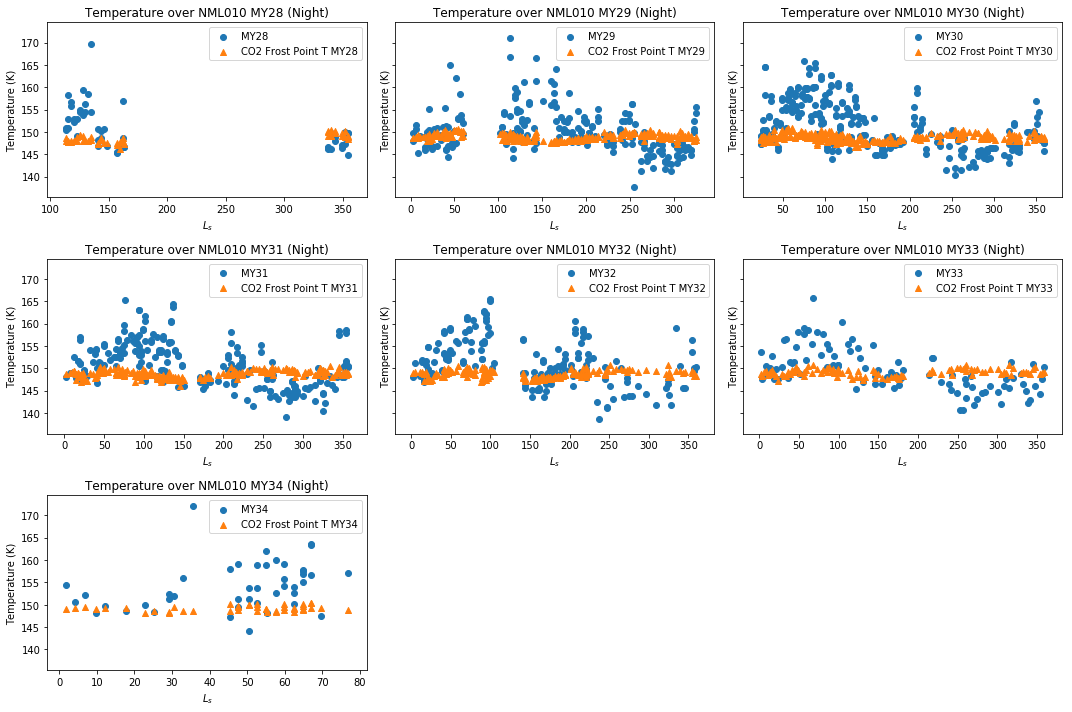

In [40]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML010_SubframesNightMY28['L_s'],NML010_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML010_CO2night28['L_s'],NML010_CO2night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML010_SubframesNightMY29['L_s'],NML010_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML010_CO2night29['L_s'],NML010_CO2night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML010_SubframesNightMY30['L_s'],NML010_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML010_CO2night30['L_s'],NML010_CO2night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML010_SubframesNightMY31['L_s'],NML010_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML010_CO2night31['L_s'],NML010_CO2night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML010_SubframesNightMY32['L_s'],NML010_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML010_CO2night32['L_s'],NML010_CO2night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML010_SubframesNightMY33['L_s'],NML010_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML010_CO2night33['L_s'],NML010_CO2night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML010_SubframesNightMY34['L_s'],NML010_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML010_CO2night34['L_s'],NML010_CO2night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [41]:
NML010_SubframesDay = pd.concat([NML010_SubframesDayMY28,
                              NML010_SubframesDayMY29,
                              NML010_SubframesDayMY30,
                              NML010_SubframesDayMY31,
                              NML010_SubframesDayMY32,
                              NML010_SubframesDayMY33,
                              NML010_SubframesDayMY34])

In [42]:
NML010_SubframesNight = pd.concat([NML010_SubframesNightMY28,
                              NML010_SubframesNightMY29,
                              NML010_SubframesNightMY30,
                              NML010_SubframesNightMY31,
                              NML010_SubframesNightMY32,
                              NML010_SubframesNightMY33,
                              NML010_SubframesNightMY34])

In [43]:
NML010_SubframesDay = NML010_SubframesDay.drop([' ','UTC'], axis=1)
NML010_SubframesDay.to_csv('NML010 MCS Data Day', sep=' ')

In [44]:
NML010_SubframesNight = NML010_SubframesNight.drop([' ','UTC'], axis=1)
NML010_SubframesNight.to_csv('NML010 MCS Data Night', sep=' ')

In [45]:
NML043 = square(63.75526, 112.1203, size=4, type = 'deg')

In [46]:
NML043_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

NML043_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

NML043_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

NML043_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

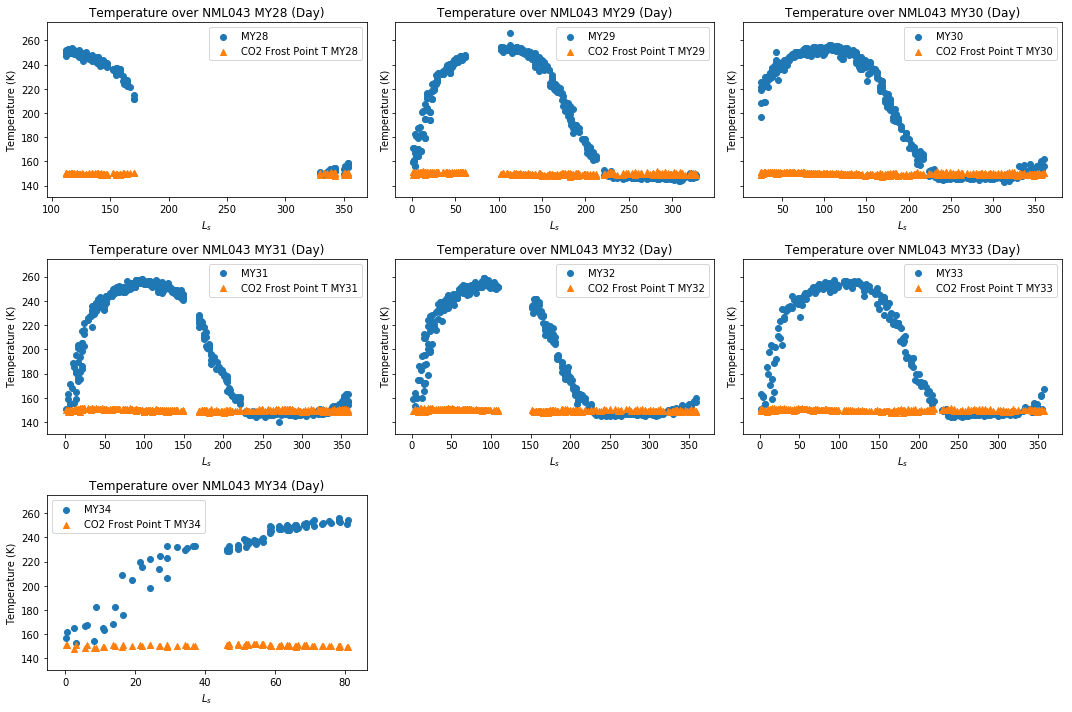

In [47]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML043_SubframesDayMY28['L_s'],NML043_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML043_CO2day28['L_s'],NML043_CO2day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML043_SubframesDayMY29['L_s'],NML043_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML043_CO2day29['L_s'],NML043_CO2day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML043_SubframesDayMY30['L_s'],NML043_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML043_CO2day30['L_s'],NML043_CO2day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML043_SubframesDayMY31['L_s'],NML043_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML043_CO2day31['L_s'],NML043_CO2day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML043_SubframesDayMY32['L_s'],NML043_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML043_CO2day32['L_s'],NML043_CO2day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML043_SubframesDayMY33['L_s'],NML043_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML043_CO2day33['L_s'],NML043_CO2day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML043_SubframesDayMY34['L_s'],NML043_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML043_CO2day34['L_s'],NML043_CO2day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

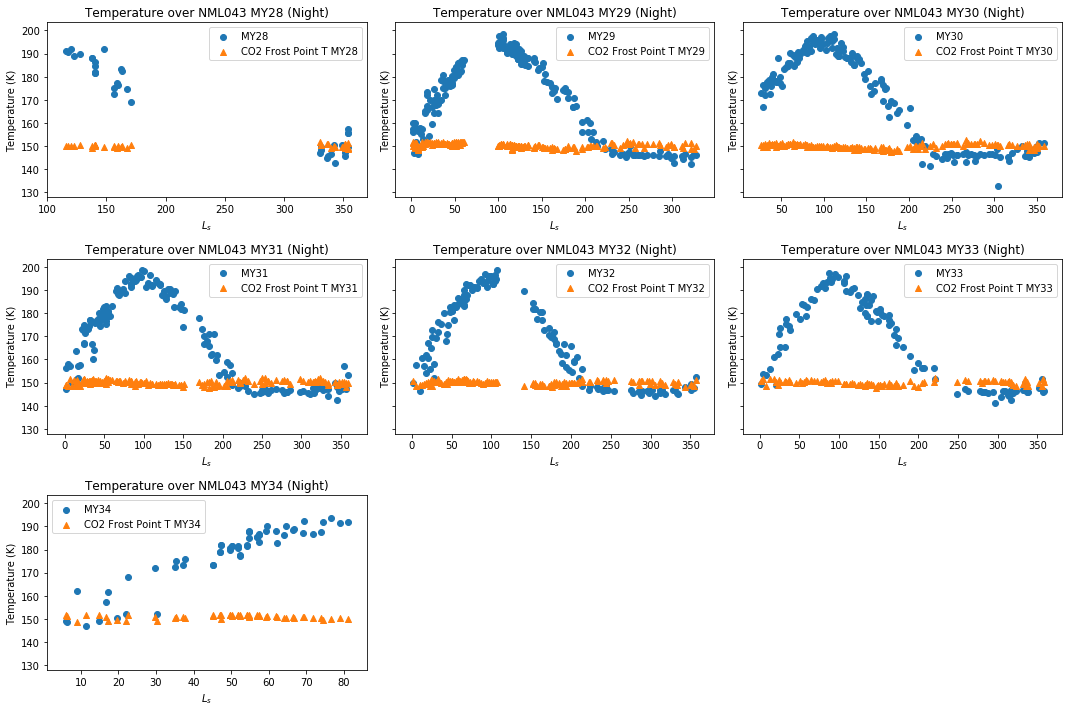

In [48]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML043_SubframesNightMY28['L_s'],NML043_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML043_CO2night28['L_s'],NML043_CO2night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML043_SubframesNightMY29['L_s'],NML043_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML043_CO2night29['L_s'],NML043_CO2night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML043_SubframesNightMY30['L_s'],NML043_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML043_CO2night30['L_s'],NML043_CO2night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML043_SubframesNightMY31['L_s'],NML043_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML043_CO2night31['L_s'],NML043_CO2night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML043_SubframesNightMY32['L_s'],NML043_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML043_CO2night32['L_s'],NML043_CO2night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML043_SubframesNightMY33['L_s'],NML043_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML043_CO2night33['L_s'],NML043_CO2night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML043_SubframesNightMY34['L_s'],NML043_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML043_CO2night34['L_s'],NML043_CO2night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [49]:
NML043_SubframesDay = pd.concat([NML043_SubframesDayMY28,
                              NML043_SubframesDayMY29,
                              NML043_SubframesDayMY30,
                              NML043_SubframesDayMY31,
                              NML043_SubframesDayMY32,
                              NML043_SubframesDayMY33,
                              NML043_SubframesDayMY34])

In [50]:
NML043_SubframesNight = pd.concat([NML043_SubframesNightMY28,
                              NML043_SubframesNightMY29,
                              NML043_SubframesNightMY30,
                              NML043_SubframesNightMY31,
                              NML043_SubframesNightMY32,
                              NML043_SubframesNightMY33,
                              NML043_SubframesNightMY34])

In [51]:
NML043_SubframesDay = NML043_SubframesDay.drop([' ','UTC'], axis=1)
NML043_SubframesDay.to_csv('NML043 MCS Data Day', sep=' ')

In [52]:
NML043_SubframesNight = NML043_SubframesNight.drop([' ','UTC'], axis=1)
NML043_SubframesNight.to_csv('NML043 MCS Data Night', sep=' ')

In [53]:
NML047 = square(54.46798, 33.5177, size=4, type = 'deg')

In [54]:
NML047_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

NML047_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

NML047_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

NML047_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

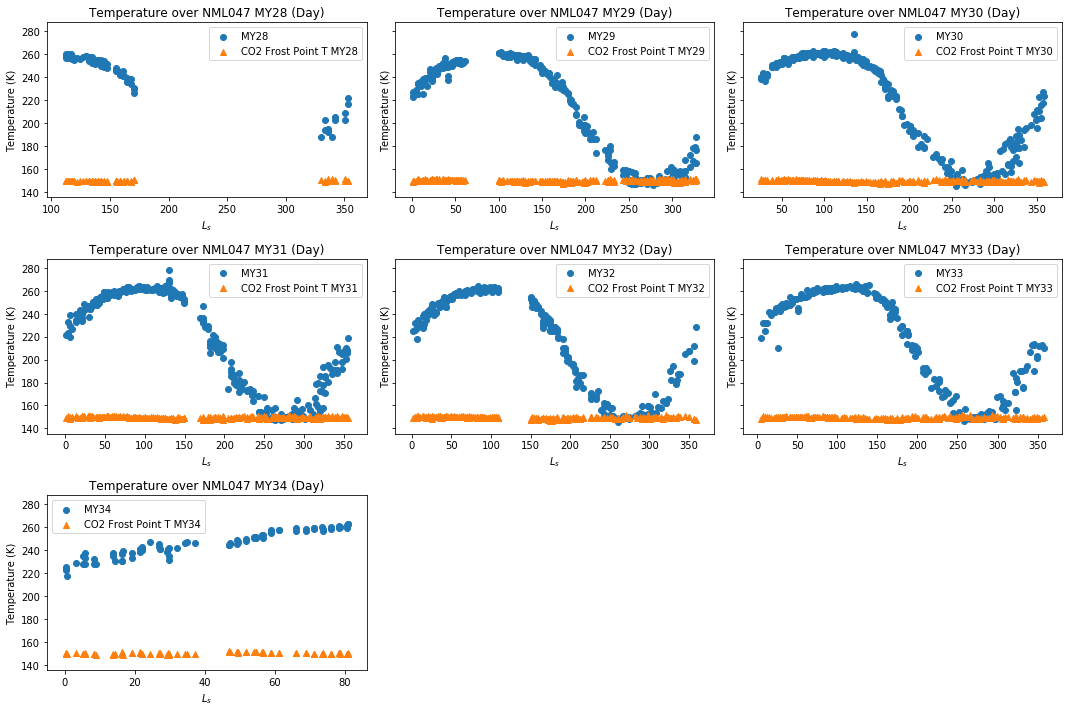

In [55]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML047_SubframesDayMY28['L_s'],NML047_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML047_CO2day28['L_s'],NML047_CO2day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML047_SubframesDayMY29['L_s'],NML047_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML047_CO2day29['L_s'],NML047_CO2day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML047_SubframesDayMY30['L_s'],NML047_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML047_CO2day30['L_s'],NML047_CO2day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML047_SubframesDayMY31['L_s'],NML047_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML047_CO2day31['L_s'],NML047_CO2day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML047_SubframesDayMY32['L_s'],NML047_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML047_CO2day32['L_s'],NML047_CO2day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML047_SubframesDayMY33['L_s'],NML047_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML047_CO2day33['L_s'],NML047_CO2day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML047_SubframesDayMY34['L_s'],NML047_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML047_CO2day34['L_s'],NML047_CO2day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

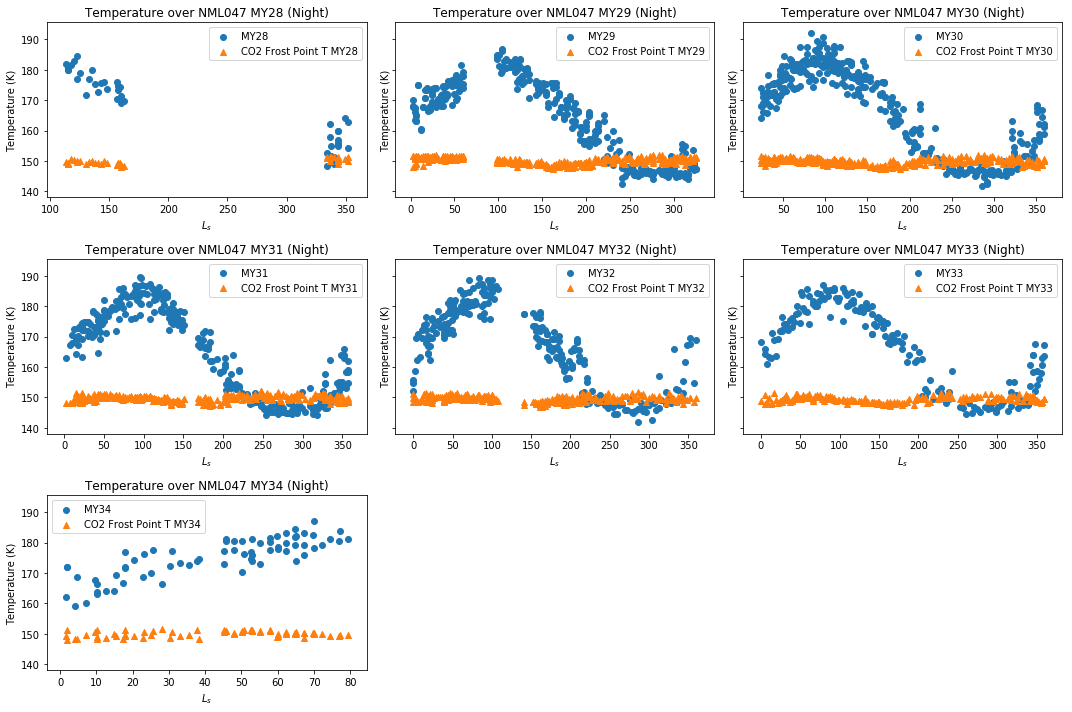

In [56]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML047_SubframesNightMY28['L_s'],NML047_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML047_CO2night28['L_s'],NML047_CO2night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML047_SubframesNightMY29['L_s'],NML047_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML047_CO2night29['L_s'],NML047_CO2night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML047_SubframesNightMY30['L_s'],NML047_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML047_CO2night30['L_s'],NML047_CO2night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML047_SubframesNightMY31['L_s'],NML047_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML047_CO2night31['L_s'],NML047_CO2night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML047_SubframesNightMY32['L_s'],NML047_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML047_CO2night32['L_s'],NML047_CO2night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML047_SubframesNightMY33['L_s'],NML047_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML047_CO2night33['L_s'],NML047_CO2night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML047_SubframesNightMY34['L_s'],NML047_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML047_CO2night34['L_s'],NML047_CO2night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [57]:
NML047_SubframesDay = pd.concat([NML047_SubframesDayMY28,
                              NML047_SubframesDayMY29,
                              NML047_SubframesDayMY30,
                              NML047_SubframesDayMY31,
                              NML047_SubframesDayMY32,
                              NML047_SubframesDayMY33,
                              NML047_SubframesDayMY34])

In [58]:
NML047_SubframesNight = pd.concat([NML047_SubframesNightMY28,
                              NML047_SubframesNightMY29,
                              NML047_SubframesNightMY30,
                              NML047_SubframesNightMY31,
                              NML047_SubframesNightMY32,
                              NML047_SubframesNightMY33,
                              NML047_SubframesNightMY34])

In [59]:
NML047_SubframesDay = NML047_SubframesDay.drop([' ','UTC'], axis=1)
NML047_SubframesDay.to_csv('NML047 MCS Data Day', sep=' ')

In [60]:
NML047_SubframesNight = NML047_SubframesNight.drop([' ','UTC'], axis=1)
NML047_SubframesNight.to_csv('NML047 MCS Data Night', sep=' ')

In [61]:
NML086 = square(58.25693, -90.35472, size=4, type = 'deg')

In [62]:
NML086_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

NML086_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

NML086_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

NML086_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

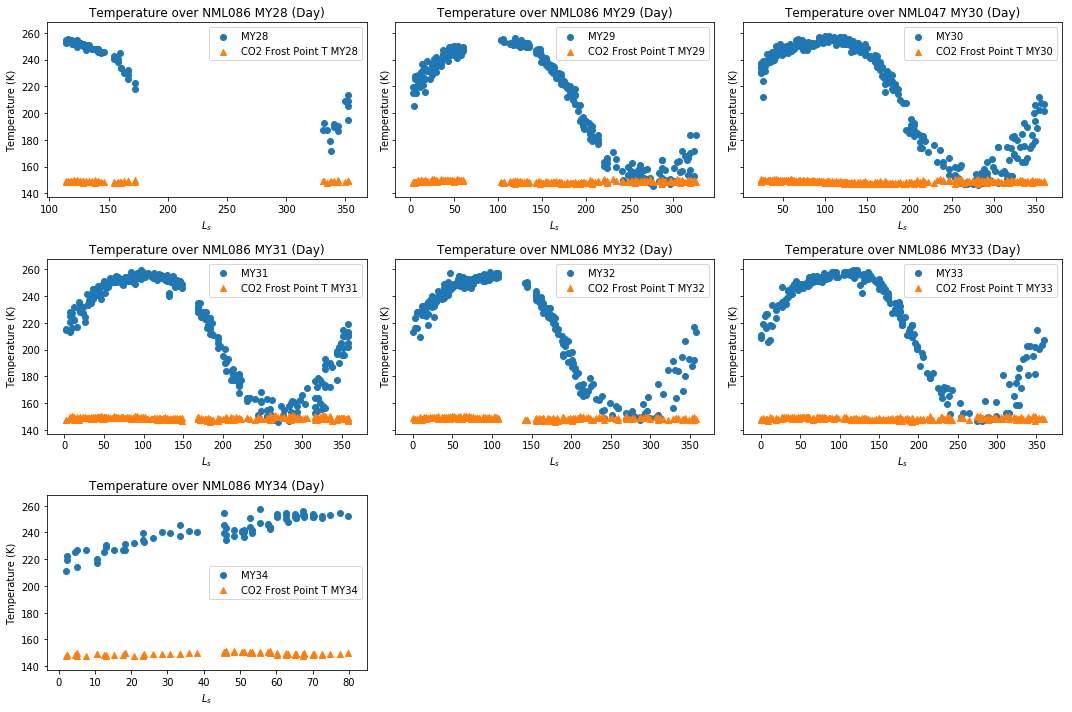

In [63]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML086_SubframesDayMY28['L_s'],NML086_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML086_CO2day28['L_s'],NML086_CO2day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML086_SubframesDayMY29['L_s'],NML086_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML086_CO2day29['L_s'],NML086_CO2day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML086_SubframesDayMY30['L_s'],NML086_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML086_CO2day30['L_s'],NML086_CO2day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML086_SubframesDayMY31['L_s'],NML086_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML086_CO2day31['L_s'],NML086_CO2day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML086_SubframesDayMY32['L_s'],NML086_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML086_CO2day32['L_s'],NML086_CO2day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML086_SubframesDayMY33['L_s'],NML086_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML086_CO2day33['L_s'],NML086_CO2day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML086_SubframesDayMY34['L_s'],NML086_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML086_CO2day34['L_s'],NML086_CO2day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

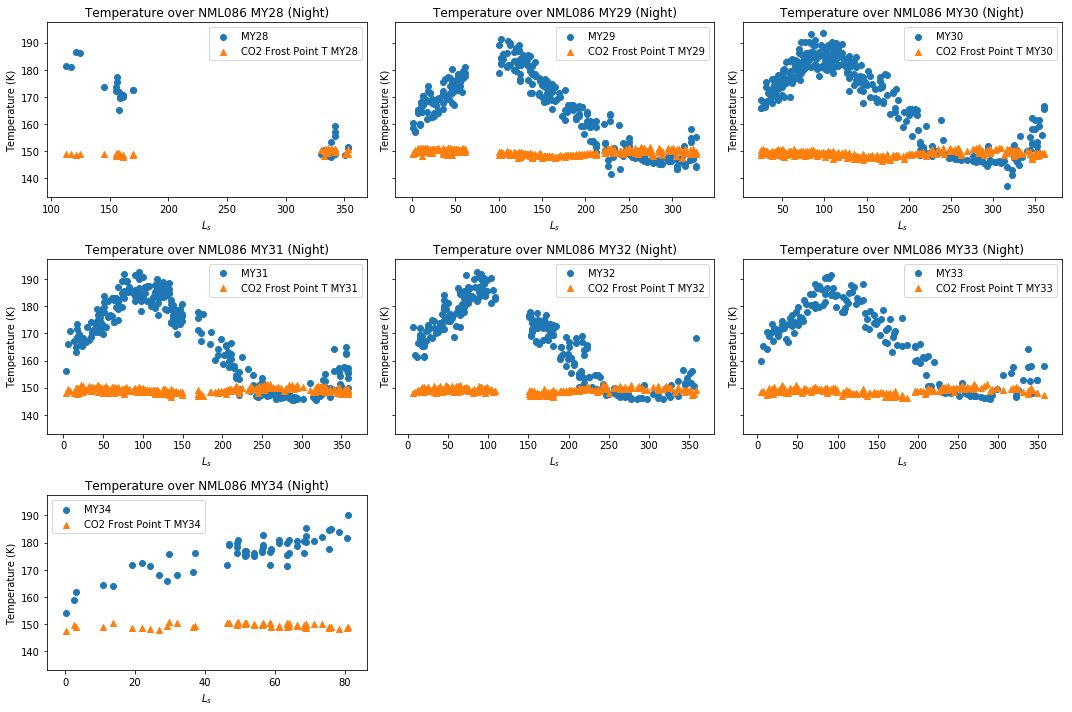

In [64]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML086_SubframesNightMY28['L_s'],NML086_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML086_CO2night28['L_s'],NML086_CO2night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML086_SubframesNightMY29['L_s'],NML086_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML086_CO2night29['L_s'],NML086_CO2night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML086_SubframesNightMY30['L_s'],NML086_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML086_CO2night30['L_s'],NML086_CO2night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML086_SubframesNightMY31['L_s'],NML086_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML086_CO2night31['L_s'],NML086_CO2night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML086_SubframesNightMY32['L_s'],NML086_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML086_CO2night32['L_s'],NML086_CO2night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML086_SubframesNightMY33['L_s'],NML086_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML086_CO2night33['L_s'],NML086_CO2night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML086_SubframesNightMY34['L_s'],NML086_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML086_CO2night34['L_s'],NML086_CO2night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [65]:
NML086_SubframesDay = pd.concat([NML086_SubframesDayMY28,
                              NML086_SubframesDayMY29,
                              NML086_SubframesDayMY30,
                              NML086_SubframesDayMY31,
                              NML086_SubframesDayMY32,
                              NML086_SubframesDayMY33,
                              NML086_SubframesDayMY34])

In [66]:
NML086_SubframesNight = pd.concat([NML086_SubframesNightMY28,
                              NML086_SubframesNightMY29,
                              NML086_SubframesNightMY30,
                              NML086_SubframesNightMY31,
                              NML086_SubframesNightMY32,
                              NML086_SubframesNightMY33,
                              NML086_SubframesNightMY34])

In [67]:
NML086_SubframesDay = NML086_SubframesDay.drop([' ','UTC'], axis=1)
NML086_SubframesDay.to_csv('NML086 MCS Data Day', sep=' ')

In [68]:
NML086_SubframesNight = NML086_SubframesNight.drop([' ','UTC'], axis=1)
NML086_SubframesNight.to_csv('NML086 MCS Data Night', sep=' ')

In [69]:
Buzzel = square(84.0, 53.2, size=2, type = 'deg')

In [70]:
Buzzel_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

In [71]:
BuzzelFFDayMY29 = Buzzel_SubframesDayMY29[(Buzzel_SubframesDayMY29['L_s'] >= 175) & (Buzzel_SubframesDayMY29['L_s']<=210)]
BuzzelFFDayMY30 = Buzzel_SubframesDayMY30[(Buzzel_SubframesDayMY30['L_s'] >= 175) & (Buzzel_SubframesDayMY30['L_s']<=210)]
BuzzelFFDayMY31 = Buzzel_SubframesDayMY31[(Buzzel_SubframesDayMY31['L_s'] >= 175) & (Buzzel_SubframesDayMY31['L_s']<=210)]
BuzzelFFDayMY32 = Buzzel_SubframesDayMY32[(Buzzel_SubframesDayMY32['L_s'] >= 175) & (Buzzel_SubframesDayMY32['L_s']<=210)]
BuzzelFFDayMY33 = Buzzel_SubframesDayMY33[(Buzzel_SubframesDayMY33['L_s'] >= 175) & (Buzzel_SubframesDayMY33['L_s']<=210)]

BuzzelFFNightMY29 = Buzzel_SubframesNightMY29[(Buzzel_SubframesNightMY29['L_s'] >= 175) & (Buzzel_SubframesNightMY29['L_s']<=210)]
BuzzelFFNightMY30 = Buzzel_SubframesNightMY30[(Buzzel_SubframesNightMY30['L_s'] >= 175) & (Buzzel_SubframesNightMY30['L_s']<=210)]
BuzzelFFNightMY31 = Buzzel_SubframesNightMY31[(Buzzel_SubframesNightMY31['L_s'] >= 175) & (Buzzel_SubframesNightMY31['L_s']<=210)]
BuzzelFFNightMY32 = Buzzel_SubframesNightMY32[(Buzzel_SubframesNightMY32['L_s'] >= 175) & (Buzzel_SubframesNightMY32['L_s']<=210)]
BuzzelFFNightMY33 = Buzzel_SubframesNightMY33[(Buzzel_SubframesNightMY33['L_s'] >= 175) & (Buzzel_SubframesNightMY33['L_s']<=210)]

In [72]:
BuzzelFFDNetT29 = BuzzelFFDayMY29['T_surf'] - BuzzelFFDayMY29['Frost_T']
BuzzelFFDNetT30 = BuzzelFFDayMY30['T_surf'] - BuzzelFFDayMY30['Frost_T']
BuzzelFFDNetT31 = BuzzelFFDayMY31['T_surf'] - BuzzelFFDayMY31['Frost_T']
BuzzelFFDNetT32 = BuzzelFFDayMY32['T_surf'] - BuzzelFFDayMY32['Frost_T']
BuzzelFFDNetT33 = BuzzelFFDayMY33['T_surf'] - BuzzelFFDayMY33['Frost_T']

BuzzelFFNNetT29 = BuzzelFFNightMY29['T_surf'] - BuzzelFFNightMY29['Frost_T']
BuzzelFFNNetT30 = BuzzelFFNightMY30['T_surf'] - BuzzelFFNightMY30['Frost_T']
BuzzelFFNNetT31 = BuzzelFFNightMY31['T_surf'] - BuzzelFFNightMY31['Frost_T']
BuzzelFFNNetT32 = BuzzelFFNightMY32['T_surf'] - BuzzelFFNightMY32['Frost_T']
BuzzelFFNNetT33 = BuzzelFFNightMY33['T_surf'] - BuzzelFFNightMY33['Frost_T']

LsBD29= np.linspace(175,210,len(BuzzelFFDNetT29))
LsBD30= np.linspace(175,210,len(BuzzelFFDNetT30))
LsBD31= np.linspace(175,210,len(BuzzelFFDNetT31))
LsBD32= np.linspace(175,210,len(BuzzelFFDNetT32))
LsBD33= np.linspace(175,210,len(BuzzelFFDNetT33))

LsBN29= np.linspace(175,210,len(BuzzelFFNNetT29))
LsBN30= np.linspace(175,210,len(BuzzelFFNNetT30))
LsBN31= np.linspace(175,210,len(BuzzelFFNNetT31))
LsBN32= np.linspace(175,210,len(BuzzelFFNNetT32))
LsBN33= np.linspace(175,210,len(BuzzelFFNNetT33))

In [73]:
Buzzel_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

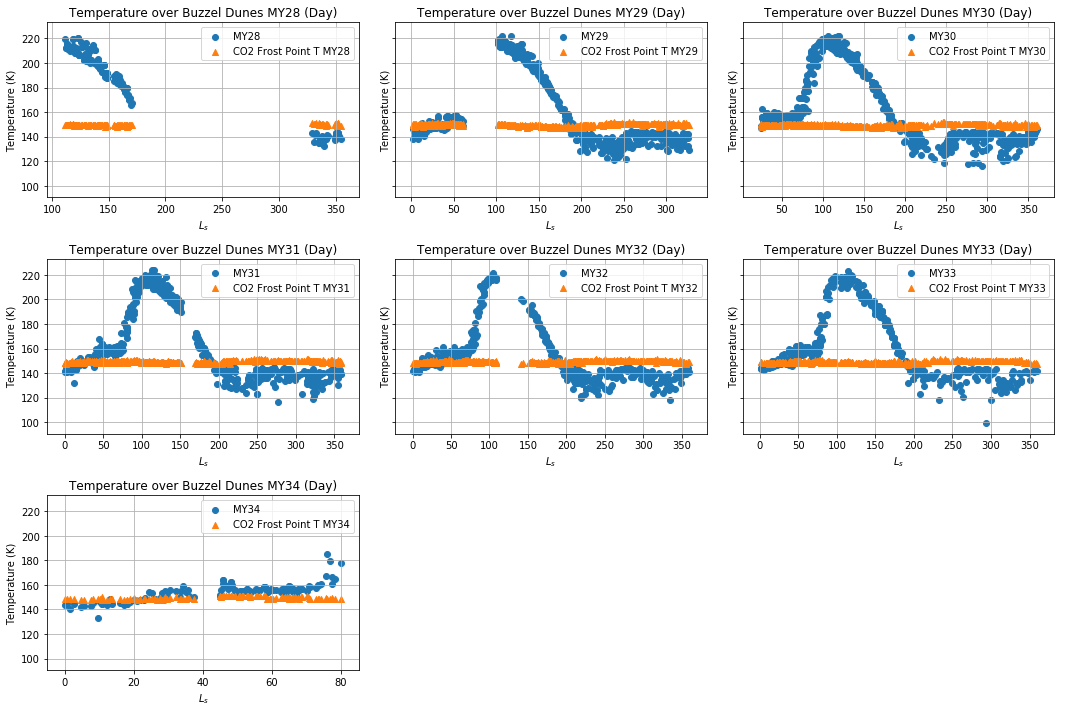

In [74]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesDayMY28['L_s'], Buzzel_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_CO2Day28['L_s'],Buzzel_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY28 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesDayMY29['L_s'], Buzzel_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_CO2Day29['L_s'],Buzzel_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY29 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesDayMY30['L_s'], Buzzel_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_CO2Day30['L_s'],Buzzel_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY30 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesDayMY31['L_s'], Buzzel_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_CO2Day31['L_s'],Buzzel_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY31 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesDayMY32['L_s'], Buzzel_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_CO2Day32['L_s'],Buzzel_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY32 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesDayMY33['L_s'], Buzzel_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_CO2Day33['L_s'],Buzzel_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY33 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesDayMY34['L_s'], Buzzel_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2Day34['L_s'],Buzzel_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY34 (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

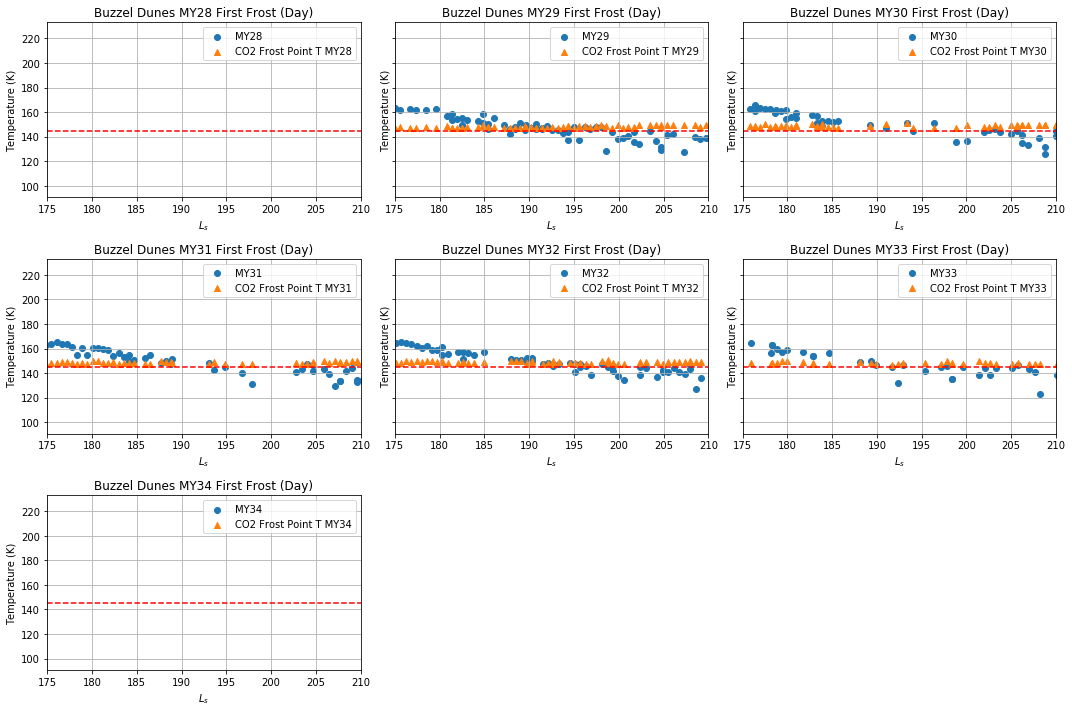

In [520]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesDayMY28['L_s'], Buzzel_SubframesDayMY28['T_surf'], label = 'MY28')
plt.axhline(145, color ='r', linestyle ='--')
plt.scatter(Buzzel_CO2Day28['L_s'],Buzzel_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY28 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesDayMY29['L_s'], Buzzel_SubframesDayMY29['T_surf'], label = 'MY29')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day29['L_s'],Buzzel_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY29 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesDayMY30['L_s'], Buzzel_SubframesDayMY30['T_surf'], label = 'MY30')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day30['L_s'],Buzzel_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY30 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesDayMY31['L_s'], Buzzel_SubframesDayMY31['T_surf'], label = 'MY31')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day31['L_s'],Buzzel_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY31 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesDayMY32['L_s'], Buzzel_SubframesDayMY32['T_surf'], label = 'MY32')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day32['L_s'],Buzzel_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY32 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesDayMY33['L_s'], Buzzel_SubframesDayMY33['T_surf'], label = 'MY33')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day33['L_s'],Buzzel_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY33 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesDayMY34['L_s'], Buzzel_SubframesDayMY34['T_surf'], label = 'MY34')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day34['L_s'],Buzzel_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY34 First Frost (Day)')
plt.xlim(175.0,210.0)
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

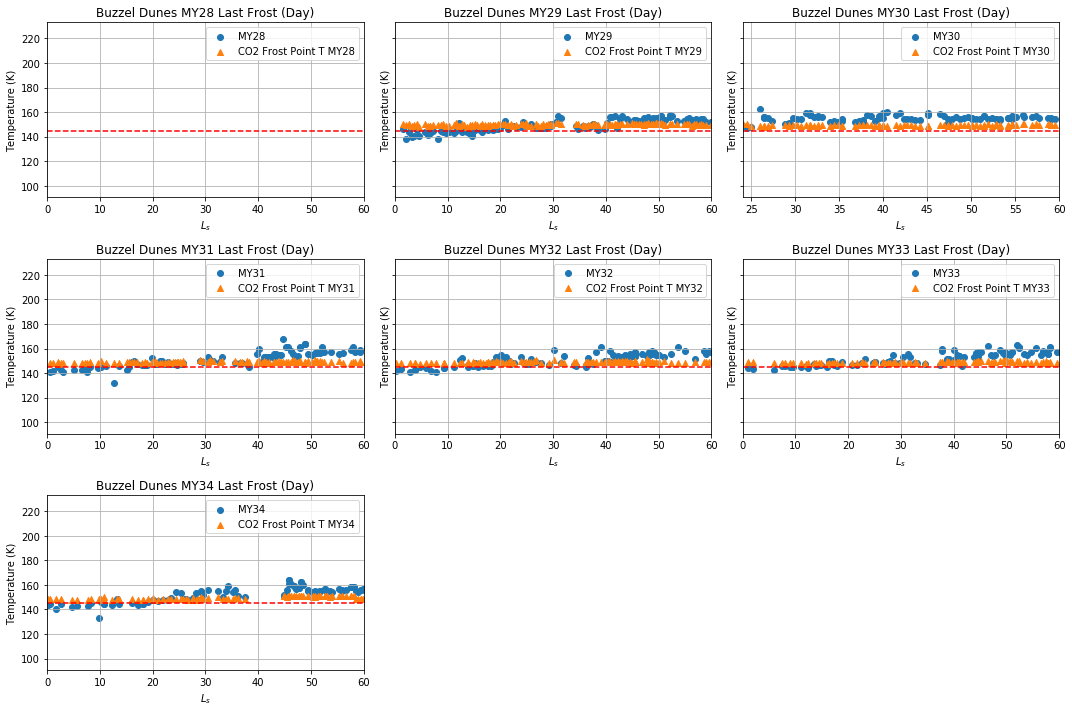

In [234]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesDayMY28['L_s'], Buzzel_SubframesDayMY28['T_surf'], label = 'MY28')
plt.axhline(145, color ='r', linestyle ='--')
plt.scatter(Buzzel_CO2Day28['L_s'],Buzzel_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY28 Last Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesDayMY29['L_s'], Buzzel_SubframesDayMY29['T_surf'], label = 'MY29')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day29['L_s'],Buzzel_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY29 Last Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesDayMY30['L_s'], Buzzel_SubframesDayMY30['T_surf'], label = 'MY30')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day30['L_s'],Buzzel_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY30 Last Frost (Day)')
plt.xlim(24.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesDayMY31['L_s'], Buzzel_SubframesDayMY31['T_surf'], label = 'MY31')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day31['L_s'],Buzzel_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY31 Last Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesDayMY32['L_s'], Buzzel_SubframesDayMY32['T_surf'], label = 'MY32')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day32['L_s'],Buzzel_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY32 Last Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesDayMY33['L_s'], Buzzel_SubframesDayMY33['T_surf'], label = 'MY33')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day33['L_s'],Buzzel_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY33 Last Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesDayMY34['L_s'], Buzzel_SubframesDayMY34['T_surf'], label = 'MY34')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Buzzel_CO2Day34['L_s'],Buzzel_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY34 Last Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

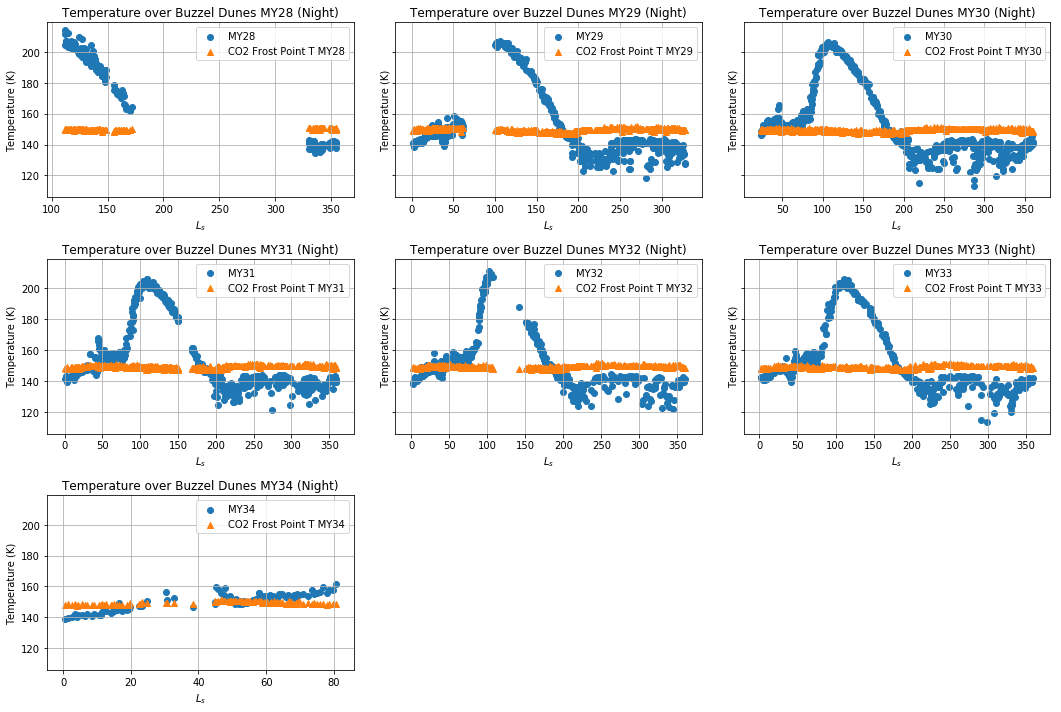

In [76]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesNightMY28['L_s'], Buzzel_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_CO2Night28['L_s'],Buzzel_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY28 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesNightMY29['L_s'], Buzzel_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_CO2Night29['L_s'],Buzzel_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY29 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesNightMY30['L_s'], Buzzel_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_CO2Night30['L_s'],Buzzel_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY30 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesNightMY31['L_s'], Buzzel_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_CO2Night31['L_s'],Buzzel_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY31 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesNightMY32['L_s'], Buzzel_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_CO2Night32['L_s'],Buzzel_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY32 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesNightMY33['L_s'], Buzzel_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_CO2Night33['L_s'],Buzzel_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY33 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesNightMY34['L_s'], Buzzel_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2Night34['L_s'],Buzzel_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY34 (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

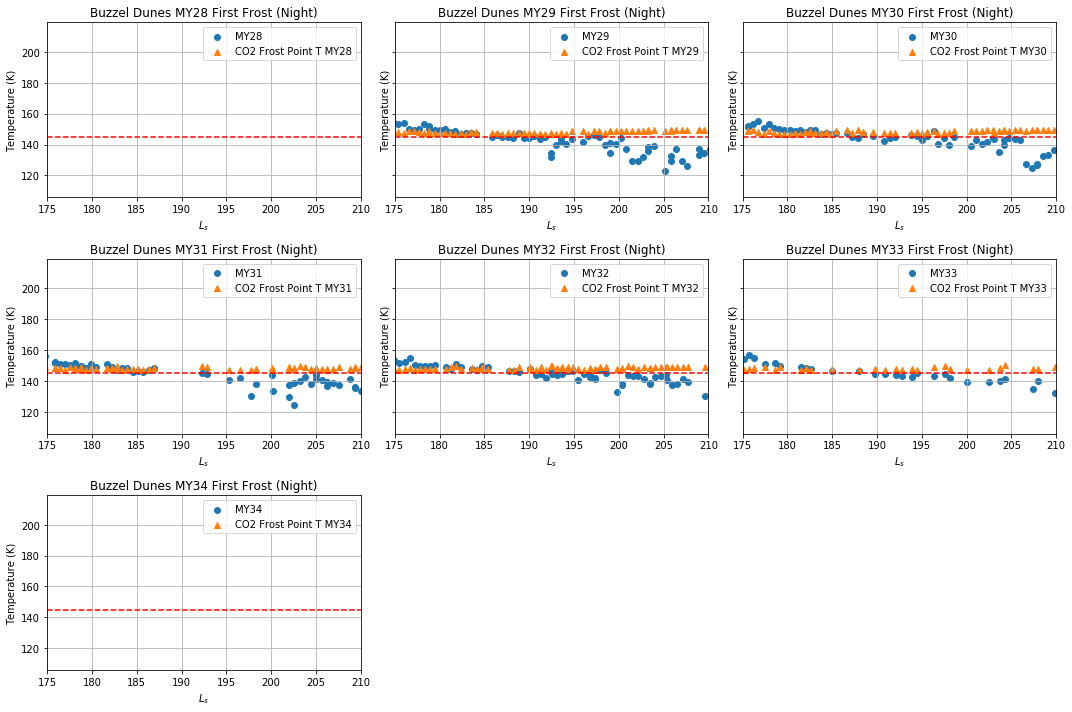

In [519]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesNightMY28['L_s'], Buzzel_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_CO2Night28['L_s'],Buzzel_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY28 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesNightMY29['L_s'], Buzzel_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_CO2Night29['L_s'],Buzzel_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY29 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesNightMY30['L_s'], Buzzel_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_CO2Night30['L_s'],Buzzel_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY30 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesNightMY31['L_s'], Buzzel_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_CO2Night31['L_s'],Buzzel_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY31 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesNightMY32['L_s'], Buzzel_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_CO2Night32['L_s'],Buzzel_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY32 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesNightMY33['L_s'], Buzzel_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_CO2Night33['L_s'],Buzzel_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY33 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesNightMY34['L_s'], Buzzel_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2Night34['L_s'],Buzzel_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY34 First Frost (Night)')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

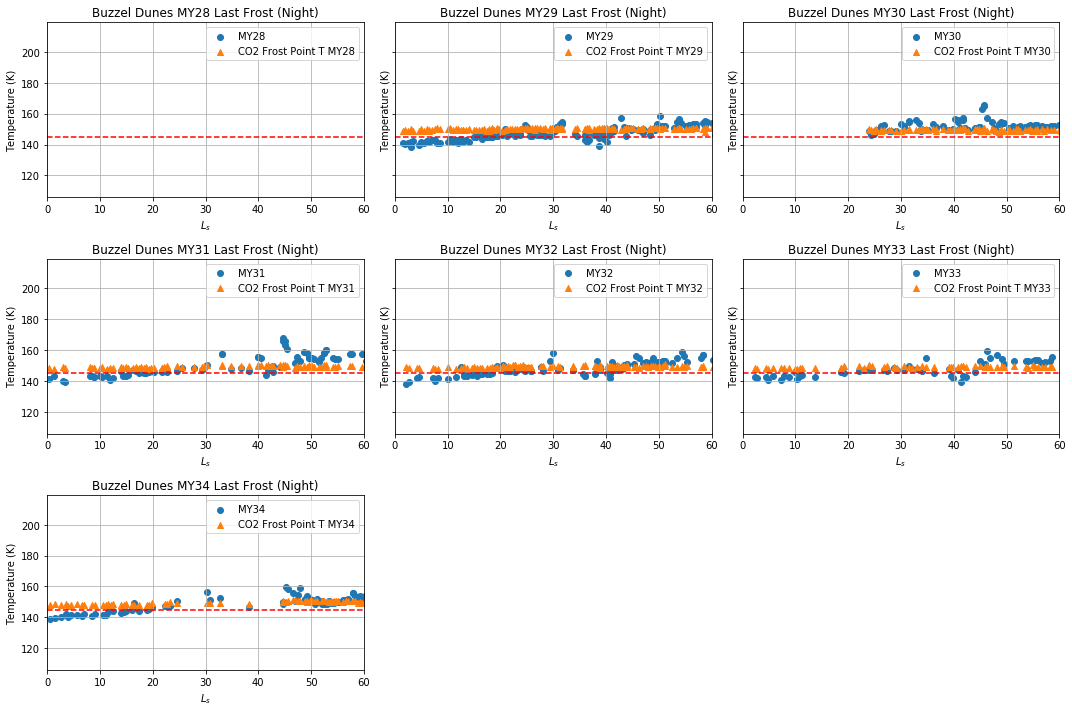

In [185]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesNightMY28['L_s'], Buzzel_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_CO2Night28['L_s'],Buzzel_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY28 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesNightMY29['L_s'], Buzzel_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_CO2Night29['L_s'],Buzzel_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY29 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesNightMY30['L_s'], Buzzel_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_CO2Night30['L_s'],Buzzel_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY30 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesNightMY31['L_s'], Buzzel_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_CO2Night31['L_s'],Buzzel_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY31 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesNightMY32['L_s'], Buzzel_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_CO2Night32['L_s'],Buzzel_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY32 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesNightMY33['L_s'], Buzzel_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_CO2Night33['L_s'],Buzzel_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY33 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesNightMY34['L_s'], Buzzel_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2Night34['L_s'],Buzzel_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Buzzel Dunes MY34 Last Frost (Night)')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [196]:
BuzzelFFDayMY29 = Buzzel_SubframesDayMY29[(Buzzel_SubframesDayMY29['L_s'] >= 175.0) & (Buzzel_SubframesDayMY29['L_s']<=210.0)]
BuzzelFFDayMY30 = Buzzel_SubframesDayMY30[(Buzzel_SubframesDayMY30['L_s'] >= 175.0) & (Buzzel_SubframesDayMY30['L_s']<=210.0)]
BuzzelFFDayMY31 = Buzzel_SubframesDayMY31[(Buzzel_SubframesDayMY31['L_s'] >= 175.0) & (Buzzel_SubframesDayMY31['L_s']<=210.0)]
BuzzelFFDayMY32 = Buzzel_SubframesDayMY32[(Buzzel_SubframesDayMY32['L_s'] >= 175.0) & (Buzzel_SubframesDayMY32['L_s']<=210.0)]
BuzzelFFDayMY33 = Buzzel_SubframesDayMY33[(Buzzel_SubframesDayMY33['L_s'] >= 175.0) & (Buzzel_SubframesDayMY33['L_s']<=210.0)]

BuzzelFFNightMY29 = Buzzel_SubframesNightMY29[(Buzzel_SubframesNightMY29['L_s'] >= 175.0) & (Buzzel_SubframesNightMY29['L_s']<=210.0)]
BuzzelFFNightMY30 = Buzzel_SubframesNightMY30[(Buzzel_SubframesNightMY30['L_s'] >= 175.0) & (Buzzel_SubframesNightMY30['L_s']<=210.0)]
BuzzelFFNightMY31 = Buzzel_SubframesNightMY31[(Buzzel_SubframesNightMY31['L_s'] >= 175.0) & (Buzzel_SubframesNightMY31['L_s']<=210.0)]
BuzzelFFNightMY32 = Buzzel_SubframesNightMY32[(Buzzel_SubframesNightMY32['L_s'] >= 175.0) & (Buzzel_SubframesNightMY32['L_s']<=210.0)]
BuzzelFFNightMY33 = Buzzel_SubframesNightMY33[(Buzzel_SubframesNightMY33['L_s'] >= 175.0) & (Buzzel_SubframesNightMY33['L_s']<=210.0)]

In [206]:
BuzzelFFDNetT29 = BuzzelFFDayMY29['T_surf'] - BuzzelFFDayMY29['Frost_T']
BuzzelFFDNetT30 = BuzzelFFDayMY30['T_surf'] - BuzzelFFDayMY30['Frost_T']
BuzzelFFDNetT31 = BuzzelFFDayMY31['T_surf'] - BuzzelFFDayMY31['Frost_T']
BuzzelFFDNetT32 = BuzzelFFDayMY32['T_surf'] - BuzzelFFDayMY32['Frost_T']
BuzzelFFDNetT33 = BuzzelFFDayMY33['T_surf'] - BuzzelFFDayMY33['Frost_T']

BuzzelFFNNetT29 = BuzzelFFNightMY29['T_surf'] - BuzzelFFNightMY29['Frost_T']
BuzzelFFNNetT30 = BuzzelFFNightMY30['T_surf'] - BuzzelFFNightMY30['Frost_T']
BuzzelFFNNetT31 = BuzzelFFNightMY31['T_surf'] - BuzzelFFNightMY31['Frost_T']
BuzzelFFNNetT32 = BuzzelFFNightMY32['T_surf'] - BuzzelFFNightMY32['Frost_T']
BuzzelFFNNetT33 = BuzzelFFNightMY33['T_surf'] - BuzzelFFNightMY33['Frost_T']

LsBFD29= np.linspace(175.0,210.0,len(BuzzelFFDNetT29))
LsBFD30= np.linspace(175.0,210.0,len(BuzzelFFDNetT30))
LsBFD31= np.linspace(175.0,210.0,len(BuzzelFFDNetT31))
LsBFD32= np.linspace(175.0,210.0,len(BuzzelFFDNetT32))
LsBFD33= np.linspace(175.0,210.0,len(BuzzelFFDNetT33))

LsBFN29= np.linspace(175.0,210.0,len(BuzzelFFNNetT29))
LsBFN30= np.linspace(175.0,210.0,len(BuzzelFFNNetT30))
LsBFN31= np.linspace(175.0,210.0,len(BuzzelFFNNetT31))
LsBFN32= np.linspace(175.0,210.0,len(BuzzelFFNNetT32))
LsBFN33= np.linspace(175.0,210.0,len(BuzzelFFNNetT33))

In [216]:
BFDcoe29, BFDcov29 =np.polyfit(LsBFD29,BuzzelFFDNetT29, 1, cov=True)
BFDcoe30, BFDcov30 =np.polyfit(LsBFD30,BuzzelFFDNetT30, 1, cov=True)
BFDcoe31, BFDcov31 =np.polyfit(LsBFD31,BuzzelFFDNetT31, 1, cov=True)
BFDcoe32, BFDcov32 =np.polyfit(LsBFD32,BuzzelFFDNetT32, 1, cov=True)
BFDcoe33, BFDcov33 =np.polyfit(LsBFD33,BuzzelFFDNetT33, 1, cov=True)

BFNcoe29, BFNcov29 =np.polyfit(LsBFN29,BuzzelFFNNetT29, 1, cov=True)
BFNcoe30, BFNcov30 =np.polyfit(LsBFN30,BuzzelFFNNetT30, 1, cov=True)
BFNcoe31, BFNcov31 =np.polyfit(LsBFN31,BuzzelFFNNetT31, 1, cov=True)
BFNcoe32, BFNcov32 =np.polyfit(LsBFN32,BuzzelFFNNetT32, 1, cov=True)
BFNcoe33, BFNcov33 =np.polyfit(LsBFN33,BuzzelFFNNetT33, 1, cov=True)

In [218]:
BFD29Err=xerr(BFDcoe29[0],BFDcoe29[1],BFDcov29)
BFD30Err=xerr(BFDcoe30[0],BFDcoe30[1],BFDcov30)
BFD31Err=xerr(BFDcoe31[0],BFDcoe31[1],BFDcov31)
BFD32Err=xerr(BFDcoe32[0],BFDcoe32[1],BFDcov32)
BFD33Err=xerr(BFDcoe33[0],BFDcoe33[1],BFDcov33)

BFN29Err=xerr(BFNcoe29[0],BFNcoe29[1],BFNcov29)
BFN30Err=xerr(BFNcoe30[0],BFNcoe30[1],BFNcov30)
BFN31Err=xerr(BFNcoe31[0],BFNcoe31[1],BFNcov31)
BFN32Err=xerr(BFNcoe32[0],BFNcoe32[1],BFNcov32)
BFN33Err=xerr(BFNcoe33[0],BFNcoe33[1],BFNcov33)

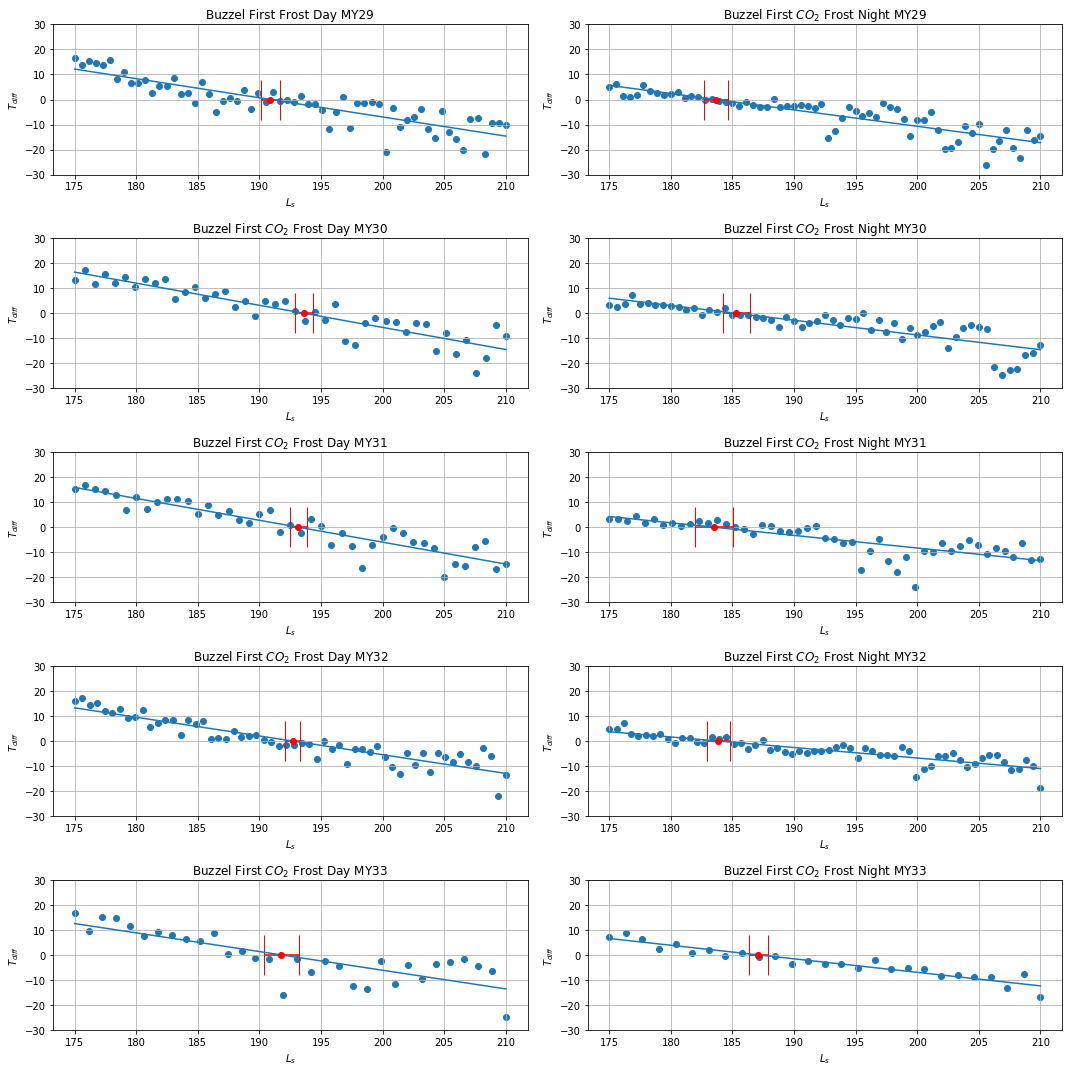

In [559]:
fig, axes = plt.subplots(5,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsBFD29,BuzzelFFDNetT29)
plt.errorbar(BFD29Err[0],0,xerr=BFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFD29,BFDcoe29[1]+BFDcoe29[0]*LsBFD29)
plt.title('Buzzel First Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsBFN29,BuzzelFFNNetT29)
plt.errorbar(BFN29Err[0],0,xerr=BFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFN29,BFNcoe29[1]+BFNcoe29[0]*LsBFN29)
plt.title('Buzzel First $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsBFD30,BuzzelFFDNetT30)
plt.errorbar(BFD30Err[0],0,xerr=BFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFD30,BFDcoe30[1]+BFDcoe30[0]*LsBFD30)
plt.title('Buzzel First $CO_2$ Frost Day MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsBFN30,BuzzelFFNNetT30)
plt.errorbar(BFN30Err[0],0,xerr=BFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFN30,BFNcoe30[1]+BFNcoe30[0]*LsBFN30)
plt.title('Buzzel First $CO_2$ Frost Night MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsBFD31,BuzzelFFDNetT31)
plt.errorbar(BFD31Err[0],0,xerr=BFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFD31,BFDcoe31[1]+BFDcoe31[0]*LsBFD31)
plt.title('Buzzel First $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsBFN31,BuzzelFFNNetT31)
plt.errorbar(BFN31Err[0],0,xerr=BFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFN31,BFNcoe31[1]+BFNcoe31[0]*LsBFN31)
plt.title('Buzzel First $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsBFD32,BuzzelFFDNetT32)
plt.errorbar(BFD32Err[0],0,xerr=BFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFD32,BFDcoe32[1]+BFDcoe32[0]*LsBFD32)
plt.title('Buzzel First $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsBFN32,BuzzelFFNNetT32)
plt.errorbar(BFN32Err[0],0,xerr=BFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFN32,BFNcoe32[1]+BFNcoe32[0]*LsBFN32)
plt.title('Buzzel First $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsBFD33,BuzzelFFDNetT33)
plt.errorbar(BFD33Err[0],0,xerr=BFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFD33,BFDcoe33[1]+BFDcoe33[0]*LsBFD33)
plt.title('Buzzel First $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsBFN33,BuzzelFFNNetT33)
plt.errorbar(BFN33Err[0],0,xerr=BFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBFN33,BFNcoe33[1]+BFNcoe33[0]*LsBFN33)
plt.title('Buzzel First $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

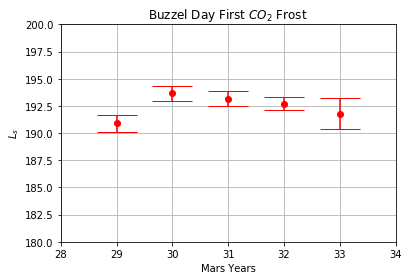

In [407]:
plt.errorbar(29,BFD29Err[0],yerr=BFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,BFD30Err[0],yerr=BFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,BFD31Err[0],yerr=BFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,BFD32Err[0],yerr=BFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,BFD33Err[0],yerr=BFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Buzzel Day First $CO_2$ Frost')
plt.ylim(180,200)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

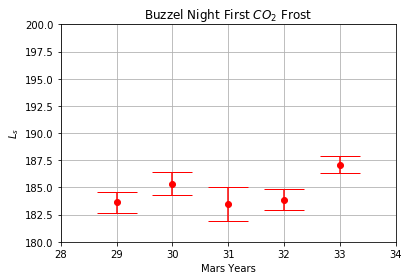

In [408]:
plt.errorbar(29,BFN29Err[0],yerr=BFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,BFN30Err[0],yerr=BFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,BFN31Err[0],yerr=BFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,BFN32Err[0],yerr=BFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,BFN33Err[0],yerr=BFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Buzzel Night First $CO_2$ Frost')
plt.ylim(180,200)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

In [340]:
newBuzzel30ADFD = Buzzel_SubframesDayMY29.copy()
newBuzzel30ADFD['L_s'] = (Buzzel_SubframesDayMY29['L_s'] -360)
Buzzel30ADFD = newBuzzel30ADFD[(newBuzzel30ADFD['L_s'] > -60.0)]

In [379]:
newBuzzel30BDFD = Buzzel_SubframesDayMY30.copy()
Buzzel30BDFD = newBuzzel30BDFD[(newBuzzel30BDF['L_s'] < 60.0)]

In [342]:
Buzzel30DFD = Buzzel30ADFD.append(Buzzel30BDFD)

In [343]:
newBuzzel30ADFN = Buzzel_SubframesNightMY29.copy()
newBuzzel30ADFN['L_s'] = (Buzzel_SubframesNightMY29['L_s'] -360)
Buzzel30ADFN = newBuzzel30ADFN[(newBuzzel30ADFN['L_s'] > -60.0)]

In [345]:
newBuzzel30BDFN = Buzzel_SubframesNightMY30.copy()
Buzzel30BDFN = newBuzzel30BDFN[(newBuzzel30BDFN['L_s'] < 60.0)]

In [346]:
Buzzel30DFN = Buzzel30ADFN.append(Buzzel30BDFN)

In [386]:
BuzzelLFDayMY29 = Buzzel_SubframesDayMY29[(Buzzel_SubframesDayMY29['L_s'] >= 0.0) & (Buzzel_SubframesDayMY29['L_s']<=60.0)]
BuzzelLFDayMY30 = Buzzel_SubframesDayMY30[(Buzzel_SubframesDayMY30['L_s'] >= 0.0) & (Buzzel_SubframesDayMY30['L_s']<=60.0)]
BuzzelLFDayMY31 = Buzzel_SubframesDayMY31[(Buzzel_SubframesDayMY31['L_s'] >= 0.0) & (Buzzel_SubframesDayMY31['L_s']<=60.0)]
BuzzelLFDayMY32 = Buzzel_SubframesDayMY32[(Buzzel_SubframesDayMY32['L_s'] >= 0.0) & (Buzzel_SubframesDayMY32['L_s']<=60.0)]
BuzzelLFDayMY33 = Buzzel_SubframesDayMY33[(Buzzel_SubframesDayMY33['L_s'] >= 0.0) & (Buzzel_SubframesDayMY33['L_s']<=60.0)]
BuzzelLFDayMY34 = Buzzel_SubframesDayMY34[(Buzzel_SubframesDayMY34['L_s'] >= 0.0) & (Buzzel_SubframesDayMY34['L_s']<=60.0)]

BuzzelLFNightMY29 = Buzzel_SubframesNightMY29[(Buzzel_SubframesNightMY29['L_s'] >= 0.0) & (Buzzel_SubframesNightMY29['L_s']<=60.0)]
BuzzelLFNightMY30 = Buzzel_SubframesNightMY30[(Buzzel_SubframesNightMY30['L_s'] >= 0.0) & (Buzzel_SubframesNightMY30['L_s']<=60.0)]
BuzzelLFNightMY31 = Buzzel_SubframesNightMY31[(Buzzel_SubframesNightMY31['L_s'] >= 0.0) & (Buzzel_SubframesNightMY31['L_s']<=60.0)]
BuzzelLFNightMY32 = Buzzel_SubframesNightMY32[(Buzzel_SubframesNightMY32['L_s'] >= 0.0) & (Buzzel_SubframesNightMY32['L_s']<=60.0)]
BuzzelLFNightMY33 = Buzzel_SubframesNightMY33[(Buzzel_SubframesNightMY33['L_s'] >= 0.0) & (Buzzel_SubframesNightMY33['L_s']<=60.0)]
BuzzelLFNightMY34 = Buzzel_SubframesNightMY34[(Buzzel_SubframesNightMY34['L_s'] >= 0.0) & (Buzzel_SubframesNightMY34['L_s']<=60.0)]


In [387]:
BuzzelLFDNetT29 = BuzzelLFDayMY29['T_surf'] - BuzzelLFDayMY29['Frost_T']
BuzzelLFDNetT30 = Buzzel30DFD['T_surf'] - Buzzel30DFD['Frost_T']
BuzzelLFDNetT31 = BuzzelLFDayMY31['T_surf'] - BuzzelLFDayMY31['Frost_T']
BuzzelLFDNetT32 = BuzzelLFDayMY32['T_surf'] - BuzzelLFDayMY32['Frost_T']
BuzzelLFDNetT33 = BuzzelLFDayMY33['T_surf'] - BuzzelLFDayMY33['Frost_T']
BuzzelLFDNetT34 = BuzzelLFDayMY34['T_surf'] - BuzzelLFDayMY34['Frost_T']

BuzzelLFNNetT29 = BuzzelLFNightMY29['T_surf'] - BuzzelLFNightMY29['Frost_T']
BuzzelLFNNetT30 = Buzzel30DFN['T_surf'] - Buzzel30DFN['Frost_T']
BuzzelLFNNetT31 = BuzzelLFNightMY31['T_surf'] - BuzzelLFNightMY31['Frost_T']
BuzzelLFNNetT32 = BuzzelLFNightMY32['T_surf'] - BuzzelLFNightMY32['Frost_T']
BuzzelLFNNetT33 = BuzzelLFNightMY33['T_surf'] - BuzzelLFNightMY33['Frost_T']
BuzzelLFNNetT34 = BuzzelLFNightMY34['T_surf'] - BuzzelLFNightMY34['Frost_T']

LsBLD29= np.linspace(0.0,60.0,len(BuzzelLFDNetT29))
LsBLD30= np.array(Buzzel30DFD['L_s'])
LsBLD31= np.linspace(0.0,60.0,len(BuzzelLFDNetT31))
LsBLD32= np.linspace(0.0,60.0,len(BuzzelLFDNetT32))
LsBLD33= np.linspace(0.0,60.0,len(BuzzelLFDNetT33))
LsBLD34= np.linspace(0.0,60.0,len(BuzzelLFDNetT34))

LsBLN29= np.linspace(0.0,60.0,len(BuzzelLFNNetT29))
LsBLN30= np.array(Buzzel30DFN['L_s'])
LsBLN31= np.linspace(0.0,60.0,len(BuzzelLFNNetT31))
LsBLN32= np.linspace(0.0,60.0,len(BuzzelLFNNetT32))
LsBLN33= np.linspace(0.0,60.0,len(BuzzelLFNNetT33))
LsBLN34= np.linspace(0.0,60.0,len(BuzzelLFNNetT34))

In [392]:
BLDcoe29, BLDcov29 =np.polyfit(LsBLD29,BuzzelLFDNetT29, 1, cov=True)
BLDcoe30, BLDcov30 =np.polyfit(LsBLD30,BuzzelLFDNetT30, 1, cov=True)
BLDcoe31, BLDcov31 =np.polyfit(LsBLD31,BuzzelLFDNetT31, 1, cov=True)
BLDcoe32, BLDcov32 =np.polyfit(LsBLD32,BuzzelLFDNetT32, 1, cov=True)
BLDcoe33, BLDcov33 =np.polyfit(LsBLD33,BuzzelLFDNetT33, 1, cov=True)
BLDcoe34, BLDcov34 =np.polyfit(LsBLD34,BuzzelLFDNetT34, 1, cov=True)

BLNcoe29, BLNcov29 =np.polyfit(LsBLN29,BuzzelLFNNetT29, 1, cov=True)
BLNcoe30, BLNcov30 =np.polyfit(LsBLN30,BuzzelLFNNetT30, 1, cov=True)
BLNcoe31, BLNcov31 =np.polyfit(LsBLN31,BuzzelLFNNetT31, 1, cov=True)
BLNcoe32, BLNcov32 =np.polyfit(LsBLN32,BuzzelLFNNetT32, 1, cov=True)
BLNcoe33, BLNcov33 =np.polyfit(LsBLN33,BuzzelLFNNetT33, 1, cov=True)
BLNcoe34, BLNcov34 =np.polyfit(LsBLN34,BuzzelLFNNetT34, 1, cov=True)

In [399]:
BLD29Err=xerr(BLDcoe29[0],BLDcoe29[1],BLDcov29)
BLD30Err=xerr(BLDcoe30[0],BLDcoe30[1],BLDcov30)
BLD31Err=xerr(BLDcoe31[0],BLDcoe31[1],BLDcov31)
BLD32Err=xerr(BLDcoe32[0],BLDcoe32[1],BLDcov32)
BLD33Err=xerr(BLDcoe33[0],BLDcoe33[1],BLDcov33)
BLD34Err=xerr(BLDcoe34[0],BLDcoe34[1],BLDcov34)

BLN29Err=xerr(BLNcoe29[0],BLNcoe29[1],BLNcov29)
BLN30Err=xerr(BLNcoe30[0],BLNcoe30[1],BLNcov30)
BLN31Err=xerr(BLNcoe31[0],BLNcoe31[1],BLNcov31)
BLN32Err=xerr(BLNcoe32[0],BLNcoe32[1],BLNcov32)
BLN33Err=xerr(BLNcoe33[0],BLNcoe33[1],BLNcov33)
BLN34Err=xerr(BLNcoe34[0],BLNcoe34[1],BLNcov34)

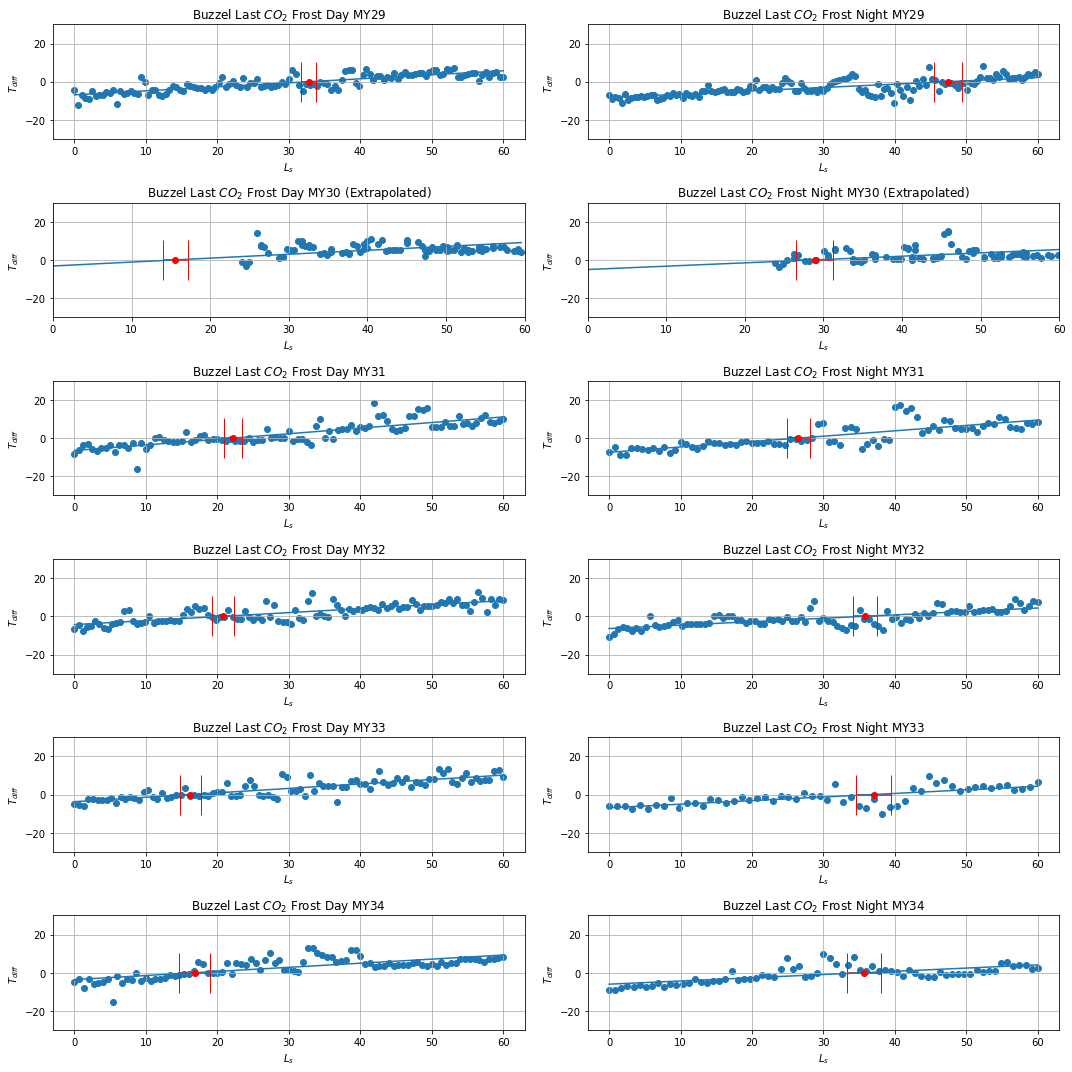

In [394]:
fig, axes = plt.subplots(6,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsBLD29,BuzzelLFDNetT29)
plt.errorbar(BLD29Err[0],0,xerr=BLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLD29,BLDcoe29[1]+BLDcoe29[0]*LsBLD29)
plt.title('Buzzel Last $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsBLN29,BuzzelLFNNetT29)
plt.errorbar(BLN29Err[0],0,xerr=BLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLN29,BLNcoe29[1]+BLNcoe29[0]*LsBLN29)
plt.title('Buzzel Last $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsBLD30,BuzzelLFDNetT30)
plt.errorbar(BLD30Err[0],0,xerr=BLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLD30,BLDcoe30[1]+BLDcoe30[0]*LsBLD30)
plt.title('Buzzel Last $CO_2$ Frost Day MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsBLN30,BuzzelLFNNetT30)
plt.errorbar(BLN30Err[0],0,xerr=BLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLN30,BLNcoe30[1]+BLNcoe30[0]*LsBLN30)
plt.title('Buzzel Last $CO_2$ Frost Night MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsBLD31,BuzzelLFDNetT31)
plt.errorbar(BLD31Err[0],0,xerr=BLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLD31,BLDcoe31[1]+BLDcoe31[0]*LsBLD31)
plt.title('Buzzel Last $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsBLN31,BuzzelLFNNetT31)
plt.errorbar(BLN31Err[0],0,xerr=BLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLN31,BLNcoe31[1]+BLNcoe31[0]*LsBLN31)
plt.title('Buzzel Last $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsBLD32,BuzzelLFDNetT32)
plt.errorbar(BLD32Err[0],0,xerr=BLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLD32,BLDcoe32[1]+BLDcoe32[0]*LsBLD32)
plt.title('Buzzel Last $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsBLN32,BuzzelLFNNetT32)
plt.errorbar(BLN32Err[0],0,xerr=BLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLN32,BLNcoe32[1]+BLNcoe32[0]*LsBLN32)
plt.title('Buzzel Last $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsBLD33,BuzzelLFDNetT33)
plt.errorbar(BLD33Err[0],0,xerr=BLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLD33,BLDcoe33[1]+BLDcoe33[0]*LsBLD33)
plt.title('Buzzel Last $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsBLN33,BuzzelLFNNetT33)
plt.errorbar(BLN33Err[0],0,xerr=BLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLN33,BLNcoe33[1]+BLNcoe33[0]*LsBLN33)
plt.title('Buzzel Last $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,0])
plt.scatter(LsBLD34,BuzzelLFDNetT34)
plt.errorbar(BLD34Err[0],0,xerr=BLD34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLD34,BLDcoe34[1]+BLDcoe34[0]*LsBLD34)
plt.title('Buzzel Last $CO_2$ Frost Day MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,1])
plt.scatter(LsBLN34,BuzzelLFNNetT34)
plt.errorbar(BLN34Err[0],0,xerr=BLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsBLN34,BLNcoe34[1]+BLNcoe34[0]*LsBLN34)
plt.title('Buzzel Last $CO_2$ Frost Night MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

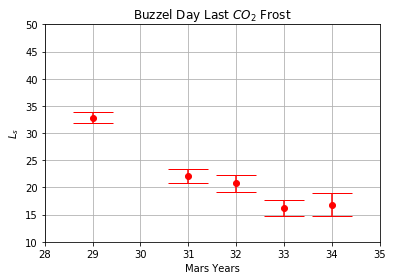

In [405]:
plt.errorbar(29,BLD29Err[0],yerr=BLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,BLD30Err[0],yerr=BLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,BLD31Err[0],yerr=BLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,BLD32Err[0],yerr=BLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,BLD33Err[0],yerr=BLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,BLD34Err[0],yerr=BLD34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Buzzel Day Last $CO_2$ Frost')
plt.ylim(10,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

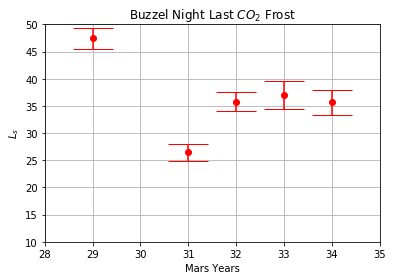

In [406]:
plt.errorbar(29,BLN29Err[0],yerr=BLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,BLN30Err[0],yerr=BLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,BLN31Err[0],yerr=BLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,BLN32Err[0],yerr=BLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,BLN33Err[0],yerr=BLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,BLN34Err[0],yerr=BLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Buzzel Night Last $CO_2$ Frost')
plt.ylim(10,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

### Buzzel 84.0N, 233.2E

We observed that at this location there is a general trend throughout the year that starts with temperatures below the carbon dioxide ($CO_2$) ice condensation point up to Solar Longitude ($L_s$) 50. Afterwards the temperature increases with a sharp slope up to $L_s$ 100 where it reaches its maximum temperature of about 220 kelvin. It then then slopes downward with a shallower slope until it reaches $L_s$ 200 where the temperature again reaches the condensation point for $CO_2$ ice to form. Between $L_s$ 200 until $L_s$ 50 of the next year we can see an oscillatory behavior for the temperatures between the values of 120 and 140 kelvin. We can see that the trends repeat during the nighttime but we see temperature to be roughly ten degrees less than the daytime and the decreasing slope seems to be more sharp than the daytime between $L_S$ 100 and $L_s$ 200.

#### Notes

- We see that in Mars year 28 there is a lack of data as well as gap in it. Lack of data is due to the probe having begun its mission in the middle of that Mars year, the other lack of data is due to possible calibrations of MCS.


- We see throughout that there are gaps in data which can possibly be attributed to calibrations.


- We see that in Mars year 34 there is also a lack of data, this is due to the fact that the data set that we obtained ended in the middle of Mars year 34.


- Mars year 30 started with a small deviation from the other years at the beginning, it seems that there is no $CO_2$ condensation given tha all points lie above their condensation temperature


- VERY IMPORTANT!!!! We ran the observations initially using a roughly 60x60 km box and obtained the previous results. As we increased the size of these boxes up to roughly 300x300 km, the only thing that changed was the amount of points (increased) for both the day and night plots but the trends remained the same. The other situation that changed was the distribution of points varied more the larger the box i.e. whenever the box size was increased the temperature range increased with it as well.

In [85]:
Kolhar = square(84.7, -179.3, size=2, type = 'deg')

In [86]:
Kolhar_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

Kolhar_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

Kolhar_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

Kolhar_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

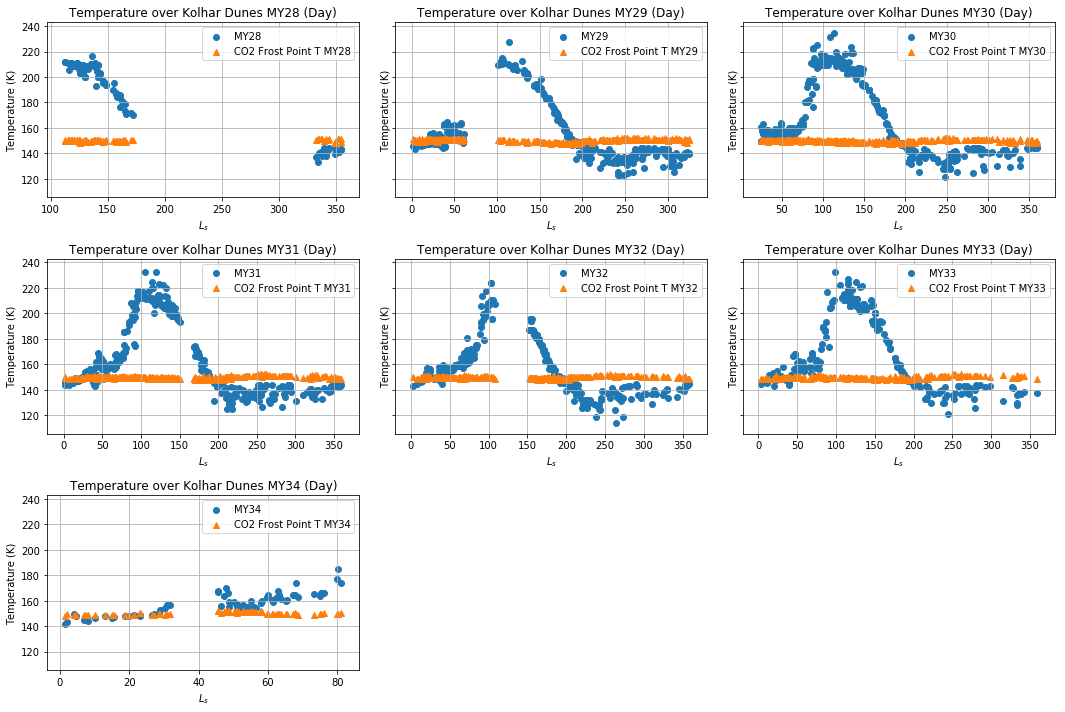

In [87]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesDayMY28['L_s'], Kolhar_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Kolhar_CO2Day28['L_s'],Kolhar_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY28 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesDayMY29['L_s'], Kolhar_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Kolhar_CO2Day29['L_s'],Kolhar_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY29 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesDayMY30['L_s'], Kolhar_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Kolhar_CO2Day30['L_s'],Kolhar_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY30 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesDayMY31['L_s'], Kolhar_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Kolhar_CO2Day31['L_s'],Kolhar_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY31 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesDayMY32['L_s'], Kolhar_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Kolhar_CO2Day32['L_s'],Kolhar_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY32 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesDayMY33['L_s'], Kolhar_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Kolhar_CO2Day33['L_s'],Kolhar_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY33 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesDayMY34['L_s'], Kolhar_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Kolhar_CO2Day34['L_s'],Kolhar_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY34 (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

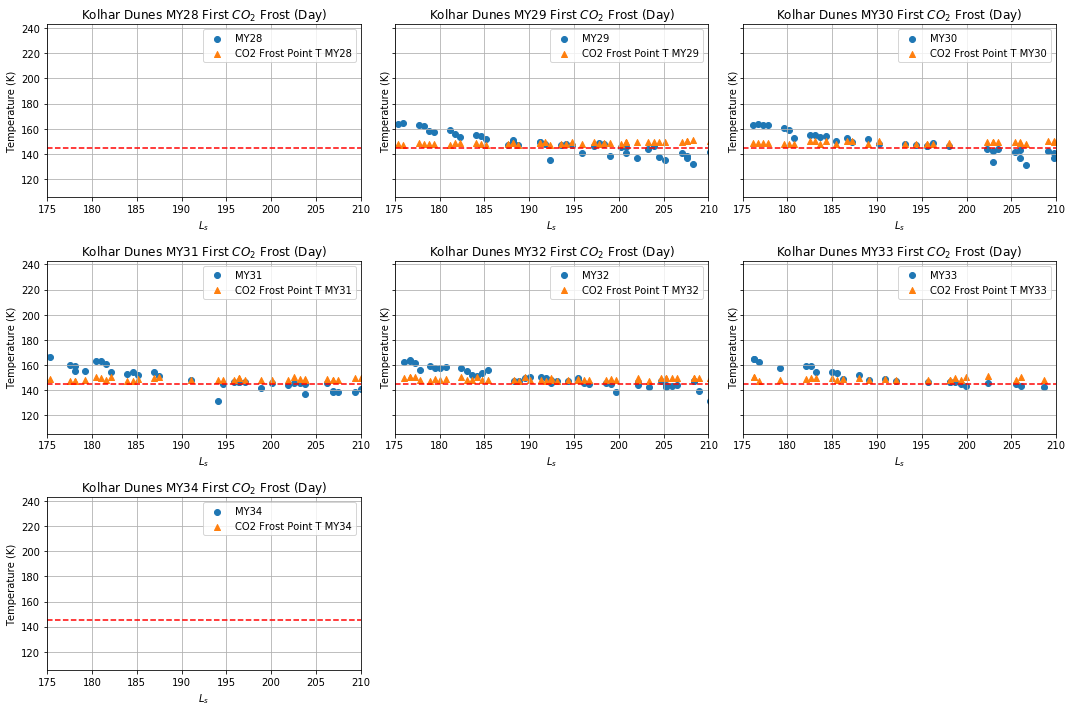

In [518]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesDayMY28['L_s'], Kolhar_SubframesDayMY28['T_surf'], label = 'MY28')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day28['L_s'],Kolhar_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY28 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesDayMY29['L_s'], Kolhar_SubframesDayMY29['T_surf'], label = 'MY29')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day29['L_s'],Kolhar_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY29 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesDayMY30['L_s'], Kolhar_SubframesDayMY30['T_surf'], label = 'MY30')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day30['L_s'],Kolhar_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY30 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesDayMY31['L_s'], Kolhar_SubframesDayMY31['T_surf'], label = 'MY31')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day31['L_s'],Kolhar_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY31 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesDayMY32['L_s'], Kolhar_SubframesDayMY32['T_surf'], label = 'MY32')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day32['L_s'],Kolhar_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY32 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesDayMY33['L_s'], Kolhar_SubframesDayMY33['T_surf'], label = 'MY33')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day33['L_s'],Kolhar_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY33 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesDayMY34['L_s'], Kolhar_SubframesDayMY34['T_surf'], label = 'MY34')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day34['L_s'],Kolhar_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY34 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

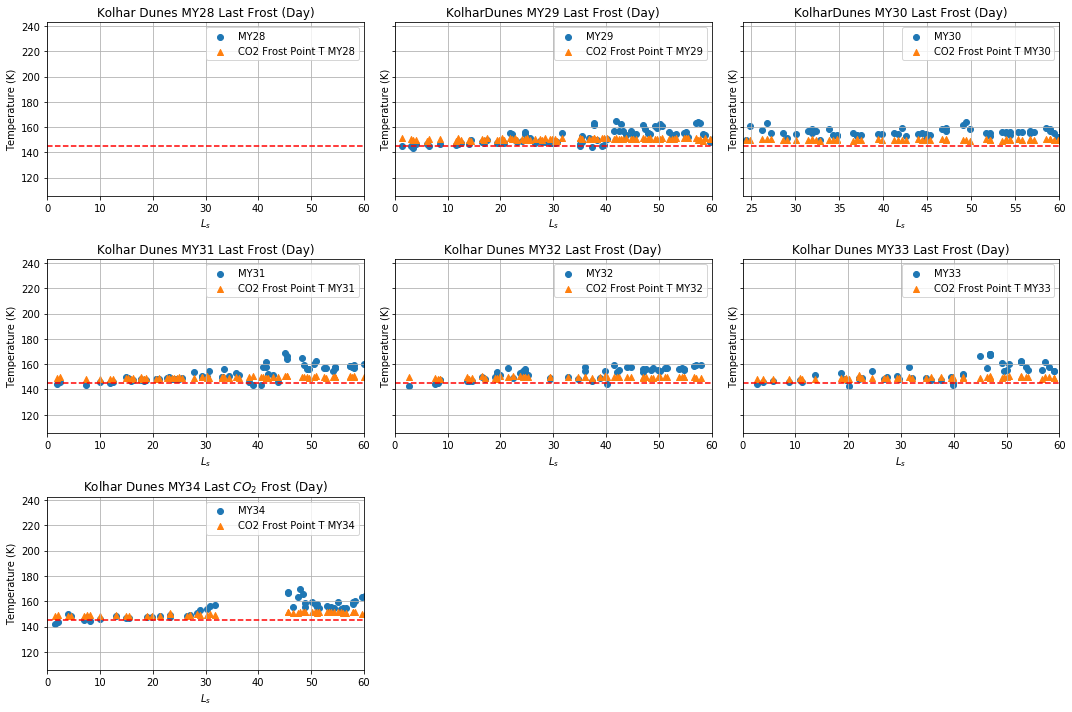

In [383]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesDayMY28['L_s'], Kolhar_SubframesDayMY28['T_surf'], label = 'MY28')
plt.axhline(145, color ='r', linestyle ='--')
plt.scatter(Kolhar_CO2Day28['L_s'],Kolhar_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY28 Last $CO_2$ Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesDayMY29['L_s'], Kolhar_SubframesDayMY29['T_surf'], label = 'MY29')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day29['L_s'],Kolhar_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('KolharDunes MY29 Last $CO_2$ Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesDayMY30['L_s'], Kolhar_SubframesDayMY30['T_surf'], label = 'MY30')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day30['L_s'],Kolhar_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('KolharDunes MY30 Last $CO_2$ Frost (Day)')
plt.xlim(24.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesDayMY31['L_s'], Kolhar_SubframesDayMY31['T_surf'], label = 'MY31')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day31['L_s'],Kolhar_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY31 Last $CO_2$ Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesDayMY32['L_s'], Kolhar_SubframesDayMY32['T_surf'], label = 'MY32')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day32['L_s'],Kolhar_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY32 Last $CO_2$ Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesDayMY33['L_s'], Kolhar_SubframesDayMY33['T_surf'], label = 'MY33')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day33['L_s'],Kolhar_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY33 Last $CO_2$ Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesDayMY34['L_s'], Kolhar_SubframesDayMY34['T_surf'], label = 'MY34')
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Day34['L_s'],Kolhar_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY34 Last $CO_2$ Frost (Day)')
plt.xlim(0.0,60.0)
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

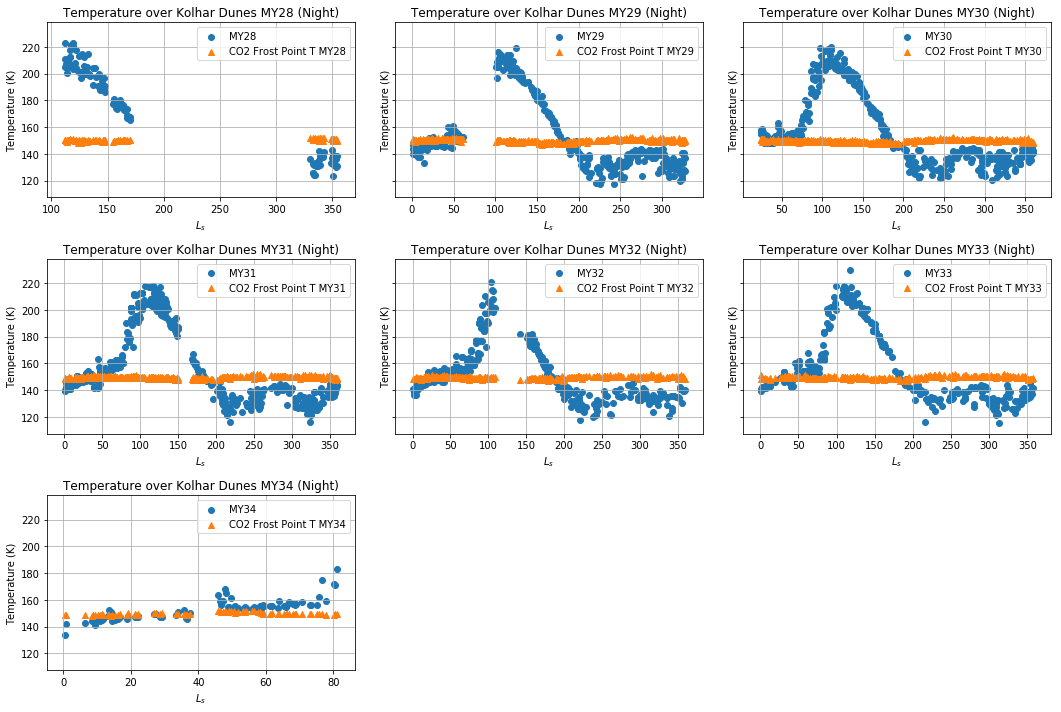

In [169]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesNightMY28['L_s'], Kolhar_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Kolhar_CO2Night28['L_s'],Kolhar_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY28 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesNightMY29['L_s'], Kolhar_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Kolhar_CO2Night29['L_s'],Kolhar_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY29 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesNightMY30['L_s'], Kolhar_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Kolhar_CO2Night30['L_s'],Kolhar_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY30 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesNightMY31['L_s'], Kolhar_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Kolhar_CO2Night31['L_s'],Kolhar_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY31 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesNightMY32['L_s'], Kolhar_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Kolhar_CO2Night32['L_s'],Kolhar_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY32 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesNightMY33['L_s'], Kolhar_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Kolhar_CO2Night33['L_s'],Kolhar_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY33 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesNightMY34['L_s'], Kolhar_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Kolhar_CO2Night34['L_s'],Kolhar_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY34 (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

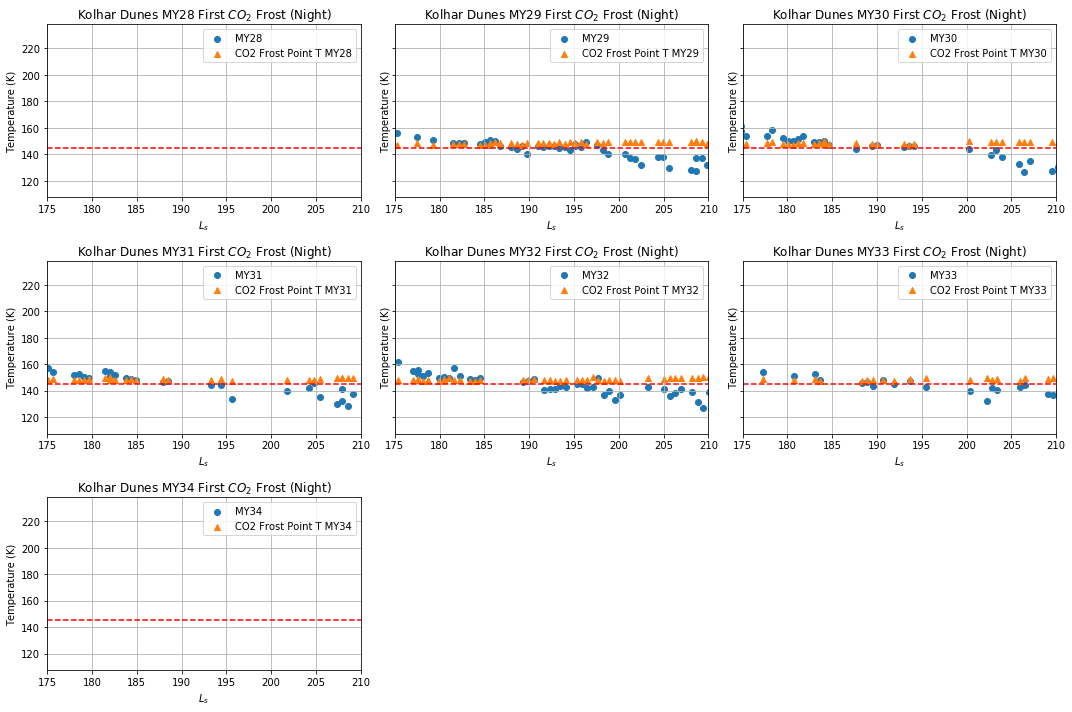

In [517]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesNightMY28['L_s'], Kolhar_SubframesNightMY28['T_surf'], label = 'MY28')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night28['L_s'],Kolhar_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY28 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesNightMY29['L_s'], Kolhar_SubframesNightMY29['T_surf'], label = 'MY29')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night29['L_s'],Kolhar_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY29 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesNightMY30['L_s'], Kolhar_SubframesNightMY30['T_surf'], label = 'MY30')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night30['L_s'],Kolhar_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY30 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesNightMY31['L_s'], Kolhar_SubframesNightMY31['T_surf'], label = 'MY31')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night31['L_s'],Kolhar_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY31 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesNightMY32['L_s'], Kolhar_SubframesNightMY32['T_surf'], label = 'MY32')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night32['L_s'],Kolhar_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY32 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesNightMY33['L_s'], Kolhar_SubframesNightMY33['T_surf'], label = 'MY33')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night33['L_s'],Kolhar_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY33 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesNightMY34['L_s'], Kolhar_SubframesNightMY34['T_surf'], label = 'MY34')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night34['L_s'],Kolhar_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY34 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

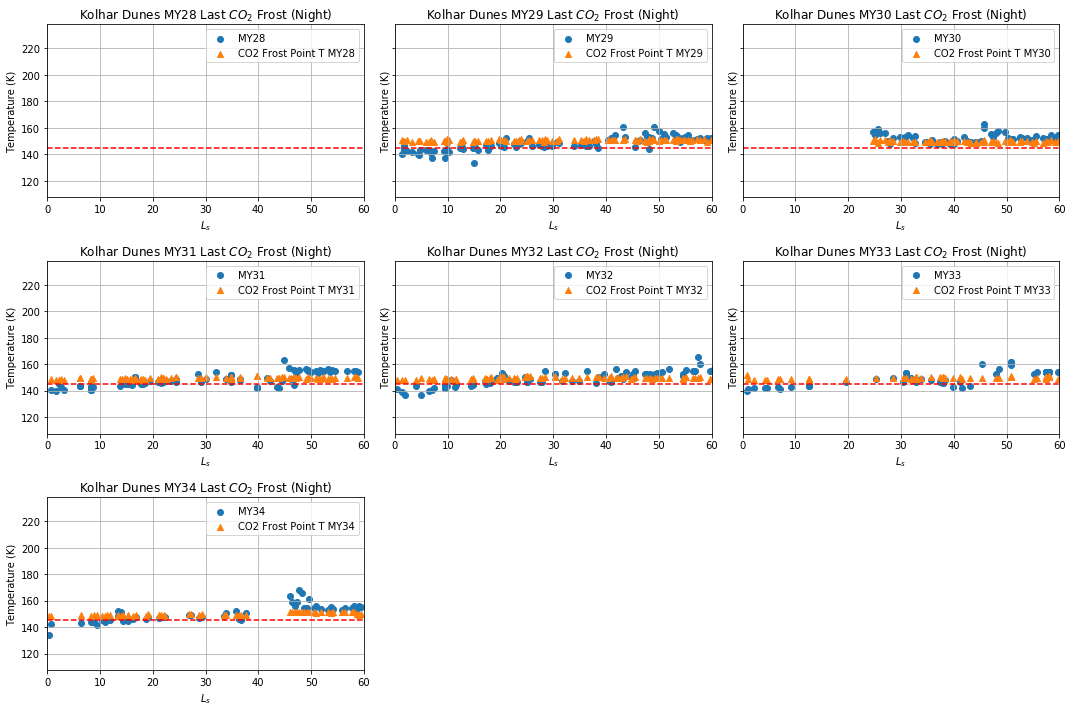

In [411]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesNightMY28['L_s'], Kolhar_SubframesNightMY28['T_surf'], label = 'MY28')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night28['L_s'],Kolhar_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY28 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesNightMY29['L_s'], Kolhar_SubframesNightMY29['T_surf'], label = 'MY29')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night29['L_s'],Kolhar_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY29 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesNightMY30['L_s'], Kolhar_SubframesNightMY30['T_surf'], label = 'MY30')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night30['L_s'],Kolhar_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY30 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesNightMY31['L_s'], Kolhar_SubframesNightMY31['T_surf'], label = 'MY31')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night31['L_s'],Kolhar_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY31 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesNightMY32['L_s'], Kolhar_SubframesNightMY32['T_surf'], label = 'MY32')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night32['L_s'],Kolhar_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY32 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesNightMY33['L_s'], Kolhar_SubframesNightMY33['T_surf'], label = 'MY33')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night33['L_s'],Kolhar_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY33 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesNightMY34['L_s'], Kolhar_SubframesNightMY34['T_surf'], label = 'MY34')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Kolhar_CO2Night34['L_s'],Kolhar_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Kolhar Dunes MY34 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [363]:
KolharFFDayMY29 = Kolhar_SubframesDayMY29[(Kolhar_SubframesDayMY29['L_s'] >= 175) & (Kolhar_SubframesDayMY29['L_s']<=210)]
KolharFFDayMY30 = Kolhar_SubframesDayMY30[(Kolhar_SubframesDayMY30['L_s'] >= 175) & (Kolhar_SubframesDayMY30['L_s']<=210)]
KolharFFDayMY31 = Kolhar_SubframesDayMY31[(Kolhar_SubframesDayMY31['L_s'] >= 175) & (Kolhar_SubframesDayMY31['L_s']<=210)]
KolharFFDayMY32 = Kolhar_SubframesDayMY32[(Kolhar_SubframesDayMY32['L_s'] >= 175) & (Kolhar_SubframesDayMY32['L_s']<=210)]
KolharFFDayMY33 = Kolhar_SubframesDayMY33[(Kolhar_SubframesDayMY33['L_s'] >= 175) & (Kolhar_SubframesDayMY33['L_s']<=210)]

KolharFFNightMY29 = Kolhar_SubframesNightMY29[(Kolhar_SubframesNightMY29['L_s'] >= 175) & (Kolhar_SubframesNightMY29['L_s']<=210)]
KolharFFNightMY30 = Kolhar_SubframesNightMY30[(Kolhar_SubframesNightMY30['L_s'] >= 175) & (Kolhar_SubframesNightMY30['L_s']<=210)]
KolharFFNightMY31 = Kolhar_SubframesNightMY31[(Kolhar_SubframesNightMY31['L_s'] >= 175) & (Kolhar_SubframesNightMY31['L_s']<=210)]
KolharFFNightMY32 = Kolhar_SubframesNightMY32[(Kolhar_SubframesNightMY32['L_s'] >= 175) & (Kolhar_SubframesNightMY32['L_s']<=210)]
KolharFFNightMY33 = Kolhar_SubframesNightMY33[(Kolhar_SubframesNightMY33['L_s'] >= 175) & (Kolhar_SubframesNightMY33['L_s']<=210)]

In [364]:
KolharFFDNetT29 = KolharFFDayMY29['T_surf'] - KolharFFDayMY29['Frost_T']
KolharFFDNetT30 = KolharFFDayMY30['T_surf'] - KolharFFDayMY30['Frost_T']
KolharFFDNetT31 = KolharFFDayMY31['T_surf'] - KolharFFDayMY31['Frost_T']
KolharFFDNetT32 = KolharFFDayMY32['T_surf'] - KolharFFDayMY32['Frost_T']
KolharFFDNetT33 = KolharFFDayMY33['T_surf'] - KolharFFDayMY33['Frost_T']

KolharFFNNetT29 = KolharFFNightMY29['T_surf'] - KolharFFNightMY29['Frost_T']
KolharFFNNetT30 = KolharFFNightMY30['T_surf'] - KolharFFNightMY30['Frost_T']
KolharFFNNetT31 = KolharFFNightMY31['T_surf'] - KolharFFNightMY31['Frost_T']
KolharFFNNetT32 = KolharFFNightMY32['T_surf'] - KolharFFNightMY32['Frost_T']
KolharFFNNetT33 = KolharFFNightMY33['T_surf'] - KolharFFNightMY33['Frost_T']

LsKFD29= np.linspace(175,210,len(KolharFFDNetT29))
LsKFD30= np.linspace(175,210,len(KolharFFDNetT30))
LsKFD31= np.linspace(175,210,len(KolharFFDNetT31))
LsKFD32= np.linspace(175,210,len(KolharFFDNetT32))
LsKFD33= np.linspace(175,210,len(KolharFFDNetT33))

LsKFN29= np.linspace(175,210,len(KolharFFNNetT29))
LsKFN30= np.linspace(175,210,len(KolharFFNNetT30))
LsKFN31= np.linspace(175,210,len(KolharFFNNetT31))
LsKFN32= np.linspace(175,210,len(KolharFFNNetT32))
LsKFN33= np.linspace(175,210,len(KolharFFNNetT33))

In [365]:
KFDcoe29, KFDcov29 =np.polyfit(LsKFD29,KolharFFDNetT29, 1, cov=True)
KFDcoe30, KFDcov30 =np.polyfit(LsKFD30,KolharFFDNetT30, 1, cov=True)
KFDcoe31, KFDcov31 =np.polyfit(LsKFD31,KolharFFDNetT31, 1, cov=True)
KFDcoe32, KFDcov32 =np.polyfit(LsKFD32,KolharFFDNetT32, 1, cov=True)
KFDcoe33, KFDcov33 =np.polyfit(LsKFD33,KolharFFDNetT33, 1, cov=True)

KFNcoe29, KFNcov29 =np.polyfit(LsKFN29,KolharFFNNetT29, 1, cov=True)
KFNcoe30, KFNcov30 =np.polyfit(LsKFN30,KolharFFNNetT30, 1, cov=True)
KFNcoe31, KFNcov31 =np.polyfit(LsKFN31,KolharFFNNetT31, 1, cov=True)
KFNcoe32, KFNcov32 =np.polyfit(LsKFN32,KolharFFNNetT32, 1, cov=True)
KFNcoe33, KFNcov33 =np.polyfit(LsKFN33,KolharFFNNetT33, 1, cov=True)

In [366]:
KFD29Err=xerr(KFDcoe29[0],KFDcoe29[1],KFDcov29)
KFD30Err=xerr(KFDcoe30[0],KFDcoe30[1],KFDcov30)
KFD31Err=xerr(KFDcoe31[0],KFDcoe31[1],KFDcov31)
KFD32Err=xerr(KFDcoe32[0],KFDcoe32[1],KFDcov32)
KFD33Err=xerr(KFDcoe33[0],KFDcoe33[1],KFDcov33)

KFN29Err=xerr(KFNcoe29[0],KFNcoe29[1],KFNcov29)
KFN30Err=xerr(KFNcoe30[0],KFNcoe30[1],KFNcov30)
KFN31Err=xerr(KFNcoe31[0],KFNcoe31[1],KFNcov31)
KFN32Err=xerr(KFNcoe32[0],KFNcoe32[1],KFNcov32)
KFN33Err=xerr(KFNcoe33[0],KFNcoe33[1],KFNcov33)

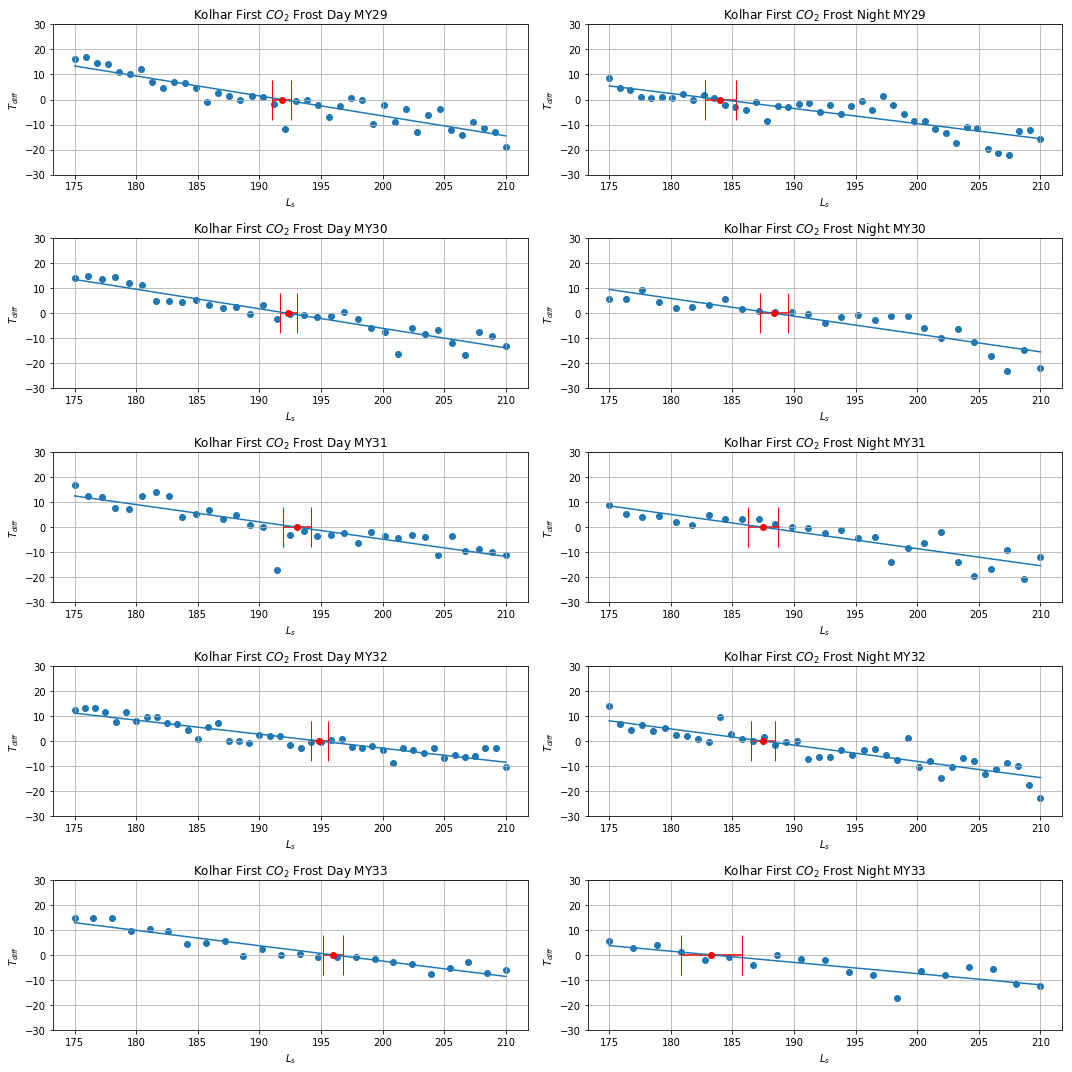

In [558]:
fig, axes = plt.subplots(5,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsKFD29,KolharFFDNetT29)
plt.errorbar(KFD29Err[0],0,xerr=KFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFD29,KFDcoe29[1]+KFDcoe29[0]*LsKFD29)
plt.title('Kolhar First $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsKFN29,KolharFFNNetT29)
plt.errorbar(KFN29Err[0],0,xerr=KFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFN29,KFNcoe29[1]+KFNcoe29[0]*LsKFN29)
plt.title('Kolhar First $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsKFD30,KolharFFDNetT30)
plt.errorbar(KFD30Err[0],0,xerr=KFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFD30,KDcoe30[1]+KFDcoe30[0]*LsKFD30)
plt.title('Kolhar First $CO_2$ Frost Day MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsKFN30,KolharFFNNetT30)
plt.errorbar(KFN30Err[0],0,xerr=KFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFN30,KFNcoe30[1]+KFNcoe30[0]*LsKFN30)
plt.title('Kolhar First $CO_2$ Frost Night MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsKFD31,KolharFFDNetT31)
plt.errorbar(KFD31Err[0],0,xerr=KFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFD31,KFDcoe31[1]+KFDcoe31[0]*LsKFD31)
plt.title('Kolhar First $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsKN31,KolharFFNNetT31)
plt.errorbar(KN31Err[0],0,xerr=KN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKN31,KNcoe31[1]+KNcoe31[0]*LsKN31)
plt.title('Kolhar First $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsKFD32,KolharFFDNetT32)
plt.errorbar(KFD32Err[0],0,xerr=KFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFD32,KFDcoe32[1]+KFDcoe32[0]*LsKFD32)
plt.title('Kolhar First $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsKFN32,KolharFFNNetT32)
plt.errorbar(KFN32Err[0],0,xerr=KFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFN32,KFNcoe32[1]+KFNcoe32[0]*LsKFN32)
plt.title('Kolhar First $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsKFD33,KolharFFDNetT33)
plt.errorbar(KFD33Err[0],0,xerr=KFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFD33,KFDcoe33[1]+KFDcoe33[0]*LsKFD33)
plt.title('Kolhar First $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsKFN33,KolharFFNNetT33)
plt.errorbar(KFN33Err[0],0,xerr=KFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKFN33,KFNcoe33[1]+KFNcoe33[0]*LsKFN33)
plt.title('Kolhar First $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

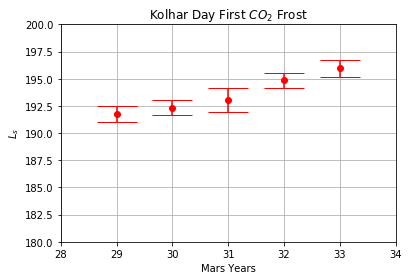

In [412]:
plt.errorbar(29,KFD29Err[0],yerr=KFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,KFD30Err[0],yerr=KFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,KFD31Err[0],yerr=KFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,KFD32Err[0],yerr=KFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,KFD33Err[0],yerr=KFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Kolhar Day First $CO_2$ Frost')
plt.ylim(180,200)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

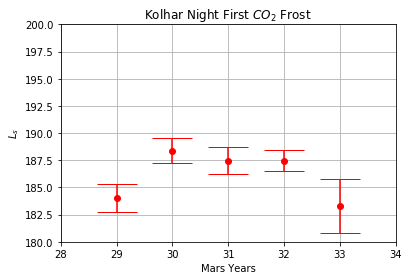

In [413]:
plt.errorbar(29,KFN29Err[0],yerr=KFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,KFN30Err[0],yerr=KFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,KFN31Err[0],yerr=KFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,KFN32Err[0],yerr=KFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,KFN33Err[0],yerr=KFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Kolhar Night First $CO_2$ Frost')
plt.ylim(180,200)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

In [414]:
newKolhar30ADFD = Kolhar_SubframesDayMY29.copy()
newKolhar30ADFD['L_s'] = (Kolhar_SubframesDayMY29['L_s'] -360)
Kolhar30ADFD = newKolhar30ADFD[(newKolhar30ADFD['L_s'] > -60.0)]

In [428]:
newKolhar30BDF = Kolhar_SubframesDayMY30.copy()
Kolhar30BDFD = newKolhar30BDF[(newKolhar30BDF['L_s'] < 60.0)]

In [429]:
Kolhar30DFD = Kolhar30ADFD.append(Kolhar30BDFD)

In [431]:
newKolhar30ADFN = Kolhar_SubframesNightMY29.copy()
newKolhar30ADFN['L_s'] = (Kolhar_SubframesNightMY29['L_s'] -360)
Kolhar30ADFN = newKolhar30ADFN[(newKolhar30ADFN['L_s'] > -60.0)]

In [432]:
newKolhar30BDF = Kolhar_SubframesNightMY30.copy()
Kolhar30BDFN = newKolhar30BDF[(newKolhar30BDF['L_s'] < 60.0)]

In [433]:
Kolhar30DFN = Kolhar30ADFN.append(Kolhar30BDFN)

In [434]:
KolharLFDayMY29 = Kolhar_SubframesDayMY29[(Kolhar_SubframesDayMY29['L_s'] >= 0.0) & (Kolhar_SubframesDayMY29['L_s']<=60.0)]
KolharLFDayMY30 = Kolhar_SubframesDayMY30[(Kolhar_SubframesDayMY30['L_s'] >= 0.0) & (Kolhar_SubframesDayMY30['L_s']<=60.0)]
KolharLFDayMY31 = Kolhar_SubframesDayMY31[(Kolhar_SubframesDayMY31['L_s'] >= 0.0) & (Kolhar_SubframesDayMY31['L_s']<=60.0)]
KolharLFDayMY32 = Kolhar_SubframesDayMY32[(Kolhar_SubframesDayMY32['L_s'] >= 0.0) & (Kolhar_SubframesDayMY32['L_s']<=60.0)]
KolharLFDayMY33 = Kolhar_SubframesDayMY33[(Kolhar_SubframesDayMY33['L_s'] >= 0.0) & (Kolhar_SubframesDayMY33['L_s']<=60.0)]
KolharLFDayMY34 = Kolhar_SubframesDayMY34[(Kolhar_SubframesDayMY34['L_s'] >= 0.0) & (Kolhar_SubframesDayMY34['L_s']<=60.0)]

KolharLFNightMY29 = Kolhar_SubframesNightMY29[(Kolhar_SubframesNightMY29['L_s'] >= 0.0) & (Kolhar_SubframesNightMY29['L_s']<=60.0)]
KolharLFNightMY30 = Kolhar_SubframesNightMY30[(Kolhar_SubframesNightMY30['L_s'] >= 0.0) & (Kolhar_SubframesNightMY30['L_s']<=60.0)]
KolharLFNightMY31 = Kolhar_SubframesNightMY31[(Kolhar_SubframesNightMY31['L_s'] >= 0.0) & (Kolhar_SubframesNightMY31['L_s']<=60.0)]
KolharLFNightMY32 = Kolhar_SubframesNightMY32[(Kolhar_SubframesNightMY32['L_s'] >= 0.0) & (Kolhar_SubframesNightMY32['L_s']<=60.0)]
KolharLFNightMY33 = Kolhar_SubframesNightMY33[(Kolhar_SubframesNightMY33['L_s'] >= 0.0) & (Kolhar_SubframesNightMY33['L_s']<=60.0)]
KolharLFNightMY34 = Kolhar_SubframesNightMY34[(Kolhar_SubframesNightMY34['L_s'] >= 0.0) & (Kolhar_SubframesNightMY34['L_s']<=60.0)]

In [445]:
KolharLFDNetT29 = KolharLFDayMY29['T_surf'] - KolharLFDayMY29['Frost_T']
KolharLFDNetT30 = Kolhar30DFD['T_surf'] - Kolhar30DFD['Frost_T']
KolharLFDNetT31 = KolharLFDayMY31['T_surf'] - KolharLFDayMY31['Frost_T']
KolharLFDNetT32 = KolharLFDayMY32['T_surf'] - KolharLFDayMY32['Frost_T']
KolharLFDNetT33 = KolharLFDayMY33['T_surf'] - KolharLFDayMY33['Frost_T']
KolharLFDNetT34 = KolharLFDayMY34['T_surf'] - KolharLFDayMY34['Frost_T']

KolharLFNNetT29 = KolharLFNightMY29['T_surf'] - KolharLFNightMY29['Frost_T']
KolharLFNNetT30 = Kolhar30DFN['T_surf'] - Kolhar30DFN['Frost_T']
KolharLFNNetT31 = KolharLFNightMY31['T_surf'] - KolharLFNightMY31['Frost_T']
KolharLFNNetT32 = KolharLFNightMY32['T_surf'] - KolharLFNightMY32['Frost_T']
KolharLFNNetT33 = KolharLFNightMY33['T_surf'] - KolharLFNightMY33['Frost_T']
KolharLFNNetT34 = KolharLFNightMY34['T_surf'] - KolharLFNightMY34['Frost_T']

LsKLD29= np.linspace(0.0,60.0,len(KolharLFDNetT29))
LsKLD30= np.array(Kolhar30DFD['L_s'])
LsKLD31= np.linspace(0.0,60.0,len(KolharLFDNetT31))
LsKLD32= np.linspace(0.0,60.0,len(KolharLFDNetT32))
LsKLD33= np.linspace(0.0,60.0,len(KolharLFDNetT33))
LsKLD34= np.linspace(0.0,60.0,len(KolharLFDNetT34))

LsKLN29= np.linspace(0.0,60.0,len(KolharLFNNetT29))
LsKLN30= np.array(Kolhar30DFN['L_s'])
LsKLN31= np.linspace(0.0,60.0,len(KolharLFNNetT31))
LsKLN32= np.linspace(0.0,60.0,len(KolharLFNNetT32))
LsKLN33= np.linspace(0.0,60.0,len(KolharLFNNetT33))
LsKLN34= np.linspace(0.0,60.0,len(KolharLFNNetT34))

In [447]:
KLDcoe29, KLDcov29 =np.polyfit(LsKLD29,KolharLFDNetT29, 1, cov=True)
KLDcoe30, KLDcov30 =np.polyfit(LsKLD30,KolharLFDNetT30, 1, cov=True)
KLDcoe31, KLDcov31 =np.polyfit(LsKLD31,KolharLFDNetT31, 1, cov=True)
KLDcoe32, KLDcov32 =np.polyfit(LsKLD32,KolharLFDNetT32, 1, cov=True)
KLDcoe33, KLDcov33 =np.polyfit(LsKLD33,KolharLFDNetT33, 1, cov=True)
KLDcoe34, KLDcov34 =np.polyfit(LsKLD34,KolharLFDNetT34, 1, cov=True)


KLNcoe29, KLNcov29 =np.polyfit(LsKLN29,KolharLFNNetT29, 1, cov=True)
KLNcoe30, KLNcov30 =np.polyfit(LsKLN30,KolharLFNNetT30, 1, cov=True)
KLNcoe31, KLNcov31 =np.polyfit(LsKLN31,KolharLFNNetT31, 1, cov=True)
KLNcoe32, KLNcov32 =np.polyfit(LsKLN32,KolharLFNNetT32, 1, cov=True)
KLNcoe33, KLNcov33 =np.polyfit(LsKLN33,KolharLFNNetT33, 1, cov=True)
KLNcoe34, KLNcov34 =np.polyfit(LsKLN34,KolharLFNNetT34, 1, cov=True)

In [451]:
KLD29Err=xerr(KLDcoe29[0],KLDcoe29[1],KLDcov29)
KLD30Err=xerr(KLDcoe30[0],KLDcoe30[1],KLDcov30)
KLD31Err=xerr(KLDcoe31[0],KLDcoe31[1],KLDcov31)
KLD32Err=xerr(KLDcoe32[0],KLDcoe32[1],KLDcov32)
KLD33Err=xerr(KLDcoe33[0],KLDcoe33[1],KLDcov33)
KLD34Err=xerr(KLDcoe34[0],KLDcoe34[1],KLDcov34)

KLN29Err=xerr(KLNcoe29[0],KLNcoe29[1],KLNcov29)
KLN30Err=xerr(KLNcoe30[0],KLNcoe30[1],KLNcov30)
KLN31Err=xerr(KLNcoe31[0],KLNcoe31[1],KLNcov31)
KLN32Err=xerr(KLNcoe32[0],KLNcoe32[1],KLNcov32)
KLN33Err=xerr(KLNcoe33[0],KLNcoe33[1],KLNcov33)
KLN34Err=xerr(KLNcoe34[0],KLNcoe34[1],KLNcov34)

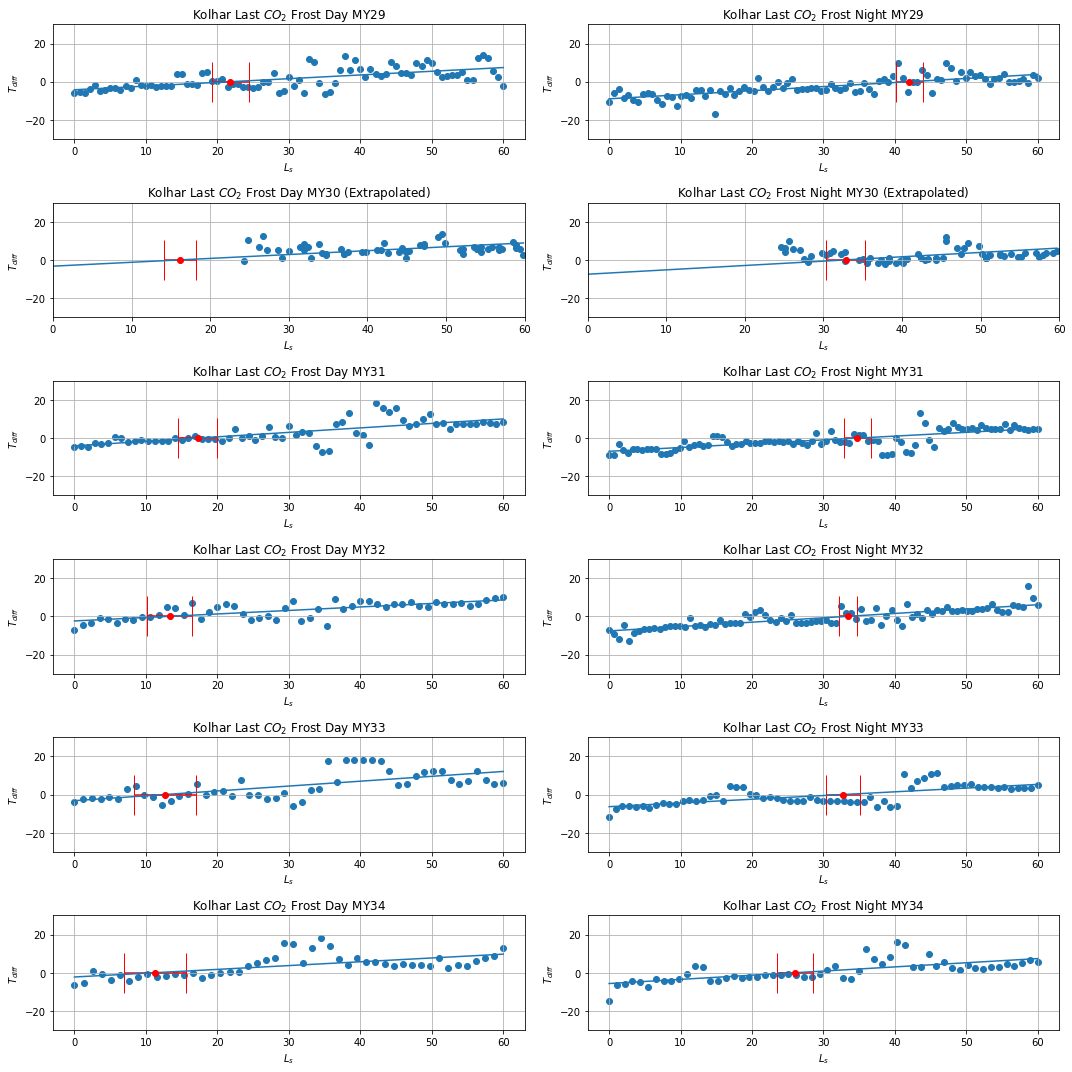

In [452]:
fig, axes = plt.subplots(6,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsKLD29,KolharLFDNetT29)
plt.errorbar(KLD29Err[0],0,xerr=KLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLD29,KLDcoe29[1]+KLDcoe29[0]*LsKLD29)
plt.title('Kolhar Last $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsKLN29,KolharLFNNetT29)
plt.errorbar(KLN29Err[0],0,xerr=KLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLN29,KLNcoe29[1]+KLNcoe29[0]*LsKLN29)
plt.title('Kolhar Last $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsKLD30,KolharLFDNetT30)
plt.errorbar(KLD30Err[0],0,xerr=KLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLD30,KLDcoe30[1]+KLDcoe30[0]*LsKLD30)
plt.title('Kolhar Last $CO_2$ Frost Day MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsKLN30,KolharLFNNetT30)
plt.errorbar(KLN30Err[0],0,xerr=KLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLN30,KLNcoe30[1]+KLNcoe30[0]*LsKLN30)
plt.title('Kolhar Last $CO_2$ Frost Night MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsKLD31,KolharLFDNetT31)
plt.errorbar(KLD31Err[0],0,xerr=KLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLD31,KLDcoe31[1]+KLDcoe31[0]*LsKLD31)
plt.title('Kolhar Last $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsKLN31,KolharLFNNetT31)
plt.errorbar(KLN31Err[0],0,xerr=KLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLN31,KLNcoe31[1]+KLNcoe31[0]*LsKLN31)
plt.title('Kolhar Last $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsKLD32,KolharLFDNetT32)
plt.errorbar(KLD32Err[0],0,xerr=KLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLD32,KLDcoe32[1]+KLDcoe32[0]*LsKLD32)
plt.title('Kolhar Last $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsKLN32,KolharLFNNetT32)
plt.errorbar(KLN32Err[0],0,xerr=KLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLN32,KLNcoe32[1]+KLNcoe32[0]*LsKLN32)
plt.title('Kolhar Last $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsKLD33,KolharLFDNetT33)
plt.errorbar(KLD33Err[0],0,xerr=KLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLD33,KLDcoe33[1]+KLDcoe33[0]*LsKLD33)
plt.title('Kolhar Last $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsKLN33,KolharLFNNetT33)
plt.errorbar(KLN33Err[0],0,xerr=KLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLN33,KLNcoe33[1]+KLNcoe33[0]*LsKLN33)
plt.title('Kolhar Last $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,0])
plt.scatter(LsKLD34,KolharLFDNetT34)
plt.errorbar(KLD34Err[0],0,xerr=KLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLD34,KLDcoe34[1]+KLDcoe34[0]*LsKLD34)
plt.title('Kolhar Last $CO_2$ Frost Day MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,1])
plt.scatter(LsKLN34,KolharLFNNetT34)
plt.errorbar(KLN34Err[0],0,xerr=KLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsKLN34,KLNcoe34[1]+KLNcoe34[0]*LsKLN34)
plt.title('Kolhar Last $CO_2$ Frost Night MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

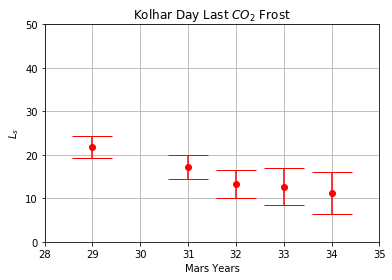

In [493]:
plt.errorbar(29,KLD29Err[0],yerr=KLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,KLD30Err[0],yerr=KLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,KLD31Err[0],yerr=KLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,KLD32Err[0],yerr=KLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,KLD33Err[0],yerr=KLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,KLD34Err[0],yerr=KLD34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Kolhar Day Last $CO_2$ Frost')
plt.ylim(0,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

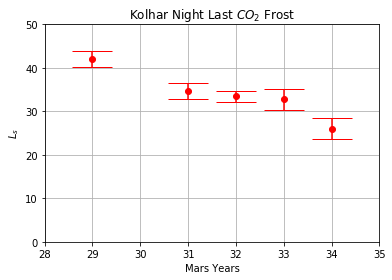

In [494]:
plt.errorbar(29,KLN29Err[0],yerr=KLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,KLN30Err[0],yerr=KLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,KLN31Err[0],yerr=KLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,KLN32Err[0],yerr=KLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,KLN33Err[0],yerr=KLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,KLN34Err[0],yerr=KLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Kolhar Night Last $CO_2$ Frost')
plt.ylim(0,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

### Kolhar 84.7N, 0.7E

We observed that at this location there is a general trend throughout the year that starts with temperatures below the carbon dioxide ($CO_2$) ice condensation point up to Solar Longitude ($L_s$) 50. Afterwards the temperature increases with a sharp slope up to $L_s$ 100 where it reaches its maximum temperature of about 220 kelvin on average. It then then slopes downward with a shallower slope until it reaches $L_s$ 200 where the temperature again reaches the condensation point for $CO_2$ ice to form. Between $L_s$ 200 until $L_s$ 50 of the next year we can see an oscillatory behavior for the temperatures between the values of 120 and 140 kelvin. Kolhar shows a larger variability of temperatures from year to year during the day; although there is an inherent trend that is shared with the Buzzel site during the day and night, we see temperatures vary from year to year between 5 to 10 kelvin.

#### Notes

- We see that in Mars year 28 there is a lack of data as well as gap in it. Lack of data is due to the probe having begun its mission in the middle of that Mars year, the other lack of data is due to possible calibrations of MCS.


- We see throughout that there are gaps in data which can possibly be attributed to calibrations.


- We see that in Mars year 34 there is also a lack of data, this is due to the fact that the data set that we obtained ended in the middle of Mars year 34.


- Mars year 30 started with a small deviation from the other years at the beginning, it seems that there is no $CO_2$ condensation given tha all points lie above their condensation temperature


- SUPER IMPORTANT!!!! There is clear variability in the daytime data that shows temperatures seem to fluctuate from 5-10 kelvin from year to year at that particular location. we can see it in the summer as well as winter


- VERY IMPORTANT!!!! We ran the observations initially using a roughly 120x120 km box and obtained the previous results. As we increased the size of these boxes up to roughly 300x300 km, the only thing that changed was the amount of points (increased) for both the day and night plots but the trends remained the same. The other situation that changed was the distribution of points varied more the larger the box i.e. whenever the box size was increased the temperature range increased with it as well.


- ALSO VERY IMPORTANT!!!! During the nighttime Kolhar seems to have a constant trend each Mars year, the interesting thing about this is that at night, the temperatures seem to match the temperatures during the day with less variability.

In [96]:
Tleilax = square(83.5, -61.4, size=2, type = 'deg')

In [97]:
Tleilax_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

Tleilax_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

Tleilax_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

Tleilax_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

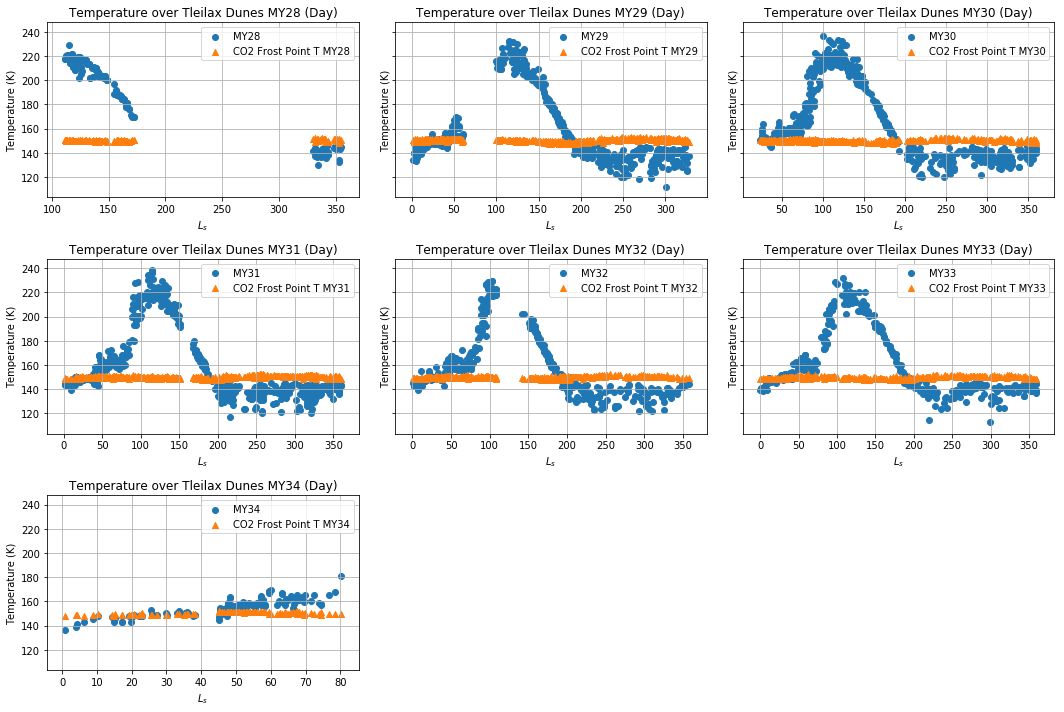

In [98]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesDayMY28['L_s'], Tleilax_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Tleilax_CO2Day28['L_s'],Tleilax_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY28 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesDayMY29['L_s'], Tleilax_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Tleilax_CO2Day29['L_s'],Tleilax_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY29 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesDayMY30['L_s'], Tleilax_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Tleilax_CO2Day30['L_s'],Tleilax_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY30 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesDayMY31['L_s'], Tleilax_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Tleilax_CO2Day31['L_s'],Tleilax_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY31 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesDayMY32['L_s'], Tleilax_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Tleilax_CO2Day32['L_s'],Tleilax_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY32 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesDayMY33['L_s'], Tleilax_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Tleilax_CO2Day33['L_s'],Tleilax_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY33 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesDayMY34['L_s'], Tleilax_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Tleilax_CO2Day34['L_s'],Tleilax_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY34 (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

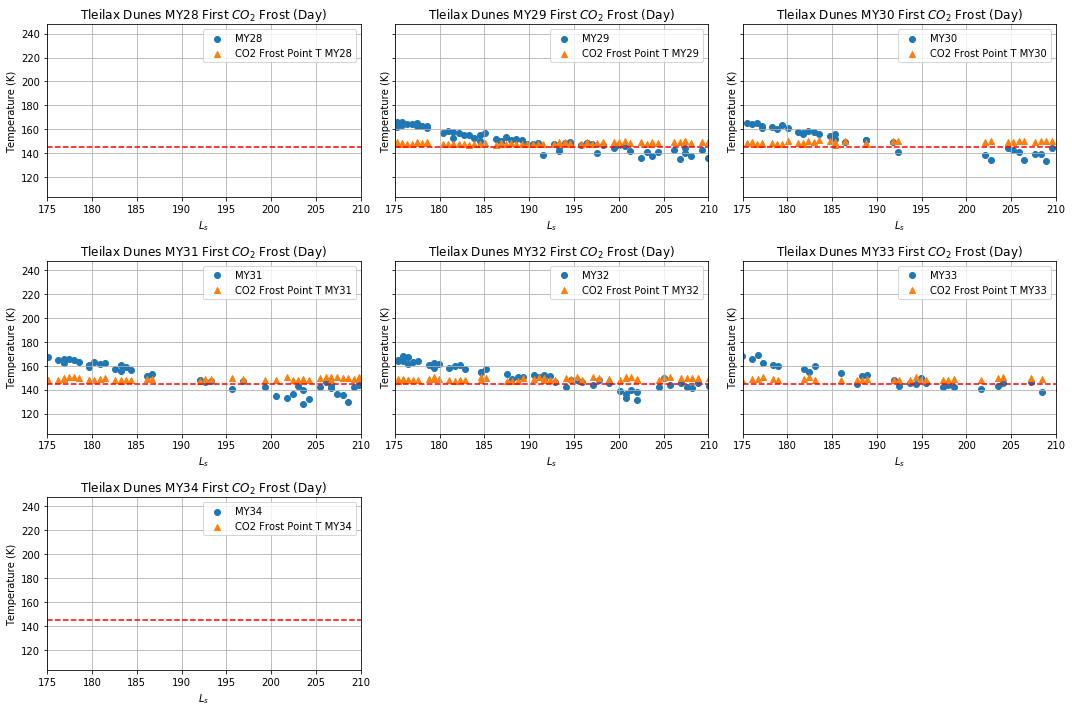

In [516]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesDayMY28['L_s'], Tleilax_SubframesDayMY28['T_surf'], label = 'MY28')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day28['L_s'],Tleilax_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY28 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesDayMY29['L_s'], Tleilax_SubframesDayMY29['T_surf'], label = 'MY29')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day29['L_s'],Tleilax_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY29 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesDayMY30['L_s'], Tleilax_SubframesDayMY30['T_surf'], label = 'MY30')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day30['L_s'],Tleilax_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY30 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesDayMY31['L_s'], Tleilax_SubframesDayMY31['T_surf'], label = 'MY31')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day31['L_s'],Tleilax_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY31 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesDayMY32['L_s'], Tleilax_SubframesDayMY32['T_surf'], label = 'MY32')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day32['L_s'],Tleilax_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY32 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesDayMY33['L_s'], Tleilax_SubframesDayMY33['T_surf'], label = 'MY33')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day33['L_s'],Tleilax_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY33 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesDayMY34['L_s'], Tleilax_SubframesDayMY34['T_surf'], label = 'MY34')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day34['L_s'],Tleilax_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY34 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

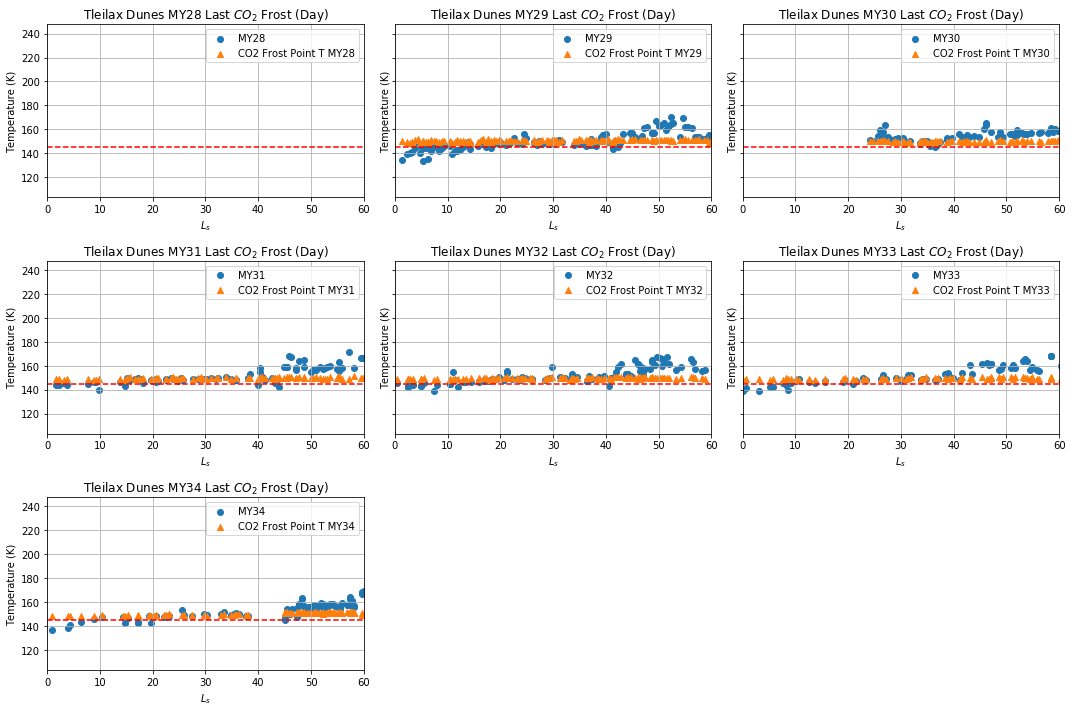

In [465]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesDayMY28['L_s'], Tleilax_SubframesDayMY28['T_surf'], label = 'MY28')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day28['L_s'],Tleilax_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY28 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesDayMY29['L_s'], Tleilax_SubframesDayMY29['T_surf'], label = 'MY29')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day29['L_s'],Tleilax_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY29 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesDayMY30['L_s'], Tleilax_SubframesDayMY30['T_surf'], label = 'MY30')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day30['L_s'],Tleilax_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY30 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesDayMY31['L_s'], Tleilax_SubframesDayMY31['T_surf'], label = 'MY31')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day31['L_s'],Tleilax_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY31 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesDayMY32['L_s'], Tleilax_SubframesDayMY32['T_surf'], label = 'MY32')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day32['L_s'],Tleilax_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY32 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesDayMY33['L_s'], Tleilax_SubframesDayMY33['T_surf'], label = 'MY33')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day33['L_s'],Tleilax_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY33 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesDayMY34['L_s'], Tleilax_SubframesDayMY34['T_surf'], label = 'MY34')
plt.xlim(0.0, 60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Day34['L_s'],Tleilax_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY34 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

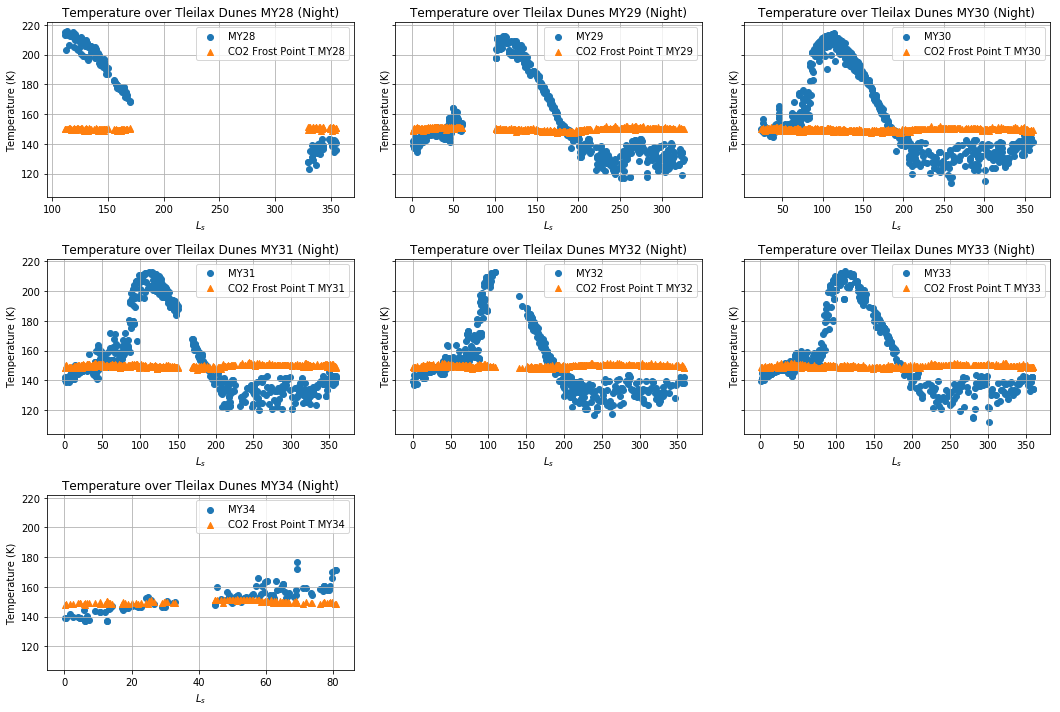

In [100]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesNightMY28['L_s'], Tleilax_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Tleilax_CO2Night28['L_s'],Tleilax_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY28 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesNightMY29['L_s'], Tleilax_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Tleilax_CO2Night29['L_s'],Tleilax_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY29 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesNightMY30['L_s'], Tleilax_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Tleilax_CO2Night30['L_s'],Tleilax_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY30 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesNightMY31['L_s'], Tleilax_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Tleilax_CO2Night31['L_s'],Tleilax_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY31 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesNightMY32['L_s'], Tleilax_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Tleilax_CO2Night32['L_s'],Tleilax_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY32 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesNightMY33['L_s'], Tleilax_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Tleilax_CO2Night33['L_s'],Tleilax_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY33 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesNightMY34['L_s'], Tleilax_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Tleilax_CO2Night34['L_s'],Tleilax_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY34 (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

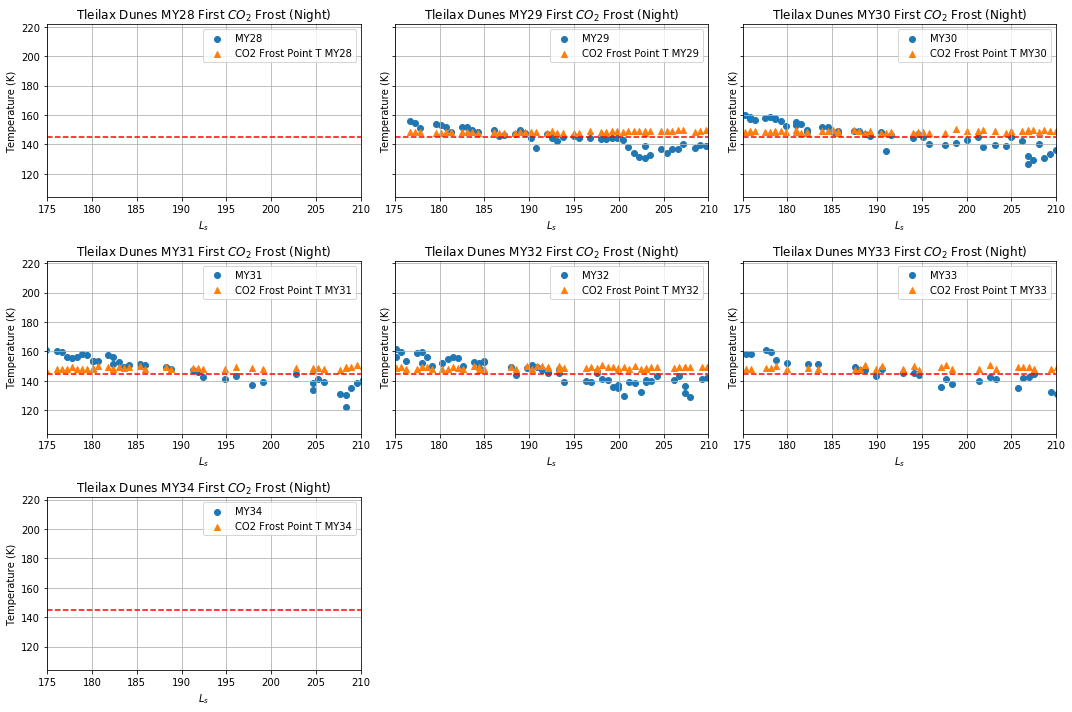

In [515]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesNightMY28['L_s'], Tleilax_SubframesNightMY28['T_surf'], label = 'MY28')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night28['L_s'],Tleilax_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY28 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesNightMY29['L_s'], Tleilax_SubframesNightMY29['T_surf'], label = 'MY29')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night29['L_s'],Tleilax_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY29 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesNightMY30['L_s'], Tleilax_SubframesNightMY30['T_surf'], label = 'MY30')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night30['L_s'],Tleilax_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY30 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesNightMY31['L_s'], Tleilax_SubframesNightMY31['T_surf'], label = 'MY31')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night31['L_s'],Tleilax_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY31 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesNightMY32['L_s'], Tleilax_SubframesNightMY32['T_surf'], label = 'MY32')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night32['L_s'],Tleilax_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY32 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesNightMY33['L_s'], Tleilax_SubframesNightMY33['T_surf'], label = 'MY33')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night33['L_s'],Tleilax_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY33 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesNightMY34['L_s'], Tleilax_SubframesNightMY34['T_surf'], label = 'MY34')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night34['L_s'],Tleilax_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY34 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

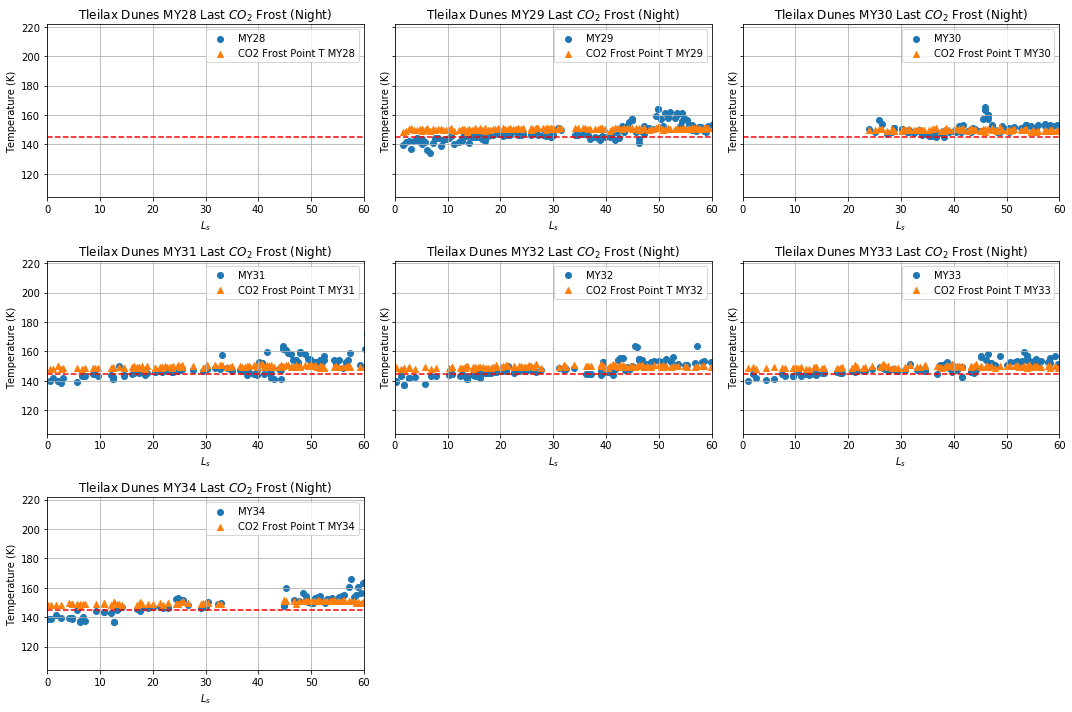

In [467]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesNightMY28['L_s'], Tleilax_SubframesNightMY28['T_surf'], label = 'MY28')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night28['L_s'],Tleilax_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY28 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesNightMY29['L_s'], Tleilax_SubframesNightMY29['T_surf'], label = 'MY29')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night29['L_s'],Tleilax_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY29 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesNightMY30['L_s'], Tleilax_SubframesNightMY30['T_surf'], label = 'MY30')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night30['L_s'],Tleilax_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY30 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesNightMY31['L_s'], Tleilax_SubframesNightMY31['T_surf'], label = 'MY31')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night31['L_s'],Tleilax_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY31 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesNightMY32['L_s'], Tleilax_SubframesNightMY32['T_surf'], label = 'MY32')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night32['L_s'],Tleilax_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY32 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesNightMY33['L_s'], Tleilax_SubframesNightMY33['T_surf'], label = 'MY33')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night33['L_s'],Tleilax_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY33 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesNightMY34['L_s'], Tleilax_SubframesNightMY34['T_surf'], label = 'MY34')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Tleilax_CO2Night34['L_s'],Tleilax_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Tleilax Dunes MY34 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [468]:
TleilaxFFDayMY29 = Tleilax_SubframesDayMY29[(Tleilax_SubframesDayMY29['L_s'] >= 175) & (Tleilax_SubframesDayMY29['L_s']<=210)]
TleilaxFFDayMY30 = Tleilax_SubframesDayMY30[(Tleilax_SubframesDayMY30['L_s'] >= 175) & (Tleilax_SubframesDayMY30['L_s']<=210)]
TleilaxFFDayMY31 = Tleilax_SubframesDayMY31[(Tleilax_SubframesDayMY31['L_s'] >= 175) & (Tleilax_SubframesDayMY31['L_s']<=210)]
TleilaxFFDayMY32 = Tleilax_SubframesDayMY32[(Tleilax_SubframesDayMY32['L_s'] >= 175) & (Tleilax_SubframesDayMY32['L_s']<=210)]
TleilaxFFDayMY33 = Tleilax_SubframesDayMY33[(Tleilax_SubframesDayMY33['L_s'] >= 175) & (Tleilax_SubframesDayMY33['L_s']<=210)]

TleilaxFFNightMY29 = Tleilax_SubframesNightMY29[(Tleilax_SubframesNightMY29['L_s'] >= 175) & (Tleilax_SubframesNightMY29['L_s']<=210)]
TleilaxFFNightMY30 = Tleilax_SubframesNightMY30[(Tleilax_SubframesNightMY30['L_s'] >= 175) & (Tleilax_SubframesNightMY30['L_s']<=210)]
TleilaxFFNightMY31 = Tleilax_SubframesNightMY31[(Tleilax_SubframesNightMY31['L_s'] >= 175) & (Tleilax_SubframesNightMY31['L_s']<=210)]
TleilaxFFNightMY32 = Tleilax_SubframesNightMY32[(Tleilax_SubframesNightMY32['L_s'] >= 175) & (Tleilax_SubframesNightMY32['L_s']<=210)]
TleilaxFFNightMY33 = Tleilax_SubframesNightMY33[(Tleilax_SubframesNightMY33['L_s'] >= 175) & (Tleilax_SubframesNightMY33['L_s']<=210)]

In [469]:
TleilaxFFDNetT29 = TleilaxFFDayMY29['T_surf'] - TleilaxFFDayMY29['Frost_T']
TleilaxFFDNetT30 = TleilaxFFDayMY30['T_surf'] - TleilaxFFDayMY30['Frost_T']
TleilaxFFDNetT31 = TleilaxFFDayMY31['T_surf'] - TleilaxFFDayMY31['Frost_T']
TleilaxFFDNetT32 = TleilaxFFDayMY32['T_surf'] - TleilaxFFDayMY32['Frost_T']
TleilaxFFDNetT33 = TleilaxFFDayMY33['T_surf'] - TleilaxFFDayMY33['Frost_T']

TleilaxFFNNetT29 = TleilaxFFNightMY29['T_surf'] - TleilaxFFNightMY29['Frost_T']
TleilaxFFNNetT30 = TleilaxFFNightMY30['T_surf'] - TleilaxFFNightMY30['Frost_T']
TleilaxFFNNetT31 = TleilaxFFNightMY31['T_surf'] - TleilaxFFNightMY31['Frost_T']
TleilaxFFNNetT32 = TleilaxFFNightMY32['T_surf'] - TleilaxFFNightMY32['Frost_T']
TleilaxFFNNetT33 = TleilaxFFNightMY33['T_surf'] - TleilaxFFNightMY33['Frost_T']

LsTFD29= np.linspace(175,210,len(TleilaxFFDNetT29))
LsTFD30= np.linspace(175,210,len(TleilaxFFDNetT30))
LsTFD31= np.linspace(175,210,len(TleilaxFFDNetT31))
LsTFD32= np.linspace(175,210,len(TleilaxFFDNetT32))
LsTFD33= np.linspace(175,210,len(TleilaxFFDNetT33))

LsTFN29= np.linspace(175,210,len(TleilaxFFNNetT29))
LsTFN30= np.linspace(175,210,len(TleilaxFFNNetT30))
LsTFN31= np.linspace(175,210,len(TleilaxFFNNetT31))
LsTFN32= np.linspace(175,210,len(TleilaxFFNNetT32))
LsTFN33= np.linspace(175,210,len(TleilaxFFNNetT33))

In [470]:
TFDcoe29, TFDcov29 =np.polyfit(LsTFD29,TleilaxFFDNetT29, 1, cov=True)
TFDcoe30, TFDcov30 =np.polyfit(LsTFD30,TleilaxFFDNetT30, 1, cov=True)
TFDcoe31, TFDcov31 =np.polyfit(LsTFD31,TleilaxFFDNetT31, 1, cov=True)
TFDcoe32, TFDcov32 =np.polyfit(LsTFD32,TleilaxFFDNetT32, 1, cov=True)
TFDcoe33, TFDcov33 =np.polyfit(LsTFD33,TleilaxFFDNetT33, 1, cov=True)


TFNcoe29, TFNcov29 =np.polyfit(LsTFN29,TleilaxFFNNetT29, 1, cov=True)
TFNcoe30, TFNcov30 =np.polyfit(LsTFN30,TleilaxFFNNetT30, 1, cov=True)
TFNcoe31, TFNcov31 =np.polyfit(LsTFN31,TleilaxFFNNetT31, 1, cov=True)
TFNcoe32, TFNcov32 =np.polyfit(LsTFN32,TleilaxFFNNetT32, 1, cov=True)
TFNcoe33, TFNcov33 =np.polyfit(LsTFN33,TleilaxFFNNetT33, 1, cov=True)

In [471]:
TFD29Err=xerr(TFDcoe29[0],TFDcoe29[1],TFDcov29)
TFD30Err=xerr(TFDcoe30[0],TFDcoe30[1],TFDcov30)
TFD31Err=xerr(TFDcoe31[0],TFDcoe31[1],TFDcov31)
TFD32Err=xerr(TFDcoe32[0],TFDcoe32[1],TFDcov32)
TFD33Err=xerr(TFDcoe33[0],TFDcoe33[1],TFDcov33)

TFN29Err=xerr(TFNcoe29[0],TFNcoe29[1],TFNcov29)
TFN30Err=xerr(TFNcoe30[0],TFNcoe30[1],TFNcov30)
TFN31Err=xerr(TFNcoe31[0],TFNcoe31[1],TFNcov31)
TFN32Err=xerr(TFNcoe32[0],TFNcoe32[1],TFNcov32)
TFN33Err=xerr(TFNcoe33[0],TFNcoe33[1],TFNcov33)

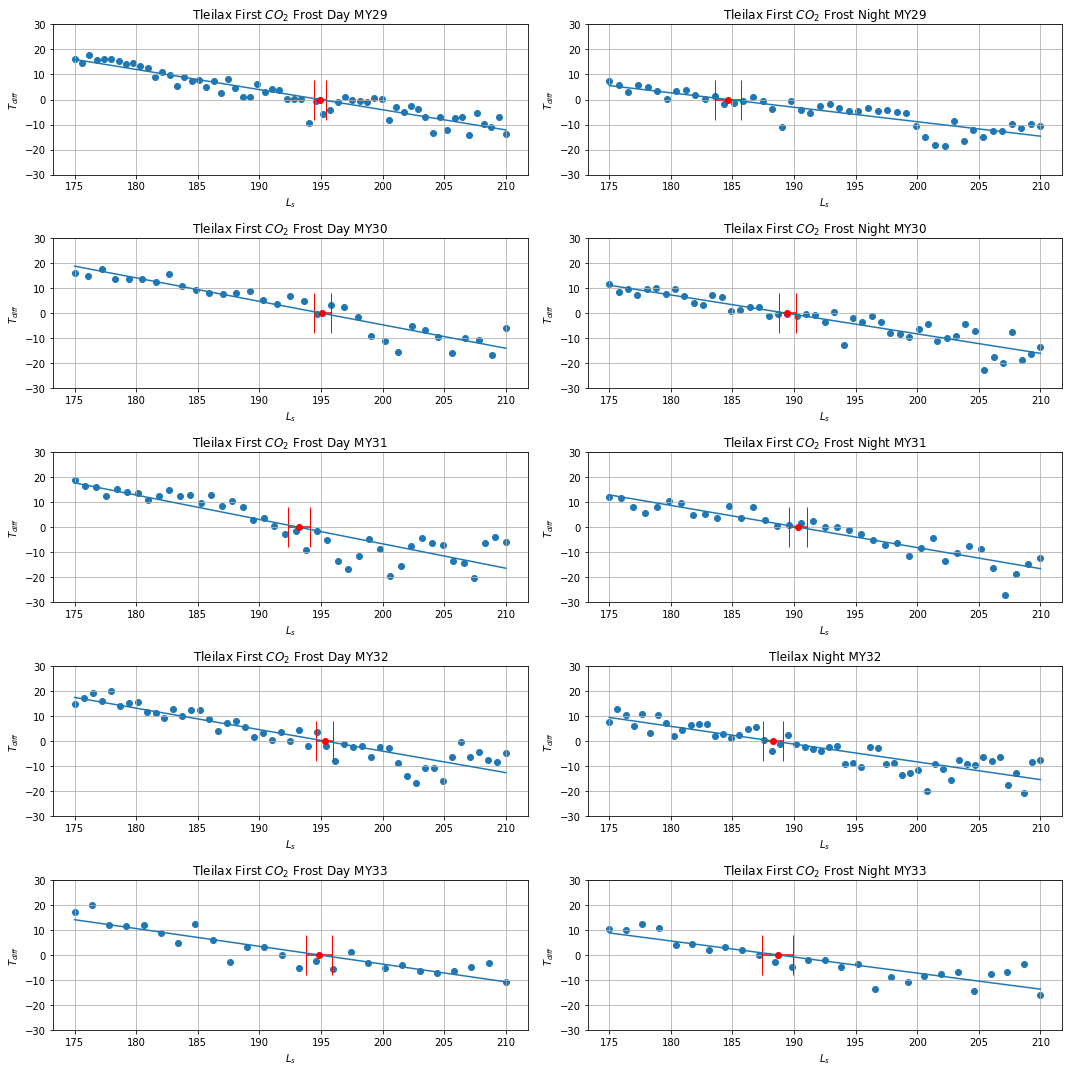

In [557]:
fig, axes = plt.subplots(5,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsTFD29,TleilaxFFDNetT29)
plt.errorbar(TFD29Err[0],0,xerr=TFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFD29,TFDcoe29[1]+TFDcoe29[0]*LsTFD29)
plt.title('Tleilax First $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsTFN29,TleilaxFFNNetT29)
plt.errorbar(TFN29Err[0],0,xerr=TFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFN29,TFNcoe29[1]+TFNcoe29[0]*LsTFN29)
plt.title('Tleilax First $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsTFD30,TleilaxFFDNetT30)
plt.errorbar(TFD30Err[0],0,xerr=TFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFD30,TFDcoe30[1]+TFDcoe30[0]*LsTFD30)
plt.title('Tleilax First $CO_2$ Frost Day MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsTFN30,TleilaxFFNNetT30)
plt.errorbar(TFN30Err[0],0,xerr=TFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFN30,TFNcoe30[1]+TFNcoe30[0]*LsTFN30)
plt.title('Tleilax First $CO_2$ Frost Night MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsTFD31,TleilaxFFDNetT31)
plt.errorbar(TFD31Err[0],0,xerr=TFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFD31,TFDcoe31[1]+TFDcoe31[0]*LsTFD31)
plt.title('Tleilax First $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsTFN31,TleilaxFFNNetT31)
plt.errorbar(TFN31Err[0],0,xerr=TFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFN31,TFNcoe31[1]+TFNcoe31[0]*LsTFN31)
plt.title('Tleilax First $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsTFD32,TleilaxFFDNetT32)
plt.errorbar(TFD32Err[0],0,xerr=TFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFD32,TFDcoe32[1]+TFDcoe32[0]*LsTFD32)
plt.title('Tleilax First $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsTFN32,TleilaxFFNNetT32)
plt.errorbar(TFN32Err[0],0,xerr=TFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFN32,TFNcoe32[1]+TFNcoe32[0]*LsTFN32)
plt.title('Tleilax Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsTFD33,TleilaxFFDNetT33)
plt.errorbar(TFD33Err[0],0,xerr=TFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFD33,TFDcoe33[1]+TFDcoe33[0]*LsTFD33)
plt.title('Tleilax First $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsTFN33,TleilaxFFNNetT33)
plt.errorbar(TFN33Err[0],0,xerr=TFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTFN33,TFNcoe33[1]+TFNcoe33[0]*LsTFN33)
plt.title('Tleilax First $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

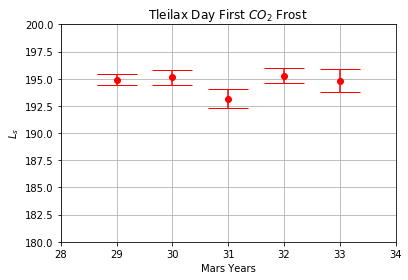

In [474]:
MY = np.linspace(28,33,6)
plt.errorbar(29,TFD29Err[0],yerr=TFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,TFD30Err[0],yerr=TFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,TFD31Err[0],yerr=TFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,TFD32Err[0],yerr=TFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,TFD33Err[0],yerr=TFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Tleilax Day First $CO_2$ Frost')
plt.ylim(180,200)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

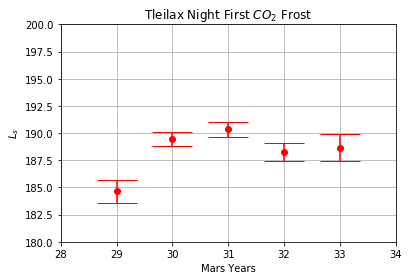

In [476]:
MY = np.linspace(28,33,6)
plt.errorbar(29,TFN29Err[0],yerr=TFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,TFN30Err[0],yerr=TFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,TFN31Err[0],yerr=TFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,TFN32Err[0],yerr=TFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,TFN33Err[0],yerr=TFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Tleilax Night First $CO_2$ Frost')
plt.ylim(180,200)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

In [479]:
newTleilax30ADFD = Tleilax_SubframesDayMY29.copy()
newTleilax30ADFD['L_s'] = (Tleilax_SubframesDayMY29['L_s'] -360)
Tleilax30ADFD = newTleilax30ADFD[(newTleilax30ADFD['L_s'] > -60.0)]

In [480]:
newTleilax30BDF = Tleilax_SubframesDayMY30.copy()
Tleilax30BDFD = newTleilax30BDF[(newTleilax30BDF['L_s'] < 60.0)]

In [481]:
Tleilax30DFD = Tleilax30ADFD.append(Tleilax30BDFD)

In [482]:
newTleilax30ADFN = Tleilax_SubframesNightMY29.copy()
newTleilax30ADFN['L_s'] = (Tleilax_SubframesNightMY29['L_s'] -360)
Tleilax30ADFN = newTleilax30ADFN[(newTleilax30ADFN['L_s'] > -60.0)]

In [483]:
newTleilax30BDF = Tleilax_SubframesNightMY30.copy()
Tleilax30BDFN = newTleilax30BDF[(newTleilax30BDF['L_s'] < 60.0)]

In [484]:
Tleilax30DFN = Tleilax30ADFN.append(Tleilax30BDFN)

In [486]:
TleilaxLFDayMY29 = Tleilax_SubframesDayMY29[(Tleilax_SubframesDayMY29['L_s'] >= 0.0) & (Tleilax_SubframesDayMY29['L_s']<=60.0)]
TleilaxLFDayMY30 = Tleilax_SubframesDayMY30[(Tleilax_SubframesDayMY30['L_s'] >= 0.0) & (Tleilax_SubframesDayMY30['L_s']<=60.0)]
TleilaxLFDayMY31 = Tleilax_SubframesDayMY31[(Tleilax_SubframesDayMY31['L_s'] >= 0.0) & (Tleilax_SubframesDayMY31['L_s']<=60.0)]
TleilaxLFDayMY32 = Tleilax_SubframesDayMY32[(Tleilax_SubframesDayMY32['L_s'] >= 0.0) & (Tleilax_SubframesDayMY32['L_s']<=60.0)]
TleilaxLFDayMY33 = Tleilax_SubframesDayMY33[(Tleilax_SubframesDayMY33['L_s'] >= 0.0) & (Tleilax_SubframesDayMY33['L_s']<=60.0)]
TleilaxLFDayMY34 = Tleilax_SubframesDayMY34[(Tleilax_SubframesDayMY34['L_s'] >= 0.0) & (Tleilax_SubframesDayMY34['L_s']<=60.0)]

TleilaxLFNightMY29 = Tleilax_SubframesNightMY29[(Tleilax_SubframesNightMY29['L_s'] >= 0.0) & (Tleilax_SubframesNightMY29['L_s']<=60.0)]
TleilaxLFNightMY30 = Tleilax_SubframesNightMY30[(Tleilax_SubframesNightMY30['L_s'] >= 0.0) & (Tleilax_SubframesNightMY30['L_s']<=60.0)]
TleilaxLFNightMY31 = Tleilax_SubframesNightMY31[(Tleilax_SubframesNightMY31['L_s'] >= 0.0) & (Tleilax_SubframesNightMY31['L_s']<=60.0)]
TleilaxLFNightMY32 = Tleilax_SubframesNightMY32[(Tleilax_SubframesNightMY32['L_s'] >= 0.0) & (Tleilax_SubframesNightMY32['L_s']<=60.0)]
TleilaxLFNightMY33 = Tleilax_SubframesNightMY33[(Tleilax_SubframesNightMY33['L_s'] >= 0.0) & (Tleilax_SubframesNightMY33['L_s']<=60.0)]
TleilaxLFNightMY34 = Tleilax_SubframesNightMY34[(Tleilax_SubframesNightMY34['L_s'] >= 0.0) & (Tleilax_SubframesNightMY34['L_s']<=60.0)]

In [487]:
TleilaxLFDNetT29 = TleilaxLFDayMY29['T_surf'] - TleilaxLFDayMY29['Frost_T']
TleilaxLFDNetT30 = Tleilax30DFD['T_surf'] - Tleilax30DFD['Frost_T']
TleilaxLFDNetT31 = TleilaxLFDayMY31['T_surf'] - TleilaxLFDayMY31['Frost_T']
TleilaxLFDNetT32 = TleilaxLFDayMY32['T_surf'] - TleilaxLFDayMY32['Frost_T']
TleilaxLFDNetT33 = TleilaxLFDayMY33['T_surf'] - TleilaxLFDayMY33['Frost_T']
TleilaxLFDNetT34 = TleilaxLFDayMY34['T_surf'] - TleilaxLFDayMY34['Frost_T']

TleilaxLFNNetT29 = TleilaxLFNightMY29['T_surf'] - TleilaxLFNightMY29['Frost_T']
TleilaxLFNNetT30 = Tleilax30DFN['T_surf'] - Tleilax30DFN['Frost_T']
TleilaxLFNNetT31 = TleilaxLFNightMY31['T_surf'] - TleilaxLFNightMY31['Frost_T']
TleilaxLFNNetT32 = TleilaxLFNightMY32['T_surf'] - TleilaxLFNightMY32['Frost_T']
TleilaxLFNNetT33 = TleilaxLFNightMY33['T_surf'] - TleilaxLFNightMY33['Frost_T']
TleilaxLFNNetT34 = TleilaxLFNightMY34['T_surf'] - TleilaxLFNightMY34['Frost_T']

LsTLD29= np.linspace(0.0,60.0,len(TleilaxLFDNetT29))
LsTLD30= np.array(Tleilax30DFD['L_s'])
LsTLD31= np.linspace(0.0,60.0,len(TleilaxLFDNetT31))
LsTLD32= np.linspace(0.0,60.0,len(TleilaxLFDNetT32))
LsTLD33= np.linspace(0.0,60.0,len(TleilaxLFDNetT33))
LsTLD34= np.linspace(0.0,60.0,len(TleilaxLFDNetT34))

LsTLN29= np.linspace(0.0,60.0,len(TleilaxLFNNetT29))
LsTLN30= np.array(Tleilax30DFN['L_s'])
LsTLN31= np.linspace(0.0,60.0,len(TleilaxLFNNetT31))
LsTLN32= np.linspace(0.0,60.0,len(TleilaxLFNNetT32))
LsTLN33= np.linspace(0.0,60.0,len(TleilaxLFNNetT33))
LsTLN34= np.linspace(0.0,60.0,len(TleilaxLFNNetT34))

In [488]:
TLDcoe29, TLDcov29 =np.polyfit(LsTLD29,TleilaxLFDNetT29, 1, cov=True)
TLDcoe30, TLDcov30 =np.polyfit(LsTLD30,TleilaxLFDNetT30, 1, cov=True)
TLDcoe31, TLDcov31 =np.polyfit(LsTLD31,TleilaxLFDNetT31, 1, cov=True)
TLDcoe32, TLDcov32 =np.polyfit(LsTLD32,TleilaxLFDNetT32, 1, cov=True)
TLDcoe33, TLDcov33 =np.polyfit(LsTLD33,TleilaxLFDNetT33, 1, cov=True)
TLDcoe34, TLDcov34 =np.polyfit(LsTLD34,TleilaxLFDNetT34, 1, cov=True)


TLNcoe29, TLNcov29 =np.polyfit(LsTLN29,TleilaxLFNNetT29, 1, cov=True)
TLNcoe30, TLNcov30 =np.polyfit(LsTLN30,TleilaxLFNNetT30, 1, cov=True)
TLNcoe31, TLNcov31 =np.polyfit(LsTLN31,TleilaxLFNNetT31, 1, cov=True)
TLNcoe32, TLNcov32 =np.polyfit(LsTLN32,TleilaxLFNNetT32, 1, cov=True)
TLNcoe33, TLNcov33 =np.polyfit(LsTLN33,TleilaxLFNNetT33, 1, cov=True)
TLNcoe34, TLNcov34 =np.polyfit(LsTLN34,TleilaxLFNNetT34, 1, cov=True)

In [489]:
TLD29Err=xerr(TLDcoe29[0],TLDcoe29[1],TLDcov29)
TLD30Err=xerr(TLDcoe30[0],TLDcoe30[1],TLDcov30)
TLD31Err=xerr(TLDcoe31[0],TLDcoe31[1],TLDcov31)
TLD32Err=xerr(TLDcoe32[0],TLDcoe32[1],TLDcov32)
TLD33Err=xerr(TLDcoe33[0],TLDcoe33[1],TLDcov33)
TLD34Err=xerr(TLDcoe34[0],TLDcoe34[1],TLDcov34)

TLN29Err=xerr(TLNcoe29[0],TLNcoe29[1],TLNcov29)
TLN30Err=xerr(TLNcoe30[0],TLNcoe30[1],TLNcov30)
TLN31Err=xerr(TLNcoe31[0],TLNcoe31[1],TLNcov31)
TLN32Err=xerr(TLNcoe32[0],TLNcoe32[1],TLNcov32)
TLN33Err=xerr(TLNcoe33[0],TLNcoe33[1],TLNcov33)
TLN34Err=xerr(TLNcoe34[0],TLNcoe34[1],TLNcov34)

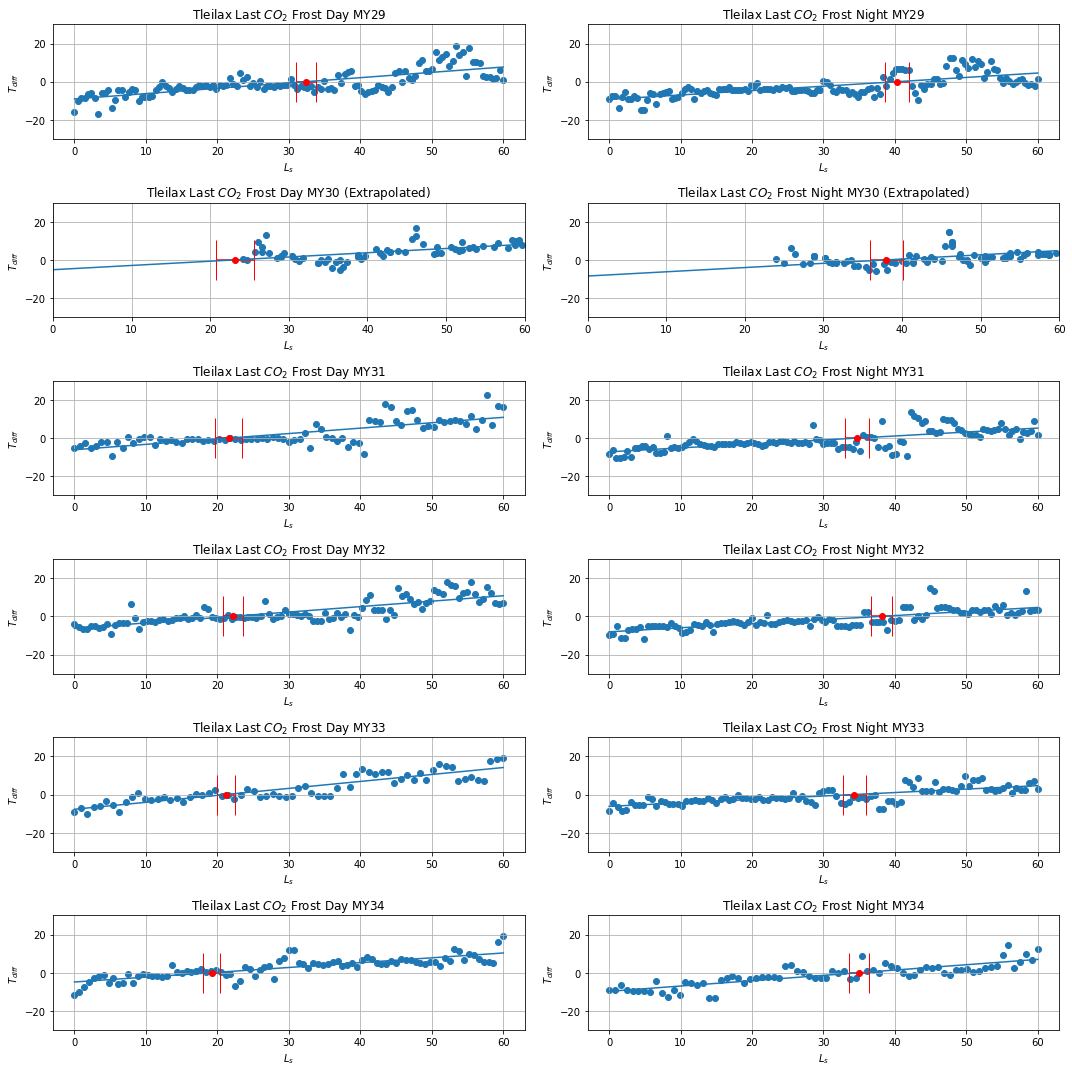

In [563]:
fig, axes = plt.subplots(6,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsTLD29,TleilaxLFDNetT29)
plt.errorbar(TLD29Err[0],0,xerr=TLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLD29,TLDcoe29[1]+TLDcoe29[0]*LsTLD29)
plt.title('Tleilax Last $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsTLN29,TleilaxLFNNetT29)
plt.errorbar(TLN29Err[0],0,xerr=TLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLN29,TLNcoe29[1]+TLNcoe29[0]*LsTLN29)
plt.title('Tleilax Last $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsTLD30,TleilaxLFDNetT30)
plt.errorbar(TLD30Err[0],0,xerr=TLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLD30,TLDcoe30[1]+TLDcoe30[0]*LsTLD30)
plt.title('Tleilax Last $CO_2$ Frost Day MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsTLN30,TleilaxLFNNetT30)
plt.errorbar(TLN30Err[0],0,xerr=TLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLN30,TLNcoe30[1]+TLNcoe30[0]*LsTLN30)
plt.title('Tleilax Last $CO_2$ Frost Night MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsTLD31,TleilaxLFDNetT31)
plt.errorbar(TLD31Err[0],0,xerr=TLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLD31,TLDcoe31[1]+TLDcoe31[0]*LsTLD31)
plt.title('Tleilax Last $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsTLN31,TleilaxLFNNetT31)
plt.errorbar(TLN31Err[0],0,xerr=TLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLN31,TLNcoe31[1]+TLNcoe31[0]*LsTLN31)
plt.title('Tleilax Last $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsTLD32,TleilaxLFDNetT32)
plt.errorbar(TLD32Err[0],0,xerr=TLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLD32,TLDcoe32[1]+TLDcoe32[0]*LsTLD32)
plt.title('Tleilax Last $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsTLN32,TleilaxLFNNetT32)
plt.errorbar(TLN32Err[0],0,xerr=TLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLN32,TLNcoe32[1]+TLNcoe32[0]*LsTLN32)
plt.title('Tleilax Last $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsTLD33,TleilaxLFDNetT33)
plt.errorbar(TLD33Err[0],0,xerr=TLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLD33,TLDcoe33[1]+TLDcoe33[0]*LsTLD33)
plt.title('Tleilax Last $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsTLN33,TleilaxLFNNetT33)
plt.errorbar(TLN33Err[0],0,xerr=TLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLN33,TLNcoe33[1]+TLNcoe33[0]*LsTLN33)
plt.title('Tleilax Last $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,0])
plt.scatter(LsTLD34,TleilaxLFDNetT34)
plt.errorbar(TLD34Err[0],0,xerr=TLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLD34,TLDcoe34[1]+TLDcoe34[0]*LsTLD34)
plt.title('Tleilax Last $CO_2$ Frost Day MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,1])
plt.scatter(LsTLN34,TleilaxLFNNetT34)
plt.errorbar(TLN34Err[0],0,xerr=TLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsTLN34,TLNcoe34[1]+TLNcoe34[0]*LsTLN34)
plt.title('Tleilax Last $CO_2$ Frost Night MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

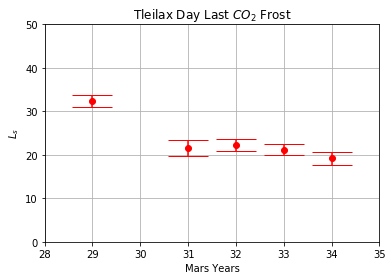

In [491]:
plt.errorbar(29,TLD29Err[0],yerr=TLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,TLD30Err[0],yerr=TLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,TLD31Err[0],yerr=TLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,TLD32Err[0],yerr=TLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,TLD33Err[0],yerr=TLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,TLD34Err[0],yerr=TLD34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Tleilax Day Last $CO_2$ Frost')
plt.ylim(0,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

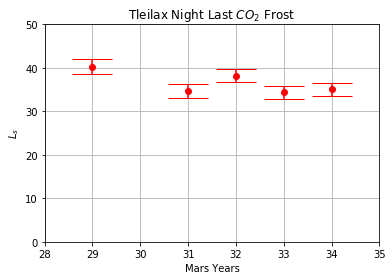

In [495]:
plt.errorbar(29,TLN29Err[0],yerr=TLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,TLN30Err[0],yerr=TLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,TLN31Err[0],yerr=TLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,TLN32Err[0],yerr=TLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,TLN33Err[0],yerr=TLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,TLN34Err[0],yerr=TLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Tleilax Night Last $CO_2$ Frost')
plt.ylim(0,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

### Tleilax 83.5N, 118.6E

We observed that at this location there is a general trend throughout the year that starts with temperatures below the carbon dioxide ($CO_2$) ice condensation point up to Solar Longitude ($L_s$) 50. Afterwards the temperature increases with a sharp slope up to $L_s$ 100 where it reaches its maximum temperature of about 220 kelvin on average. It then then slopes downward with a shallower slope until it reaches $L_s$ 200 where the temperature again reaches the condensation point for $CO_2$ ice to form. Between $L_s$ 200 until $L_s$ 50 of the next year we can see an oscillatory behavior for the temperatures between the values of 120 and 140 kelvin. Tleilax has a very intersting case daily annual temperature variability that will be explained in the notes.

#### Notes

- We see that in Mars year 28 there is a lack of data as well as gap in it. Lack of data is due to the probe having begun its mission in the middle of that Mars year, the other lack of data is due to possible calibrations of MCS.


- We see throughout that there are gaps in data which can possibly be attributed to calibrations.


- We see that in Mars year 34 there is also a lack of data, this is due to the fact that the data set that we obtained ended in the middle of Mars year 34.


- Mars year 30 started with a small deviation from the other years at the beginning, it seems that there is no $CO_2$ condensation given tha all points lie above their condensation temperature


- SUPER IMPORTANT!!!! Just like Kolhar, Tleilax has a great deal of annual variability in temperatures during the day. For Mars year 31 it reaches a 240 kelvin temperature in the summer which 32 and 30 almost reach but not quite. We can also see that Mars years 29, 30 and 32 are much colder in the winter.


- VERY IMPORTANT!!!! We ran the observations initially using a roughly 120x120 km box and obtained the previous results. As we increased the size of these boxes up to roughly 300x300 km, the only thing that changed was the amount of points (increased) for both the day and night plots but the trends remained the same. The other situation that changed was the distribution of points varied more the larger the box i.e. whenever the box size was increased the temperature range increased with it as well.


- ALSO VERY IMPORTANT!!!! During the nighttime Tleilax also seems to have a constant trend each Mars year, the interesting thing about this is that at night, the temperatures seem to be at maximun 215 kelvin with no change from year to year.

In [496]:
Palma = square(76.2, -84.6, size=4, type = 'deg')

In [497]:
Palma_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

Palma_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

Palma_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

Palma_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

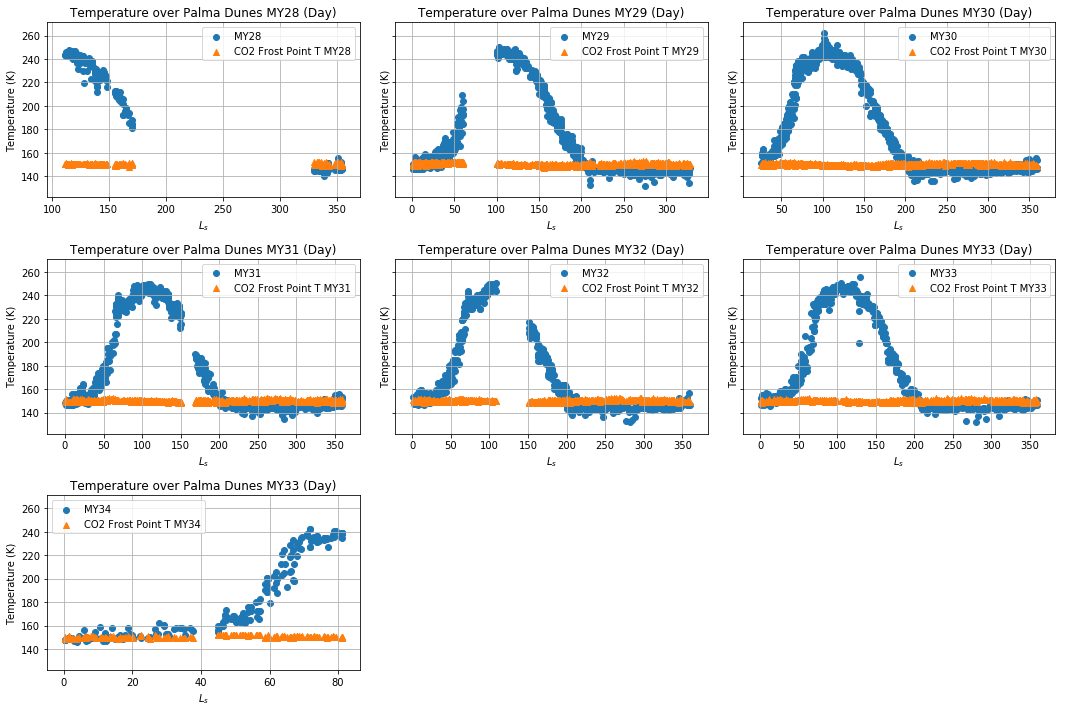

In [510]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesDayMY28['L_s'], Palma_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Palma_CO2Day28['L_s'],Palma_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY28 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesDayMY29['L_s'], Palma_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Palma_CO2Day29['L_s'],Palma_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY29 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesDayMY30['L_s'], Palma_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Palma_CO2Day30['L_s'],Palma_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY30 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesDayMY31['L_s'], Palma_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Palma_CO2Day31['L_s'],Palma_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY31 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesDayMY32['L_s'], Palma_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Palma_CO2Day32['L_s'],Palma_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY32 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesDayMY33['L_s'], Palma_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Palma_CO2Day33['L_s'],Palma_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY33 (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesDayMY34['L_s'], Palma_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Palma_CO2Day34['L_s'],Palma_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY33 (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

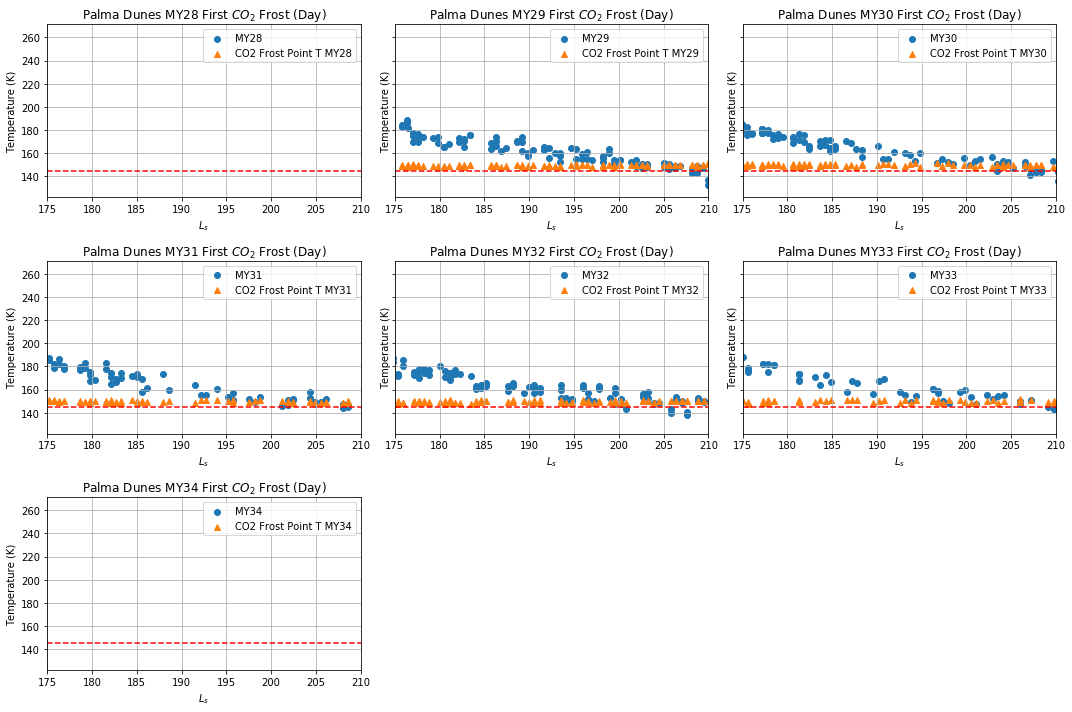

In [513]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesDayMY28['L_s'], Palma_SubframesDayMY28['T_surf'], label = 'MY28')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day28['L_s'],Palma_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY28 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesDayMY29['L_s'], Palma_SubframesDayMY29['T_surf'], label = 'MY29')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day29['L_s'],Palma_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY29 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesDayMY30['L_s'], Palma_SubframesDayMY30['T_surf'], label = 'MY30')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day30['L_s'],Palma_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY30 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesDayMY31['L_s'], Palma_SubframesDayMY31['T_surf'], label = 'MY31')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day31['L_s'],Palma_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY31 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesDayMY32['L_s'], Palma_SubframesDayMY32['T_surf'], label = 'MY32')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day32['L_s'],Palma_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY32 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesDayMY33['L_s'], Palma_SubframesDayMY33['T_surf'], label = 'MY33')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day33['L_s'],Palma_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY33 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesDayMY34['L_s'], Palma_SubframesDayMY34['T_surf'], label = 'MY34')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day34['L_s'],Palma_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY34 First $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

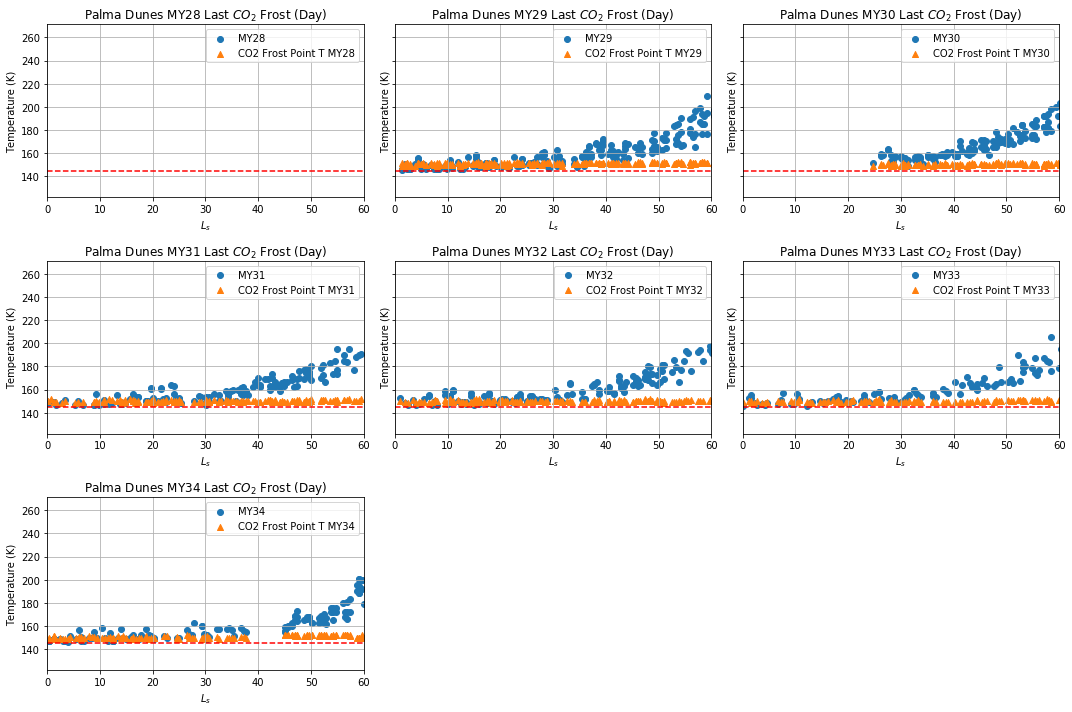

In [514]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesDayMY28['L_s'], Palma_SubframesDayMY28['T_surf'], label = 'MY28')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day28['L_s'],Palma_CO2Day28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY28 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesDayMY29['L_s'], Palma_SubframesDayMY29['T_surf'], label = 'MY29')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day29['L_s'],Palma_CO2Day29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY29 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesDayMY30['L_s'], Palma_SubframesDayMY30['T_surf'], label = 'MY30')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day30['L_s'],Palma_CO2Day30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY30 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesDayMY31['L_s'], Palma_SubframesDayMY31['T_surf'], label = 'MY31')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day31['L_s'],Palma_CO2Day31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY31 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesDayMY32['L_s'], Palma_SubframesDayMY32['T_surf'], label = 'MY32')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day32['L_s'],Palma_CO2Day32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY32 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesDayMY33['L_s'], Palma_SubframesDayMY33['T_surf'], label = 'MY33')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day33['L_s'],Palma_CO2Day33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY33 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesDayMY34['L_s'], Palma_SubframesDayMY34['T_surf'], label = 'MY34')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Day34['L_s'],Palma_CO2Day34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY34 Last $CO_2$ Frost (Day)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

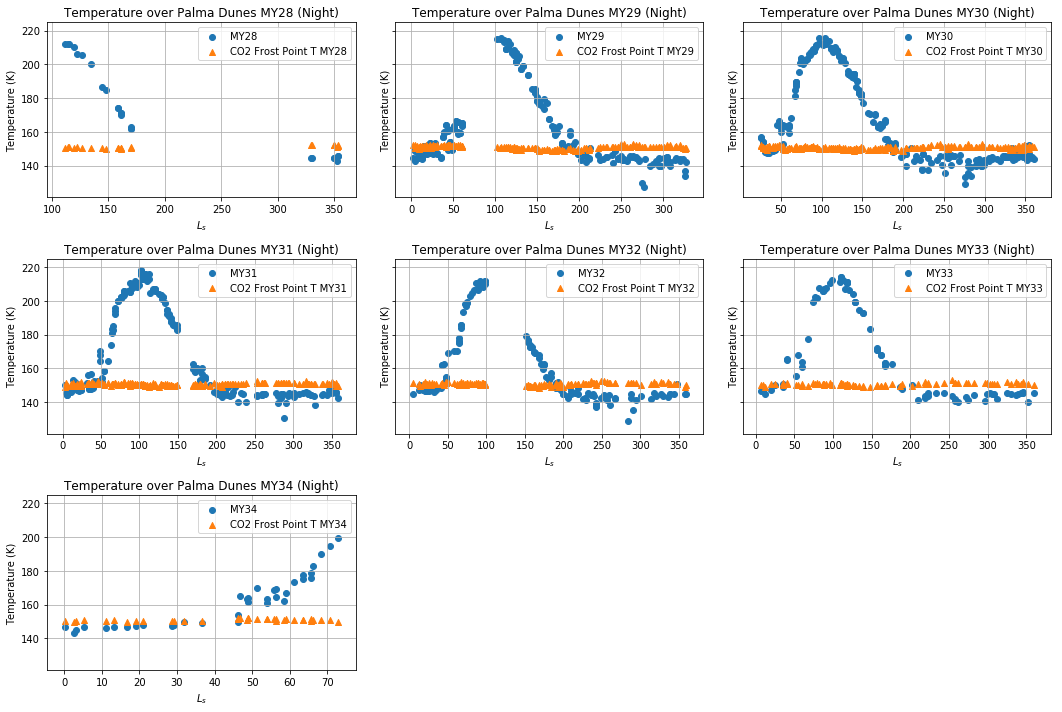

In [111]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesNightMY28['L_s'], Palma_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Palma_CO2Night28['L_s'],Palma_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY28 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesNightMY29['L_s'], Palma_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Palma_CO2Night29['L_s'],Palma_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY29 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesNightMY30['L_s'], Palma_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Palma_CO2Night30['L_s'],Palma_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY30 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesNightMY31['L_s'], Palma_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Palma_CO2Night31['L_s'],Palma_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY31 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesNightMY32['L_s'], Palma_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Palma_CO2Night32['L_s'],Palma_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY32 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesNightMY33['L_s'], Palma_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Palma_CO2Night33['L_s'],Palma_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY33 (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesNightMY34['L_s'], Palma_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Palma_CO2Night34['L_s'],Palma_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY34 (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

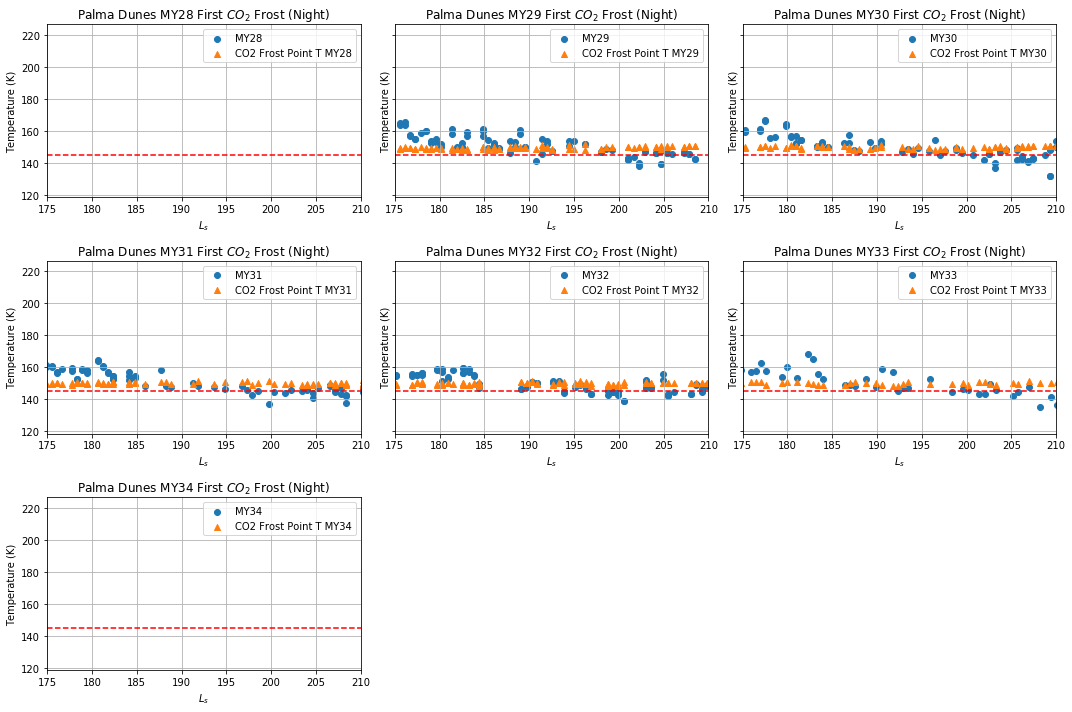

In [521]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesNightMY28['L_s'], Palma_SubframesNightMY28['T_surf'], label = 'MY28')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night28['L_s'],Palma_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY28 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesNightMY29['L_s'], Palma_SubframesNightMY29['T_surf'], label = 'MY29')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night29['L_s'],Palma_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY29 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesNightMY30['L_s'], Palma_SubframesNightMY30['T_surf'], label = 'MY30')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night30['L_s'],Palma_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY30 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesNightMY31['L_s'], Palma_SubframesNightMY31['T_surf'], label = 'MY31')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night31['L_s'],Palma_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY31 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesNightMY32['L_s'], Palma_SubframesNightMY32['T_surf'], label = 'MY32')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night32['L_s'],Palma_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY32 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesNightMY33['L_s'], Palma_SubframesNightMY33['T_surf'], label = 'MY33')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night33['L_s'],Palma_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY33 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesNightMY34['L_s'], Palma_SubframesNightMY34['T_surf'], label = 'MY34')
plt.xlim(175.0,210.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night34['L_s'],Palma_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY34 First $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

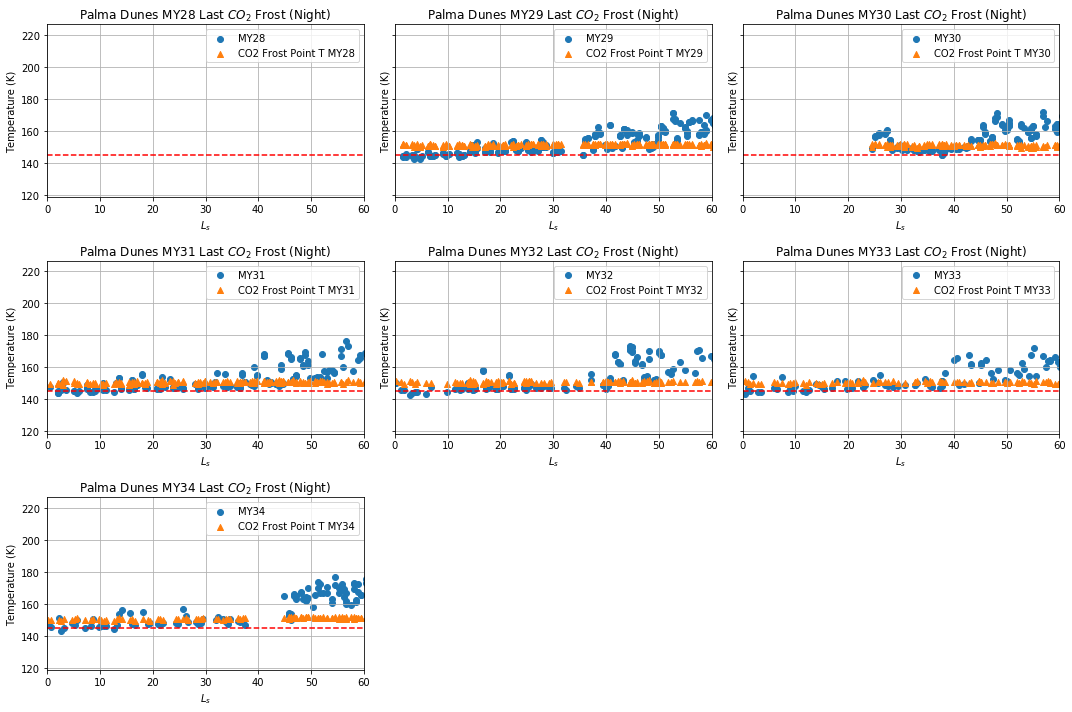

In [522]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesNightMY28['L_s'], Palma_SubframesNightMY28['T_surf'], label = 'MY28')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night28['L_s'],Palma_CO2Night28['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY28 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesNightMY29['L_s'], Palma_SubframesNightMY29['T_surf'], label = 'MY29')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night29['L_s'],Palma_CO2Night29['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY29 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesNightMY30['L_s'], Palma_SubframesNightMY30['T_surf'], label = 'MY30')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night30['L_s'],Palma_CO2Night30['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY30 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesNightMY31['L_s'], Palma_SubframesNightMY31['T_surf'], label = 'MY31')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night31['L_s'],Palma_CO2Night31['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY31 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesNightMY32['L_s'], Palma_SubframesNightMY32['T_surf'], label = 'MY32')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night32['L_s'],Palma_CO2Night32['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY32 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesNightMY33['L_s'], Palma_SubframesNightMY33['T_surf'], label = 'MY33')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night33['L_s'],Palma_CO2Night33['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY33 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesNightMY34['L_s'], Palma_SubframesNightMY34['T_surf'], label = 'MY34')
plt.xlim(0.0,60.0)
plt.axhline(145, color ='r', linestyle='--')
plt.scatter(Palma_CO2Night34['L_s'],Palma_CO2Night34['Frost_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Palma Dunes MY34 Last $CO_2$ Frost (Night)')
plt.grid()
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [539]:
PalmaFFDayMY29 = Palma_SubframesDayMY29[(Palma_SubframesDayMY29['L_s'] >= 175) & (Palma_SubframesDayMY29['L_s']<=210)]
PalmaFFDayMY30 = Palma_SubframesDayMY30[(Palma_SubframesDayMY30['L_s'] >= 175) & (Palma_SubframesDayMY30['L_s']<=210)]
PalmaFFDayMY31 = Palma_SubframesDayMY31[(Palma_SubframesDayMY31['L_s'] >= 175) & (Palma_SubframesDayMY31['L_s']<=210)]
PalmaFFDayMY32 = Palma_SubframesDayMY32[(Palma_SubframesDayMY32['L_s'] >= 175) & (Palma_SubframesDayMY32['L_s']<=210)]
PalmaFFDayMY33 = Palma_SubframesDayMY33[(Palma_SubframesDayMY33['L_s'] >= 175) & (Palma_SubframesDayMY33['L_s']<=210)]

PalmaFFNightMY29 = Palma_SubframesNightMY29[(Palma_SubframesNightMY29['L_s'] >= 175) & (Palma_SubframesNightMY29['L_s']<=210)]
PalmaFFNightMY30 = Palma_SubframesNightMY30[(Palma_SubframesNightMY30['L_s'] >= 175) & (Palma_SubframesNightMY30['L_s']<=210)]
PalmaFFNightMY31 = Palma_SubframesNightMY31[(Palma_SubframesNightMY31['L_s'] >= 175) & (Palma_SubframesNightMY31['L_s']<=210)]
PalmaFFNightMY32 = Palma_SubframesNightMY32[(Palma_SubframesNightMY32['L_s'] >= 175) & (Palma_SubframesNightMY32['L_s']<=210)]
PalmaFFNightMY33 = Palma_SubframesNightMY33[(Palma_SubframesNightMY33['L_s'] >= 175) & (Palma_SubframesNightMY33['L_s']<=210)]

In [540]:
PalmaFFDNetT29 = PalmaFFDayMY29['T_surf'] - PalmaFFDayMY29['Frost_T']
PalmaFFDNetT30 = PalmaFFDayMY30['T_surf'] - PalmaFFDayMY30['Frost_T']
PalmaFFDNetT31 = PalmaFFDayMY31['T_surf'] - PalmaFFDayMY31['Frost_T']
PalmaFFDNetT32 = PalmaFFDayMY32['T_surf'] - PalmaFFDayMY32['Frost_T']
PalmaFFDNetT33 = PalmaFFDayMY33['T_surf'] - PalmaFFDayMY33['Frost_T']

PalmaFFNNetT29 = PalmaFFNightMY29['T_surf'] - PalmaFFNightMY29['Frost_T']
PalmaFFNNetT30 = PalmaFFNightMY30['T_surf'] - PalmaFFNightMY30['Frost_T']
PalmaFFNNetT31 = PalmaFFNightMY31['T_surf'] - PalmaFFNightMY31['Frost_T']
PalmaFFNNetT32 = PalmaFFNightMY32['T_surf'] - PalmaFFNightMY32['Frost_T']
PalmaFFNNetT33 = PalmaFFNightMY33['T_surf'] - PalmaFFNightMY33['Frost_T']

LsPFD29= np.linspace(175,210,len(PalmaFFDNetT29))
LsPFD30= np.linspace(175,210,len(PalmaFFDNetT30))
LsPFD31= np.linspace(175,210,len(PalmaFFDNetT31))
LsPFD32= np.linspace(175,210,len(PalmaFFDNetT32))
LsPFD33= np.linspace(175,210,len(PalmaFFDNetT33))

LsPFN29= np.linspace(175,210,len(PalmaFFNNetT29))
LsPFN30= np.linspace(175,210,len(PalmaFFNNetT30))
LsPFN31= np.linspace(175,210,len(PalmaFFNNetT31))
LsPFN32= np.linspace(175,210,len(PalmaFFNNetT32))
LsPFN33= np.linspace(175,210,len(PalmaFFNNetT33))

In [541]:
PFDcoe29, PFDcov29 =np.polyfit(LsPFD29,PalmaFFDNetT29, 1, cov=True)
PFDcoe30, PFDcov30 =np.polyfit(LsPFD30,PalmaFFDNetT30, 1, cov=True)
PFDcoe31, PFDcov31 =np.polyfit(LsPFD31,PalmaFFDNetT31, 1, cov=True)
PFDcoe32, PFDcov32 =np.polyfit(LsPFD32,PalmaFFDNetT32, 1, cov=True)
PFDcoe33, PFDcov33 =np.polyfit(LsPFD33,PalmaFFDNetT33, 1, cov=True)

PFNcoe29, PFNcov29 =np.polyfit(LsPFN29,PalmaFFNNetT29, 1, cov=True)
PFNcoe30, PFNcov30 =np.polyfit(LsPFN30,PalmaFFNNetT30, 1, cov=True)
PFNcoe31, PFNcov31 =np.polyfit(LsPFN31,PalmaFFNNetT31, 1, cov=True)
PFNcoe32, PFNcov32 =np.polyfit(LsPFN32,PalmaFFNNetT32, 1, cov=True)
PFNcoe33, PFNcov33 =np.polyfit(LsPFN33,PalmaFFNNetT33, 1, cov=True)

In [542]:
PFD29Err=xerr(PFDcoe29[0],PFDcoe29[1],PFDcov29)
PFD30Err=xerr(PFDcoe30[0],PFDcoe30[1],PFDcov30)
PFD31Err=xerr(PFDcoe31[0],PFDcoe31[1],PFDcov31)
PFD32Err=xerr(PFDcoe32[0],PFDcoe32[1],PFDcov32)
PFD33Err=xerr(PFDcoe33[0],PFDcoe33[1],PFDcov33)

PFN29Err=xerr(PFNcoe29[0],PFNcoe29[1],PFNcov29)
PFN30Err=xerr(PFNcoe30[0],PFNcoe30[1],PFNcov30)
PFN31Err=xerr(PFNcoe31[0],PFNcoe31[1],PFNcov31)
PFN32Err=xerr(PFNcoe32[0],PFNcoe32[1],PFNcov32)
PFN33Err=xerr(PFNcoe33[0],PFNcoe33[1],PFNcov33)

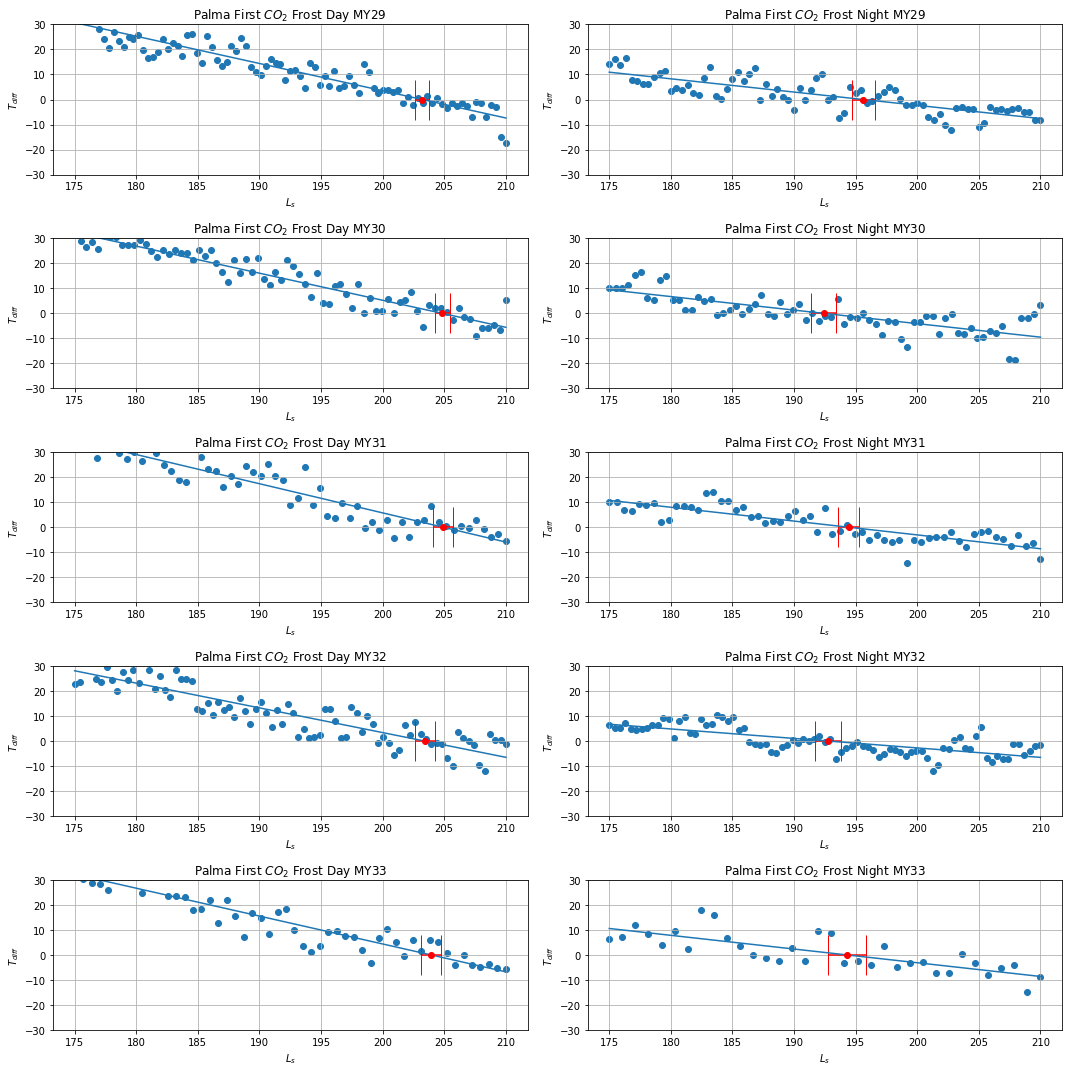

In [543]:
fig, axes = plt.subplots(5,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsPFD29,PalmaFFDNetT29)
plt.errorbar(PFD29Err[0],0,xerr=PFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFD29,PFDcoe29[1]+PFDcoe29[0]*LsPFD29)
plt.title('Palma First $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsPFN29,PalmaFFNNetT29)
plt.errorbar(PFN29Err[0],0,xerr=PFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFN29,PFNcoe29[1]+PFNcoe29[0]*LsPFN29)
plt.title('Palma First $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsPFD30,PalmaFFDNetT30)
plt.errorbar(PFD30Err[0],0,xerr=PFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFD30,PFDcoe30[1]+PFDcoe30[0]*LsPFD30)
plt.title('Palma First $CO_2$ Frost Day MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsPFN30,PalmaFFNNetT30)
plt.errorbar(PFN30Err[0],0,xerr=PFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFN30,PFNcoe30[1]+PFNcoe30[0]*LsPFN30)
plt.title('Palma First $CO_2$ Frost Night MY30')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsPFD31,PalmaFFDNetT31)
plt.errorbar(PFD31Err[0],0,xerr=PFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFD31,PFDcoe31[1]+PFDcoe31[0]*LsPFD31)
plt.title('Palma First $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsPFN31,PalmaFFNNetT31)
plt.errorbar(PFN31Err[0],0,xerr=PFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFN31,PFNcoe31[1]+PFNcoe31[0]*LsPFN31)
plt.title('Palma First $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsPFD32,PalmaFFDNetT32)
plt.errorbar(PFD32Err[0],0,xerr=PFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFD32,PFDcoe32[1]+PFDcoe32[0]*LsPFD32)
plt.title('Palma First $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsPFN32,PalmaFFNNetT32)
plt.errorbar(PFN32Err[0],0,xerr=PFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFN32,PFNcoe32[1]+PFNcoe32[0]*LsPFN32)
plt.title('Palma First $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsPFD33,PalmaFFDNetT33)
plt.errorbar(PFD33Err[0],0,xerr=PFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFD33,PFDcoe33[1]+PFDcoe33[0]*LsPFD33)
plt.title('Palma First $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsPFN33,PalmaFFNNetT33)
plt.errorbar(PFN33Err[0],0,xerr=PFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPFN33,PFNcoe33[1]+PFNcoe33[0]*LsPFN33)
plt.title('Palma First $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

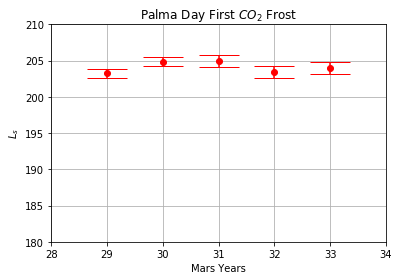

In [546]:
MY = np.linspace(28,33,6)
plt.errorbar(29,PFD29Err[0],yerr=PFD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,PFD30Err[0],yerr=PFD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,PFD31Err[0],yerr=PFD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,PFD32Err[0],yerr=PFD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,PFD33Err[0],yerr=PFD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Palma Day First $CO_2$ Frost')
plt.ylim(180,210)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

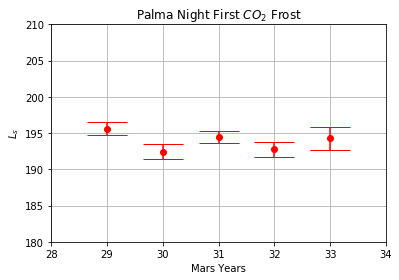

In [547]:
MY = np.linspace(28,33,6)
plt.errorbar(29,PFN29Err[0],yerr=PFN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(30,PFN30Err[0],yerr=PFN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,PFN31Err[0],yerr=PFN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,PFN32Err[0],yerr=PFN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,PFN33Err[0],yerr=PFN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Palma Night First $CO_2$ Frost')
plt.ylim(180,210)
plt.xlim(28,34)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

In [549]:
newPalma30ADFD = Palma_SubframesDayMY29.copy()
newPalma30ADFD['L_s'] = (Palma_SubframesDayMY29['L_s'] -360)
Palma30ADFD = newPalma30ADFD[(newPalma30ADFD['L_s'] > -60.0)]

In [551]:
newPalma30BDF = Palma_SubframesDayMY30.copy()
Palma30BDFD = newPalma30BDF[(newPalma30BDF['L_s'] < 60.0)]

In [552]:
Palma30DFD = Palma30ADFD.append(Palma30BDFD)

In [553]:
newPalma30ADFN = Palma_SubframesNightMY29.copy()
newPalma30ADFN['L_s'] = (Palma_SubframesNightMY29['L_s'] -360)
Palma30ADFN = newPalma30ADFN[(newPalma30ADFN['L_s'] > -60.0)]

In [554]:
newPalma30BDF = Palma_SubframesNightMY30.copy()
Palma30BDFN = newPalma30BDF[(newPalma30BDF['L_s'] < 60.0)]

In [555]:
Palma30DFN = Palma30ADFN.append(Palma30BDFN)

In [556]:
PalmaLFDayMY29 = Palma_SubframesDayMY29[(Palma_SubframesDayMY29['L_s'] >= 0.0) & (Palma_SubframesDayMY29['L_s']<=60.0)]
PalmaLFDayMY30 = Palma_SubframesDayMY30[(Palma_SubframesDayMY30['L_s'] >= 0.0) & (Palma_SubframesDayMY30['L_s']<=60.0)]
PalmaLFDayMY31 = Palma_SubframesDayMY31[(Palma_SubframesDayMY31['L_s'] >= 0.0) & (Palma_SubframesDayMY31['L_s']<=60.0)]
PalmaLFDayMY32 = Palma_SubframesDayMY32[(Palma_SubframesDayMY32['L_s'] >= 0.0) & (Palma_SubframesDayMY32['L_s']<=60.0)]
PalmaLFDayMY33 = Palma_SubframesDayMY33[(Palma_SubframesDayMY33['L_s'] >= 0.0) & (Palma_SubframesDayMY33['L_s']<=60.0)]
PalmaLFDayMY34 = Palma_SubframesDayMY34[(Palma_SubframesDayMY34['L_s'] >= 0.0) & (Palma_SubframesDayMY34['L_s']<=60.0)]

PalmaLFNightMY29 = Palma_SubframesNightMY29[(Palma_SubframesNightMY29['L_s'] >= 0.0) & (Palma_SubframesNightMY29['L_s']<=60.0)]
PalmaLFNightMY30 = Palma_SubframesNightMY30[(Palma_SubframesNightMY30['L_s'] >= 0.0) & (Palma_SubframesNightMY30['L_s']<=60.0)]
PalmaLFNightMY31 = Palma_SubframesNightMY31[(Palma_SubframesNightMY31['L_s'] >= 0.0) & (Palma_SubframesNightMY31['L_s']<=60.0)]
PalmaLFNightMY32 = Palma_SubframesNightMY32[(Palma_SubframesNightMY32['L_s'] >= 0.0) & (Palma_SubframesNightMY32['L_s']<=60.0)]
PalmaLFNightMY33 = Palma_SubframesNightMY33[(Palma_SubframesNightMY33['L_s'] >= 0.0) & (Palma_SubframesNightMY33['L_s']<=60.0)]
PalmaLFNightMY34 = Palma_SubframesNightMY34[(Palma_SubframesNightMY34['L_s'] >= 0.0) & (Palma_SubframesNightMY34['L_s']<=60.0)]

In [560]:
PalmaLFDNetT29 = PalmaLFDayMY29['T_surf'] - PalmaLFDayMY29['Frost_T']
PalmaLFDNetT30 = Palma30DFD['T_surf'] - Palma30DFD['Frost_T']
PalmaLFDNetT31 = PalmaLFDayMY31['T_surf'] - PalmaLFDayMY31['Frost_T']
PalmaLFDNetT32 = PalmaLFDayMY32['T_surf'] - PalmaLFDayMY32['Frost_T']
PalmaLFDNetT33 = PalmaLFDayMY33['T_surf'] - PalmaLFDayMY33['Frost_T']
PalmaLFDNetT34 = PalmaLFDayMY34['T_surf'] - PalmaLFDayMY34['Frost_T']

PalmaLFNNetT29 = PalmaLFNightMY29['T_surf'] - PalmaLFNightMY29['Frost_T']
PalmaLFNNetT30 = Palma30DFN['T_surf'] - Palma30DFN['Frost_T']
PalmaLFNNetT31 = PalmaLFNightMY31['T_surf'] - PalmaLFNightMY31['Frost_T']
PalmaLFNNetT32 = PalmaLFNightMY32['T_surf'] - PalmaLFNightMY32['Frost_T']
PalmaLFNNetT33 = PalmaLFNightMY33['T_surf'] - PalmaLFNightMY33['Frost_T']
PalmaLFNNetT34 = PalmaLFNightMY34['T_surf'] - PalmaLFNightMY34['Frost_T']

LsPLD29= np.linspace(0.0,60.0,len(PalmaLFDNetT29))
LsPLD30= np.array(Palma30DFD['L_s'])
LsPLD31= np.linspace(0.0,60.0,len(PalmaLFDNetT31))
LsPLD32= np.linspace(0.0,60.0,len(PalmaLFDNetT32))
LsPLD33= np.linspace(0.0,60.0,len(PalmaLFDNetT33))
LsPLD34= np.linspace(0.0,60.0,len(PalmaLFDNetT34))

LsPLN29= np.linspace(0.0,60.0,len(PalmaLFNNetT29))
LsPLN30= np.array(Palma30DFN['L_s'])
LsPLN31= np.linspace(0.0,60.0,len(PalmaLFNNetT31))
LsPLN32= np.linspace(0.0,60.0,len(PalmaLFNNetT32))
LsPLN33= np.linspace(0.0,60.0,len(PalmaLFNNetT33))
LsPLN34= np.linspace(0.0,60.0,len(PalmaLFNNetT34))

In [561]:
PLDcoe29, PLDcov29 =np.polyfit(LsPLD29,PalmaLFDNetT29, 1, cov=True)
PLDcoe30, PLDcov30 =np.polyfit(LsPLD30,PalmaLFDNetT30, 1, cov=True)
PLDcoe31, PLDcov31 =np.polyfit(LsPLD31,PalmaLFDNetT31, 1, cov=True)
PLDcoe32, PLDcov32 =np.polyfit(LsPLD32,PalmaLFDNetT32, 1, cov=True)
PLDcoe33, PLDcov33 =np.polyfit(LsPLD33,PalmaLFDNetT33, 1, cov=True)
PLDcoe34, PLDcov34 =np.polyfit(LsPLD34,PalmaLFDNetT34, 1, cov=True)


PLNcoe29, PLNcov29 =np.polyfit(LsPLN29,PalmaLFNNetT29, 1, cov=True)
PLNcoe30, PLNcov30 =np.polyfit(LsPLN30,PalmaLFNNetT30, 1, cov=True)
PLNcoe31, PLNcov31 =np.polyfit(LsPLN31,PalmaLFNNetT31, 1, cov=True)
PLNcoe32, PLNcov32 =np.polyfit(LsPLN32,PalmaLFNNetT32, 1, cov=True)
PLNcoe33, PLNcov33 =np.polyfit(LsPLN33,PalmaLFNNetT33, 1, cov=True)
PLNcoe34, PLNcov34 =np.polyfit(LsPLN34,PalmaLFNNetT34, 1, cov=True)

In [562]:
PLD29Err=xerr(PLDcoe29[0],PLDcoe29[1],PLDcov29)
PLD30Err=xerr(PLDcoe30[0],PLDcoe30[1],PLDcov30)
PLD31Err=xerr(PLDcoe31[0],PLDcoe31[1],PLDcov31)
PLD32Err=xerr(PLDcoe32[0],PLDcoe32[1],PLDcov32)
PLD33Err=xerr(PLDcoe33[0],PLDcoe33[1],PLDcov33)
PLD34Err=xerr(PLDcoe34[0],PLDcoe34[1],PLDcov34)

PLN29Err=xerr(PLNcoe29[0],PLNcoe29[1],PLNcov29)
PLN30Err=xerr(PLNcoe30[0],PLNcoe30[1],PLNcov30)
PLN31Err=xerr(PLNcoe31[0],PLNcoe31[1],PLNcov31)
PLN32Err=xerr(PLNcoe32[0],PLNcoe32[1],PLNcov32)
PLN33Err=xerr(PLNcoe33[0],PLNcoe33[1],PLNcov33)
PLN34Err=xerr(PLNcoe34[0],PLNcoe34[1],PLNcov34)

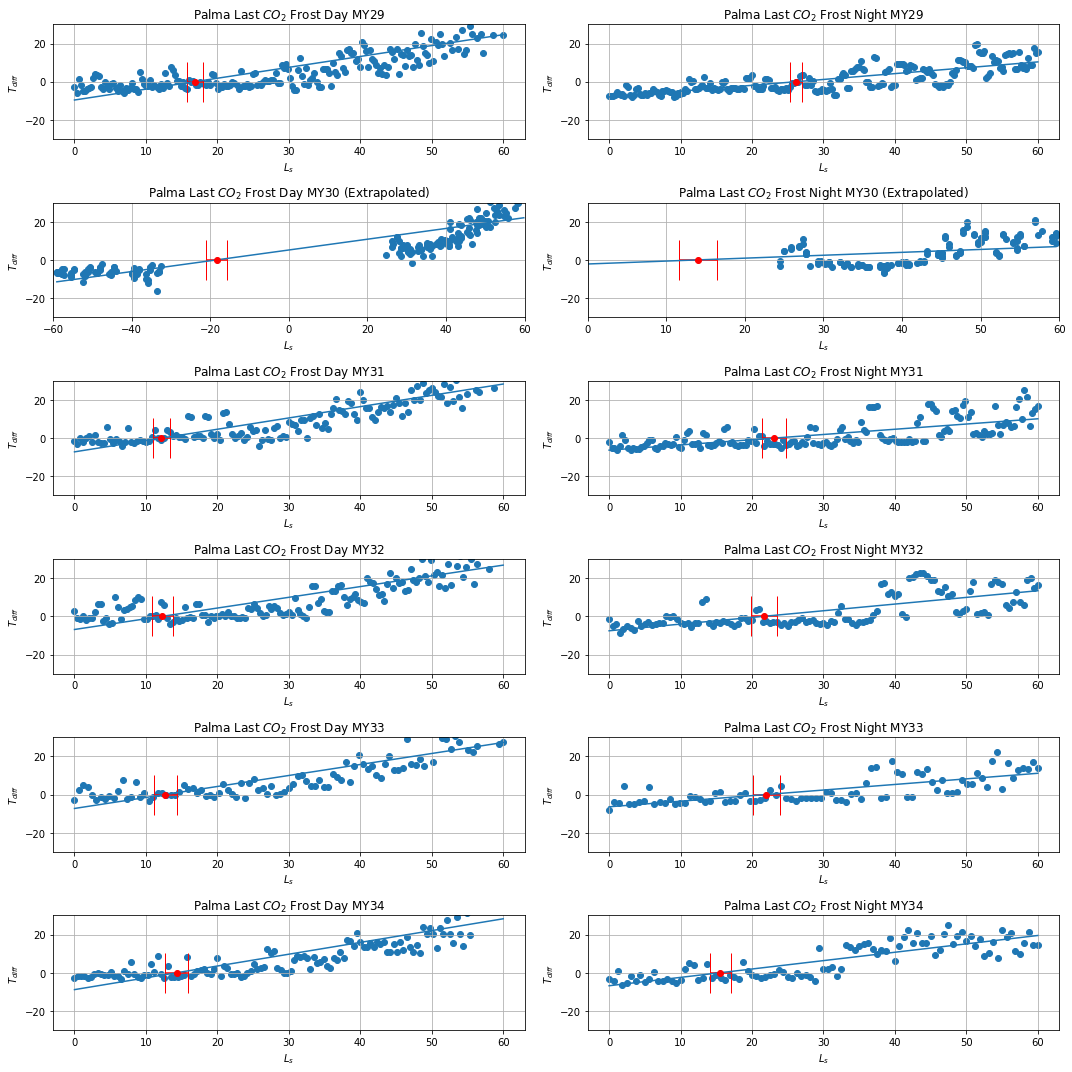

In [565]:
fig, axes = plt.subplots(6,2, sharex = False, sharey = False, figsize= (15,15))
plt.sca(axes[0,0])
plt.scatter(LsPLD29,PalmaLFDNetT29)
plt.errorbar(PLD29Err[0],0,xerr=PLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLD29,PLDcoe29[1]+PLDcoe29[0]*LsPLD29)
plt.title('Palma Last $CO_2$ Frost Day MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[0,1])
plt.scatter(LsPLN29,PalmaLFNNetT29)
plt.errorbar(PLN29Err[0],0,xerr=PLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLN29,PLNcoe29[1]+PLNcoe29[0]*LsPLN29)
plt.title('Palma Last $CO_2$ Frost Night MY29')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,0])
plt.scatter(LsPLD30,PalmaLFDNetT30)
plt.errorbar(PLD30Err[0],0,xerr=PLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLD30,PLDcoe30[1]+PLDcoe30[0]*LsPLD30)
plt.title('Palma Last $CO_2$ Frost Day MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(-60,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[1,1])
plt.scatter(LsPLN30,PalmaLFNNetT30)
plt.errorbar(PLN30Err[0],0,xerr=PLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLN30,PLNcoe30[1]+PLNcoe30[0]*LsPLN30)
plt.title('Palma Last $CO_2$ Frost Night MY30 (Extrapolated)')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.xlim(0,60)
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,0])
plt.scatter(LsPLD31,PalmaLFDNetT31)
plt.errorbar(PLD31Err[0],0,xerr=PLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLD31,PLDcoe31[1]+PLDcoe31[0]*LsPLD31)
plt.title('Palma Last $CO_2$ Frost Day MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[2,1])
plt.scatter(LsPLN31,PalmaLFNNetT31)
plt.errorbar(PLN31Err[0],0,xerr=PLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLN31,PLNcoe31[1]+PLNcoe31[0]*LsPLN31)
plt.title('Palma Last $CO_2$ Frost Night MY31')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,0])
plt.scatter(LsPLD32,PalmaLFDNetT32)
plt.errorbar(PLD32Err[0],0,xerr=PLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLD32,PLDcoe32[1]+PLDcoe32[0]*LsPLD32)
plt.title('Palma Last $CO_2$ Frost Day MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[3,1])
plt.scatter(LsPLN32,PalmaLFNNetT32)
plt.errorbar(PLN32Err[0],0,xerr=PLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLN32,PLNcoe32[1]+PLNcoe32[0]*LsPLN32)
plt.title('Palma Last $CO_2$ Frost Night MY32')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,0])
plt.scatter(LsPLD33,PalmaLFDNetT33)
plt.errorbar(PLD33Err[0],0,xerr=PLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLD33,PLDcoe33[1]+PLDcoe33[0]*LsPLD33)
plt.title('Palma Last $CO_2$ Frost Day MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[4,1])
plt.scatter(LsPLN33,PalmaLFNNetT33)
plt.errorbar(PLN33Err[0],0,xerr=PLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLN33,PLNcoe33[1]+PLNcoe33[0]*LsPLN33)
plt.title('Palma Last $CO_2$ Frost Night MY33')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,0])
plt.scatter(LsPLD34,PalmaLFDNetT34)
plt.errorbar(PLD34Err[0],0,xerr=PLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLD34,PLDcoe34[1]+PLDcoe34[0]*LsPLD34)
plt.title('Palma Last $CO_2$ Frost Day MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.sca(axes[5,1])
plt.scatter(LsPLN34,PalmaLFNNetT34)
plt.errorbar(PLN34Err[0],0,xerr=PLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.plot(LsPLN34,PLNcoe34[1]+PLNcoe34[0]*LsPLN34)
plt.title('Palma Last $CO_2$ Frost Night MY34')
plt.xlabel('$L_s$')
plt.ylabel('$T_{diff}$')
plt.ylim(-30,30)
plt.grid()
plt.tight_layout()
plt.show()

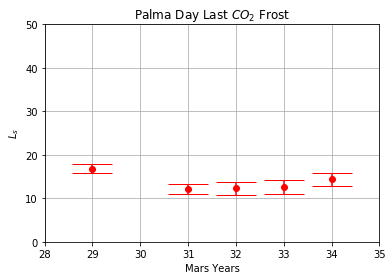

In [566]:
plt.errorbar(29,PLD29Err[0],yerr=PLD29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,PLD30Err[0],yerr=PLD30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,PLD31Err[0],yerr=PLD31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,PLD32Err[0],yerr=PLD32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,PLD33Err[0],yerr=PLD33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,PLD34Err[0],yerr=PLD34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Palma Day Last $CO_2$ Frost')
plt.ylim(0,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

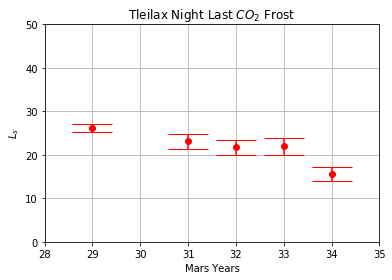

In [567]:
plt.errorbar(29,PLN29Err[0],yerr=PLN29Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
#plt.errorbar(30,PLN30Err[0],yerr=PLN30Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(31,PLN31Err[0],yerr=PLN31Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(32,PLN32Err[0],yerr=PLN32Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(33,PLN33Err[0],yerr=PLN33Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.errorbar(34,PLN34Err[0],yerr=PLN34Err[1], fmt ='o', ecolor ='r', capsize = 20, c = 'r')
plt.title('Tleilax Night Last $CO_2$ Frost')
plt.ylim(0,50)
plt.xlim(28,35)
plt.xlabel('Mars Years')
plt.ylabel('$L_s$')
plt.grid()
plt.show()

### Palma 76.2N, 95.4E

Palma was outstanding from the rest of the other locations due to its latitudinal coordinate. It is lwer in latitude than the rest of the fields thus is a good contrast to use for the other sites.We see the temperature trends in the daytime follow a less steeply sloped increase and decreace throughout the year in contrast to the other sites. The nighttime follows a similar trend except for the fact that the slopes in both cases are more steep.  Throughout the year that starts with temperatures below the carbon dioxide ($CO_2$) ice condensation point up to Solar Longitude ($L_s$) 50. Afterwards the temperature increases up to  $L_s$  100 where it reaches its maximum temperature of about 250 kelvin on average. It then then slopes downward until it reaches  $L_s$  200 where the temperature again reaches the condensation point for  $CO_2$  ice to form. Between  $L_s$  200 until  $L_s$  50 of the next year we can see an oscillatory behavior for the temperatures between the values of 140 and 150 kelvin. Tleilax has a very intersting case daily annual temperature variability that will be explained in the notes.
#### Notes

- We see that in Mars year 28 there is a lack of data as well as gap in it. Lack of data is due to the probe having begun its mission in the middle of that Mars year, the other lack of data is due to possible calibrations of MCS.


- We see throughout that there are gaps in data which can possibly be attributed to calibrations.


- We see that in Mars year 34 there is also a lack of data, this is due to the fact that the data set that we obtained ended in the middle of Mars year 34.


- Mars year 30 started with a small deviation from the other years at the beginning, it seems that there is no $CO_2$ condensation given tha all points lie above their condensation temperature


- SUPER IMPORTANT!!!! Palma exhibits different behavior temperature-wise to the other sites, the nighttime temperatures are higher in the winter than the other sites. We also see that the behavior in this site is more sinusoidal in nature than the other sites. Palma barely reaches the frost point temperature for carbon dioxide ice condensation each year.


- VERY IMPORTANT!!!! We ran the observations initially using a roughly 120x120 km box and obtained the previous results. As we increased the size of these boxes up to roughly 300x300 km, the only thing that changed was the amount of points (increased) for both the day and night plots but the trends remained the same. The other situation that changed was the distribution of points varied more the larger the box i.e. whenever the box size was increased the temperature range increased with it as well.
